### Imports

In [67]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import pickle
import torch

# Parameters

In [68]:
# import pickle
# import time
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# def objective(x):
#     return {
#         'loss': x ** 2,
#         'status': STATUS_OK,
#         # -- store other results like this
#         'eval_time': time.time(),
#         'other_stuff': {'type': None, 'value': x},
#         # -- attachments are handled differently
#         'attachments':
#             {'time_module': pickle.dumps(time.time)}
#         }
# trials = Trials()
# best = fmin(objective,
#             space=hp.uniform('x', -10, 10),
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)

# print(best)

In [69]:
# trials.results

In [70]:
# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [71]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()
two_weeks = max_date - pd.DateOffset(days=14)
one_week = max_date - pd.DateOffset(days=7)

In [72]:
training_index_slice = symbols[1]['EURUSD'].loc[:two_weeks, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[two_weeks:one_week, :].index
testing_index_slice = symbols[1]['EURUSD'].loc[one_week:, :].index

In [73]:
validation_index_slice

DatetimeIndex(['2024-04-03 00:00:00+00:00', '2024-04-03 01:00:00+00:00',
               '2024-04-03 02:00:00+00:00', '2024-04-03 03:00:00+00:00',
               '2024-04-03 04:00:00+00:00', '2024-04-03 05:00:00+00:00',
               '2024-04-03 06:00:00+00:00', '2024-04-03 07:00:00+00:00',
               '2024-04-03 08:00:00+00:00', '2024-04-03 09:00:00+00:00',
               ...
               '2024-04-09 15:00:00+00:00', '2024-04-09 16:00:00+00:00',
               '2024-04-09 17:00:00+00:00', '2024-04-09 18:00:00+00:00',
               '2024-04-09 19:00:00+00:00', '2024-04-09 20:00:00+00:00',
               '2024-04-09 21:00:00+00:00', '2024-04-09 22:00:00+00:00',
               '2024-04-09 23:00:00+00:00', '2024-04-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=121, freq=None)

### Create Env

In [74]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [75]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [76]:
sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [77]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [78]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    # 'gamma': hp.uniform('gamma', 0.97, 0.99), # Discount factor
    'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
}

In [79]:
# # create a graph that shows the distribution of values created by 10_000 iterations of 10 ** np.random.uniform(-5, -2)
# # and then plot the graph
# learning_rate_dist = [10 ** np.random.uniform(-5, 0) for _ in range(10_000)]
# sns.histplot(learning_rate_dist, kde=True)
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.title('Learning Rate Distribution')
# plt.show()



In [86]:
def env_walkthrough(env, model, seed, testing_training_env=False, run_count=10):
    reward_over_validations = []
    orders_over_validations = []

    for episode in range(0, run_count):
        if testing_training_env:
            obs_val, info_val = env.reset()
        else:
            obs_val, info_val = env.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            if testing_training_env:
                obs_val, reward_val, done_val, info_val = env.step(action)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            order_len = len(env.render()['orders'])
        except:
            order_len = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'models_4_19_24/window_{window_size_param}_entropy_{round(entropy, 4)}/model_{steps_str}_{episode}.pkl')

        reward_over_validations.append(total_reward)    
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}')

        if (avg_reward > 0) and (testing_training_env):
            print('model successfully trained!')
            break

    return reward_over_validations, orders_over_validations

In [81]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, window_size_param, lr, gamma_param, entropy, training_attempts=5, training_run_count=10, validating_run_count=10, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    print(f'entropy: {entropy}, learning rate: {lr}')
    vec_env = None
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    training_success = False
    for i in range(training_attempts):
        print(f'training model attempt {i}')
        model.learn(total_timesteps=total_learning_timesteps)

        # checking if the model learned
        vec_env = model.get_env()
        obs = vec_env.reset()
        rewards, _ = env_walkthrough(vec_env, model, seed, testing_training_env=True, run_count=training_run_count)

        if np.mean(rewards) > 0:
            training_success = True
            break
    if not training_success:
        print('Model failed to learn with those parameters')
        return ValueError('Model failed to learn with those parameters')
            

    return env_walkthrough(env_val, model, seed, run_count=validating_run_count)

### Train + Test Env

In [82]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    window_size = params['window_size']
    learning_timesteps = 50 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = 0.99 #params['gamma']
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.05:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders = train_val_model(PPO, policy, env_train, env_validation, seed, step_key, window_size, 
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps=total_learning_timesteps, 
                                                    training_attempts=5, training_run_count=10, validating_run_count=10)
    except:
        print(f'''there was an error with those parameters: Window: {window_size}, timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)     

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [87]:
train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '50K', 10, 
                                                    0.0003, 0.9, 0, total_learning_timesteps=50, 
                                                    training_attempts=5, training_run_count=10, validating_run_count=10)

--------------------------------------------------------------------------------
entropy: 0, learning rate: 0.0003


In [84]:
# check if it is working:
parameters = {
    'window_size': 10,
    'learning_timesteps': 25,
    'ent_coef': 0.0,
    'gamma': 0.9484679718228304,
    'learning_rate': 0.003
}

# objective(parameters)

--------------------------------------------------------------------------------
entropy: 0.0, learning rate: 0.003
training model attempt 0
there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.0, gamma: 0.99, learning_rate: 0.003


{'loss': None,
 'status': 'fail',
 'eval_time': 1713797105.3567555,
 'parameters': {'window_size': 10,
  'learning_timesteps': 25,
  'ent_coef': 0.0,
  'gamma': 0.9484679718228304,
  'learning_rate': 0.003}}

In [32]:
# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

# Hyperparameter search

In [33]:
trials = Trials()
best = fmin(fn=objective,
             space=space,
             algo=tpe.suggest,
             max_evals=250, # Number of evaluations of the objective function
             trials=trials,
             trials_save_file='hyperopt/trials_04_19.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
Window size: 50, entropy: 0.09564948621047711, learning rate: 0.09777522274138992
there was an error with those parameters: Window: 50, timesteps: 50, 

              ent_coef: 0.09564948621047711, gamma: 0.99, learning_rate: 0.09777522274138992
--------------------------------------------------------------------------------
Window size: 10, entropy: 0.023492586731907246, learning rate: 0.030788308384088782
  0%|          | 1/250 [04:02<16:46:19, 242.49s/trial, best loss=?]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -28921.789, # of orders: 41.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -28921.789, # of orders: 41.000:  10%|#         | 1/10 [00:02<00:21,  2.40s/it]
Episode: 1, Avg. Reward: -34085.605, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:19,  2.40s/it]
Episode: 1, Avg. Reward: -34085.605, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: -42739.601, # of orders: 45.667:  40%|####      | 4/10 [00:07<00:08,  1.49s/it]
Episode: 2, Avg. Reward: -42739.601, # of orders: 45.667:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -57238.624, # of orders: 43.750:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -57238.624, # of orders: 43.750:  60%|######    | 6/10 [00:09<00:06,  1.65s/it]
Episode: 4, Avg. Reward: -56452.200, # of orders: 43.600:  70%|#######   | 7/10 [00:11<00:04,  1.65s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -100735.695                                 
Avg. Reward          : -45402.295                                  
Max. Reward          :  18283.828                                  
Min. Orders          :     38.000                                  
Avg. Orders          :     44.800                                  
Max. Orders          :     51.000                                  
--------------------------------------------------------------------------------    
Window size: 20, entropy: 0.3525967673948514, learning rate: 0.022798376214278465   
there was an error with those parameters: Window: 20, timesteps: 50,                

              ent_coef: 0.3525967673948514, gamma: 0.99, learning_rate: 0.022798376214278465
--------------------------------------------------------------------------------    
Window size: 50, entropy: 0.11126832887943819, learning rate: 0.017296762174125433  
there was an error with those parameters: Window: 50, timesteps: 50,     

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 50633.164, # of orders: 10.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 50633.164, # of orders: 10.000:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]
Episode: 1, Avg. Reward: 25470.367, # of orders: 10.000:  20%|##        | 2/10 [00:04<00:18,  2.34s/it]
Episode: 1, Avg. Reward: 25470.367, # of orders: 10.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 18910.785, # of orders: 10.333:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 18910.785, # of orders: 10.333:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 701.158, # of orders: 11.000:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]  
Episode: 3, Avg. Reward: 701.158, # of orders: 11.000:  60%|######    | 6/10 [00:09<00:06,  1.52s/it]
Episode: 4, Avg. Reward: 10622.697, # of orders: 11.400:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 10622.697,

Min. Reward          : -91468.290                                                   
Avg. Reward          :  -2706.836                                                   
Max. Reward          :  61616.269                                                   
Min. Orders          :      6.000                                                   
Avg. Orders          :     11.800                                                   
Max. Orders          :     20.000                                                   
--------------------------------------------------------------------------------     
Window size: 20, entropy: 0.01405446007531199, learning rate: 0.05391784837922221    
there was an error with those parameters: Window: 20, timesteps: 50,                 

              ent_coef: 0.01405446007531199, gamma: 0.99, learning_rate: 0.05391784837922221
--------------------------------------------------------------------------------     
Window size: 20, entropy: 0.017429507980349247, lear

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 59033.803, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 59033.803, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:19,  2.18s/it]
Episode: 1, Avg. Reward: 65250.796, # of orders: 45.000:  20%|##        | 2/10 [00:04<00:17,  2.18s/it]
Episode: 1, Avg. Reward: 65250.796, # of orders: 45.000:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: 48901.854, # of orders: 46.333:  40%|####      | 4/10 [00:06<00:08,  1.46s/it]
Episode: 2, Avg. Reward: 48901.854, # of orders: 46.333:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 13779.929, # of orders: 43.500:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 13779.929, # of orders: 43.500:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 45554.636, # of orders: 45.200:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward: 45554.63

Min. Reward          : -98559.082                                                    
Avg. Reward          :  10517.110                                                    
Max. Reward          : 172653.461                                                    
Min. Orders          :     31.000                                                    
Avg. Orders          :     42.100                                                    
Max. Orders          :     52.000                                                    
--------------------------------------------------------------------------------       
Window size: 50, entropy: 0.8811984324667926, learning rate: 0.011592448751920897      
there was an error with those parameters: Window: 50, timesteps: 50,                   

              ent_coef: 0.8811984324667926, gamma: 0.99, learning_rate: 0.011592448751920897
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.0469841069

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -7716.087, # of orders: 61.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -7716.087, # of orders: 61.000:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]
Episode: 1, Avg. Reward: 2041.490, # of orders: 62.000:  20%|##        | 2/10 [00:04<00:18,  2.34s/it] 
Episode: 1, Avg. Reward: 2041.490, # of orders: 62.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 11969.160, # of orders: 66.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 11969.160, # of orders: 66.333:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 15223.792, # of orders: 65.250:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 15223.792, # of orders: 65.250:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 17621.268, # of orders: 66.200:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 17621.268

Min. Reward          : -14744.140                                                      
Avg. Reward          :   9581.457                                                        
Max. Reward          :  31824.502                                                        
Min. Orders          :     60.000                                                        
Avg. Orders          :     65.000                                                        
Max. Orders          :     75.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.007885725251776814, learning rate: 0.007677026676239352      
  8%|▊         | 21/250 [1:04:25<12:27:41, 195.90s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 1261.243, # of orders: 107.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 1261.243, # of orders: 107.000:  10%|#         | 1/10 [00:02<00:21,  2.44s/it]
Episode: 1, Avg. Reward: 1034.175, # of orders: 108.000:  20%|##        | 2/10 [00:04<00:19,  2.44s/it]
Episode: 1, Avg. Reward: 1034.175, # of orders: 108.000:  30%|###       | 3/10 [00:04<00:10,  1.48s/it]
Episode: 2, Avg. Reward: -1376.850, # of orders: 107.333:  40%|####      | 4/10 [00:07<00:08,  1.48s/it]
Episode: 2, Avg. Reward: -1376.850, # of orders: 107.333:  50%|#####     | 5/10 [00:07<00:06,  1.31s/it]
Episode: 3, Avg. Reward: 1463.258, # of orders: 107.250:  50%|#####     | 5/10 [00:09<00:06,  1.31s/it] 
Episode: 3, Avg. Reward: 1463.258, # of orders: 107.250:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: 2307.590, # of orders: 107.800:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it]
Episode: 4, Avg. Reward: 2307.

Min. Reward          :  -6198.901                                                        
Avg. Reward          :    470.057                                                        
Max. Reward          :   9983.582                                                        
Min. Orders          :    106.000                                                        
Avg. Orders          :    108.000                                                        
Max. Orders          :    111.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.007020453339845639, learning rate: 0.007550967806996813      
  9%|▉         | 22/250 [1:10:17<15:22:30, 242.77s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 1233.458, # of orders: 4.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 1233.458, # of orders: 4.000:  10%|#         | 1/10 [00:02<00:20,  2.30s/it]
Episode: 1, Avg. Reward: 616.729, # of orders: 2.000:  20%|##        | 2/10 [00:04<00:18,  2.30s/it] 
Episode: 1, Avg. Reward: 616.729, # of orders: 2.000:  30%|###       | 3/10 [00:04<00:09,  1.34s/it]
Episode: 2, Avg. Reward: 52.291, # of orders: 2.333:  40%|####      | 4/10 [00:06<00:08,  1.34s/it] 
Episode: 2, Avg. Reward: 52.291, # of orders: 2.333:  50%|#####     | 5/10 [00:06<00:05,  1.15s/it]
Episode: 3, Avg. Reward: -65.197, # of orders: 2.000:  50%|#####     | 5/10 [00:08<00:05,  1.15s/it]
Episode: 3, Avg. Reward: -65.197, # of orders: 2.000:  60%|######    | 6/10 [00:08<00:05,  1.39s/it]
Episode: 4, Avg. Reward: 749.886, # of orders: 2.200:  70%|#######   | 7/10 [00:10<00:04,  1.39s/it]
Episode: 4, Avg. Reward: 749.886, # of orders: 2.200:  80%

Min. Reward          :  -1076.583                                                        
Avg. Reward          :    179.947                                                        
Max. Reward          :   4010.216                                                        
Min. Orders          :      0.000                                                        
Avg. Orders          :      1.800                                                        
Max. Orders          :      4.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.03850018681169304, learning rate: 0.010015659745857396       
  9%|▉         | 23/250 [1:16:04<17:16:28, 273.96s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78877.637, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78877.637, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:18,  2.09s/it]
Episode: 1, Avg. Reward: 62850.157, # of orders: 42.000:  20%|##        | 2/10 [00:04<00:16,  2.09s/it]
Episode: 1, Avg. Reward: 62850.157, # of orders: 42.000:  30%|###       | 3/10 [00:04<00:09,  1.34s/it]
Episode: 2, Avg. Reward: 50522.308, # of orders: 42.667:  40%|####      | 4/10 [00:06<00:08,  1.34s/it]
Episode: 2, Avg. Reward: 50522.308, # of orders: 42.667:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 10853.829, # of orders: 39.750:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 10853.829, # of orders: 39.750:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]
Episode: 4, Avg. Reward: 41176.951, # of orders: 42.200:  70%|#######   | 7/10 [00:10<00:04,  1.49s/it]
Episode: 4, Avg. Reward: 41176.95

Min. Reward          : -108151.606                                                       
Avg. Reward          :   7910.803                                                        
Max. Reward          : 162469.437                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.000                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.011001078094835387, learning rate: 0.009292093458643631      
 10%|▉         | 24/250 [1:21:42<18:24:25, 293.21s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -27150.623, # of orders: 89.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -27150.623, # of orders: 89.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: -28097.354, # of orders: 91.000:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]
Episode: 1, Avg. Reward: -28097.354, # of orders: 91.000:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: -12711.264, # of orders: 92.000:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: -12711.264, # of orders: 92.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -10190.724, # of orders: 93.000:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -10190.724, # of orders: 93.000:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: -6815.039, # of orders: 94.200:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it] 
Episode: 4, Avg. Reward:

Min. Reward          : -46931.837                                                        
Avg. Reward          :  -9864.190                                                        
Max. Reward          :  20588.965                                                        
Min. Orders          :     89.000                                                        
Avg. Orders          :     94.700                                                        
Max. Orders          :     99.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.9846848763271466, learning rate: 0.013996710817408343        
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.9846848763271466, gamma: 0.99, learning_rate: 0.013996710817408343
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -22044.057, # of orders: 56.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -22044.057, # of orders: 56.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: -13716.295, # of orders: 57.500:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: -13716.295, # of orders: 57.500:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: -10013.989, # of orders: 61.333:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: -10013.989, # of orders: 61.333:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -15923.857, # of orders: 60.250:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -15923.857, # of orders: 60.250:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: -7478.275, # of orders: 60.400:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it] 
Episode: 4, Avg. Reward:

Min. Reward          : -55231.145                                                        
Avg. Reward          : -15527.128                                                        
Max. Reward          :  26304.055                                                        
Min. Orders          :     56.000                                                        
Avg. Orders          :     59.200                                                        
Max. Orders          :     69.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.010544838069919826, learning rate: 0.009661026785994344      
 11%|█         | 27/250 [1:36:55<18:20:49, 296.19s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -62232.412, # of orders: 64.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -62232.412, # of orders: 64.000:  10%|#         | 1/10 [00:02<00:21,  2.44s/it]
Episode: 1, Avg. Reward: -31822.184, # of orders: 63.500:  20%|##        | 2/10 [00:04<00:19,  2.44s/it]
Episode: 1, Avg. Reward: -31822.184, # of orders: 63.500:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: -18355.237, # of orders: 66.000:  40%|####      | 4/10 [00:06<00:08,  1.47s/it]
Episode: 2, Avg. Reward: -18355.237, # of orders: 66.000:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -19243.424, # of orders: 65.000:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -19243.424, # of orders: 65.000:  60%|######    | 6/10 [00:09<00:06,  1.52s/it]
Episode: 4, Avg. Reward: -14087.675, # of orders: 65.400:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -62232.412                                                        
Avg. Reward          : -12699.837                                                        
Max. Reward          :   8578.657                                                        
Min. Orders          :     61.000                                                        
Avg. Orders          :     64.500                                                        
Max. Orders          :     71.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.07308259896276262, learning rate: 0.014690886863787845       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.07308259896276262, gamma: 0.99, learning_rate: 0.014690886863787845
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 83506.752, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 83506.752, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.27s/it]
Episode: 1, Avg. Reward: 61631.490, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.27s/it]
Episode: 1, Avg. Reward: 61631.490, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: 46171.917, # of orders: 43.333:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: 46171.917, # of orders: 43.333:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 6670.541, # of orders: 40.250:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it] 
Episode: 3, Avg. Reward: 6670.541, # of orders: 40.250:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 38102.799, # of orders: 42.600:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 38102.799

Min. Reward          : -111833.586                                                       
Avg. Reward          :   5716.412                                                        
Max. Reward          : 163831.832                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.200                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.029967932078914808, learning rate: 0.017578384832069267      
 13%|█▎        | 33/250 [2:04:35<16:22:19, 271.61s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -17077.775, # of orders: 55.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -17077.775, # of orders: 55.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 5478.433, # of orders: 55.500:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]  
Episode: 1, Avg. Reward: 5478.433, # of orders: 55.500:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: -24241.901, # of orders: 54.667:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: -24241.901, # of orders: 54.667:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -41593.941, # of orders: 52.500:  50%|#####     | 5/10 [00:08<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -41593.941, # of orders: 52.500:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]
Episode: 4, Avg. Reward: -19307.685, # of orders: 55.000:  70%|#######   | 7/10 [00:10<00:04,  1.49s/it]
Episode: 4, Avg. Reward: -

Min. Reward          : -93650.062                                                        
Avg. Reward          : -17408.528                                                        
Max. Reward          :  69837.340                                                        
Min. Orders          :     46.000                                                        
Avg. Orders          :     53.900                                                        
Max. Orders          :     65.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.08789027742369922, learning rate: 0.008456999663800403       
 14%|█▎        | 34/250 [2:10:20<17:37:31, 293.76s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 76744.793, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 76744.793, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 59969.356, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]
Episode: 1, Avg. Reward: 59969.356, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 47575.422, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 47575.422, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 9138.560, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.26s/it] 
Episode: 3, Avg. Reward: 9138.560, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.60s/it]
Episode: 4, Avg. Reward: 40022.246, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.60s/it]
Episode: 4, Avg. Reward: 40022.246

Min. Reward          : -106172.025                                                       
Avg. Reward          :   6428.191                                                        
Max. Reward          : 163556.991                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.400                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.018193453587039738, learning rate: 0.011371931460990158      
 14%|█▍        | 35/250 [2:16:07<18:29:22, 309.59s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -1427.595, # of orders: 46.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -1427.595, # of orders: 46.000:  10%|#         | 1/10 [00:02<00:20,  2.24s/it]
Episode: 1, Avg. Reward: 1716.152, # of orders: 48.000:  20%|##        | 2/10 [00:04<00:17,  2.24s/it] 
Episode: 1, Avg. Reward: 1716.152, # of orders: 48.000:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 4426.969, # of orders: 52.000:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 4426.969, # of orders: 52.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 6269.178, # of orders: 51.750:  50%|#####     | 5/10 [00:08<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 6269.178, # of orders: 51.750:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 8544.979, # of orders: 51.200:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it]
Episode: 4, Avg. Reward: 8544.979, # of

Min. Reward          : -11003.857                                                        
Avg. Reward          :   7479.862                                                        
Max. Reward          :  17976.139                                                        
Min. Orders          :     46.000                                                        
Avg. Orders          :     50.700                                                        
Max. Orders          :     60.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.010935837875319236, learning rate: 0.016113536201694714      
 14%|█▍        | 36/250 [2:21:57<19:07:47, 321.81s/trial, best loss: -10517.110065987192]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 3128.908, # of orders: 4.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 3128.908, # of orders: 4.000:  10%|#         | 1/10 [00:02<00:20,  2.26s/it]
Episode: 1, Avg. Reward: 779.175, # of orders: 3.000:  20%|##        | 2/10 [00:04<00:18,  2.26s/it] 
Episode: 1, Avg. Reward: 779.175, # of orders: 3.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 1822.541, # of orders: 3.333:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 1822.541, # of orders: 3.333:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -1747.995, # of orders: 3.500:  50%|#####     | 5/10 [00:08<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -1747.995, # of orders: 3.500:  60%|######    | 6/10 [00:08<00:05,  1.46s/it]
Episode: 4, Avg. Reward: 3058.212, # of orders: 3.400:  70%|#######   | 7/10 [00:10<00:04,  1.46s/it] 
Episode: 4, Avg. Reward: 3058.212, # of orders: 3

Min. Reward          : -25394.999                                                        
Avg. Reward          :  -5628.064                                                        
Max. Reward          :  22283.037                                                        
Min. Orders          :      1.000                                                        
Avg. Orders          :      2.800                                                        
Max. Orders          :      5.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.2672446407262109, learning rate: 0.02703752294430668         
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.2672446407262109, gamma: 0.99, learning_rate: 0.02703752294430668
--------------------------------------------------------------------------------         
Window 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 74610.049, # of orders: 49.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 74610.049, # of orders: 49.000:  10%|#         | 1/10 [00:02<00:18,  2.11s/it]
Episode: 1, Avg. Reward: 46082.571, # of orders: 49.000:  20%|##        | 2/10 [00:04<00:16,  2.11s/it]
Episode: 1, Avg. Reward: 46082.571, # of orders: 49.000:  30%|###       | 3/10 [00:04<00:09,  1.34s/it]
Episode: 2, Avg. Reward: 16051.362, # of orders: 52.000:  40%|####      | 4/10 [00:06<00:08,  1.34s/it]
Episode: 2, Avg. Reward: 16051.362, # of orders: 52.000:  50%|#####     | 5/10 [00:06<00:06,  1.21s/it]
Episode: 3, Avg. Reward: -10595.166, # of orders: 51.250:  50%|#####     | 5/10 [00:08<00:06,  1.21s/it]
Episode: 3, Avg. Reward: -10595.166, # of orders: 51.250:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: -12768.463, # of orders: 51.400:  70%|#######   | 7/10 [00:10<00:04,  1.48s/it]
Episode: 4, Avg. Reward: -1276

Min. Reward          : -95331.860                                                        
Avg. Reward          : -18096.491                                                        
Max. Reward          :  74610.049                                                        
Min. Orders          :     41.000                                                        
Avg. Orders          :     49.300                                                        
Max. Orders          :     58.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.03868725490060288, learning rate: 0.02554848264426082        
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.03868725490060288, gamma: 0.99, learning_rate: 0.02554848264426082
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 3618.608, # of orders: 52.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 3618.608, # of orders: 52.000:  10%|#         | 1/10 [00:02<00:22,  2.54s/it]
Episode: 1, Avg. Reward: 12324.807, # of orders: 53.500:  20%|##        | 2/10 [00:04<00:20,  2.54s/it]
Episode: 1, Avg. Reward: 12324.807, # of orders: 53.500:  30%|###       | 3/10 [00:04<00:10,  1.48s/it]
Episode: 2, Avg. Reward: 14101.421, # of orders: 57.000:  40%|####      | 4/10 [00:07<00:08,  1.48s/it]
Episode: 2, Avg. Reward: 14101.421, # of orders: 57.000:  50%|#####     | 5/10 [00:07<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 18638.728, # of orders: 56.500:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 18638.728, # of orders: 56.500:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 23435.577, # of orders: 57.000:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 23435.577,

Min. Reward          : -23298.881                                                        
Avg. Reward          :  12976.213                                                        
Max. Reward          :  42622.976                                                        
Min. Orders          :     52.000                                                        
Avg. Orders          :     56.800                                                        
Max. Orders          :     64.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.00919677741900455, learning rate: 0.018391769399281797       
 18%|█▊        | 45/250 [2:53:29<11:51:18, 208.19s/trial, best loss: -12976.212750419232]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 21429.197, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 21429.197, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.26s/it]
Episode: 1, Avg. Reward: 21234.323, # of orders: 39.500:  20%|##        | 2/10 [00:04<00:18,  2.26s/it]
Episode: 1, Avg. Reward: 21234.323, # of orders: 39.500:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: 24385.902, # of orders: 43.000:  40%|####      | 4/10 [00:06<00:08,  1.46s/it]
Episode: 2, Avg. Reward: 24385.902, # of orders: 43.000:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]
Episode: 3, Avg. Reward: 24383.250, # of orders: 43.000:  50%|#####     | 5/10 [00:09<00:06,  1.25s/it]
Episode: 3, Avg. Reward: 24383.250, # of orders: 43.000:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 32411.949, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward: 32411.94

Min. Reward          : -22987.134                                                        
Avg. Reward          :  22734.268                                                        
Max. Reward          :  64526.745                                                        
Min. Orders          :     37.000                                                        
Avg. Orders          :     44.600                                                        
Max. Orders          :     54.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.009409702000553301, learning rate: 0.04940551482791615      
there was an error with those parameters: Window: 50, timesteps: 50,                    

              ent_coef: 0.009409702000553301, gamma: 0.99, learning_rate: 0.04940551482791615
--------------------------------------------------------------------------------        
Window s

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:19,  2.21s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:17,  2.21s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it] 
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: 39320.458, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: 39320.458

Min. Reward          : -109768.415                                                      
Avg. Reward          :   7419.525                                                       
Max. Reward          : 165561.472                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.400                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.01706183323620568, learning rate: 0.01819338861963493       
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.01706183323620568, gamma: 0.99, learning_rate: 0.01819338861963493
--------------------------------------------------------------------------------        
Window size: 50,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 72602.591, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 72602.591, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]
Episode: 1, Avg. Reward: 60690.936, # of orders: 42.000:  20%|##        | 2/10 [00:04<00:17,  2.23s/it]
Episode: 1, Avg. Reward: 60690.936, # of orders: 42.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 47372.774, # of orders: 44.333:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 47372.774, # of orders: 44.333:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 9695.832, # of orders: 41.000:  50%|#####     | 5/10 [00:08<00:06,  1.28s/it] 
Episode: 3, Avg. Reward: 9695.832, # of orders: 41.000:  60%|######    | 6/10 [00:08<00:06,  1.52s/it]
Episode: 4, Avg. Reward: 40952.199, # of orders: 43.200:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 40952.199

Min. Reward          : -103334.995                                                      
Avg. Reward          :  13236.529                                                       
Max. Reward          : 165977.670                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.900                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.04813400335732839, learning rate: 0.07064561910760186       
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.04813400335732839, gamma: 0.99, learning_rate: 0.07064561910760186
--------------------------------------------------------------------------------        
Window size: 10,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 61192.173, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 61192.173, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:21,  2.35s/it]
Episode: 1, Avg. Reward: 43078.215, # of orders: 40.000:  20%|##        | 2/10 [00:04<00:18,  2.35s/it]
Episode: 1, Avg. Reward: 43078.215, # of orders: 40.000:  30%|###       | 3/10 [00:04<00:10,  1.43s/it]
Episode: 2, Avg. Reward: 15281.849, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.43s/it]
Episode: 2, Avg. Reward: 15281.849, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -13254.311, # of orders: 41.250:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -13254.311, # of orders: 41.250:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 12513.224, # of orders: 42.200:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it] 
Episode: 4, Avg. Reward: 12513

Min. Reward          : -100103.900                                                      
Avg. Reward          :  -4351.232                                                       
Max. Reward          : 115583.364                                                       
Min. Orders          :     29.000                                                       
Avg. Orders          :     40.500                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.027290063054265054, learning rate: 0.05918417604954051      
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.027290063054265054, gamma: 0.99, learning_rate: 0.05918417604954051
--------------------------------------------------------------------------------        
Window size: 50

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 80912.234, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 80912.234, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 61658.450, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]
Episode: 1, Avg. Reward: 61658.450, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 37689.850, # of orders: 42.667:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 37689.850, # of orders: 42.667:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: 1151.597, # of orders: 39.750:  50%|#####     | 5/10 [00:09<00:06,  1.24s/it] 
Episode: 3, Avg. Reward: 1151.597, # of orders: 39.750:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: 33181.676, # of orders: 42.200:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it]
Episode: 4, Avg. Reward: 33181.676

Min. Reward          : -108463.162                                                      
Avg. Reward          :   3273.198                                                       
Max. Reward          : 161301.990                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.000                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.02036755058335171, learning rate: 0.041688986505730594      
 23%|██▎       | 58/250 [3:41:07<11:07:56, 208.73s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 76111.892, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 76111.892, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 64257.626, # of orders: 42.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 64257.626, # of orders: 42.000:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 49898.575, # of orders: 42.667:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 49898.575, # of orders: 42.667:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 12738.845, # of orders: 39.000:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 12738.845, # of orders: 39.000:  60%|######    | 6/10 [00:08<00:05,  1.47s/it]
Episode: 4, Avg. Reward: 40485.889, # of orders: 41.400:  70%|#######   | 7/10 [00:10<00:04,  1.47s/it]
Episode: 4, Avg. Reward: 40485.88

Min. Reward          : -98740.346                                                       
Avg. Reward          :   8884.216                                                       
Max. Reward          : 151474.067                                                       
Min. Orders          :     28.000                                                       
Avg. Orders          :     39.400                                                       
Max. Orders          :     51.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.0068899281713534506, learning rate: 0.03281157108158767     
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.0068899281713534506, gamma: 0.99, learning_rate: 0.03281157108158767
--------------------------------------------------------------------------------        
Window size: 1

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 75139.036, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 75139.036, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 57659.471, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.25s/it]
Episode: 1, Avg. Reward: 57659.471, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 45615.906, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 45615.906, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 7556.777, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it] 
Episode: 3, Avg. Reward: 7556.777, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: 39007.833, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it]
Episode: 4, Avg. Reward: 39007.833

Min. Reward          : -106620.609                                                      
Avg. Reward          :   6439.325                                                       
Max. Reward          : 164812.053                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.300                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.13633312370417433, learning rate: 0.03041150718694796       
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.13633312370417433, gamma: 0.99, learning_rate: 0.03041150718694796
--------------------------------------------------------------------------------        
Window size: 20,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 30079.118, # of orders: 41.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 30079.118, # of orders: 41.000:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]
Episode: 1, Avg. Reward: 32775.528, # of orders: 39.000:  20%|##        | 2/10 [00:04<00:17,  2.23s/it]
Episode: 1, Avg. Reward: 32775.528, # of orders: 39.000:  30%|###       | 3/10 [00:04<00:09,  1.38s/it]
Episode: 2, Avg. Reward: 22000.282, # of orders: 42.000:  40%|####      | 4/10 [00:06<00:08,  1.38s/it]
Episode: 2, Avg. Reward: 22000.282, # of orders: 42.000:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -6599.009, # of orders: 42.000:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -6599.009, # of orders: 42.000:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: 1000.703, # of orders: 41.400:  70%|#######   | 7/10 [00:10<00:04,  1.48s/it] 
Episode: 4, Avg. Reward: 1000.703

Min. Reward          : -92396.884                                                       
Avg. Reward          :  -4919.342                                                       
Max. Reward          :  35471.937                                                       
Min. Orders          :     37.000                                                       
Avg. Orders          :     42.300                                                       
Max. Orders          :     48.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.009888198931573866, learning rate: 0.02216306177830747      
 26%|██▋       | 66/250 [4:11:58<11:26:33, 223.88s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 79737.217, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 79737.217, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 60418.669, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.25s/it]
Episode: 1, Avg. Reward: 60418.669, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.37s/it]
Episode: 2, Avg. Reward: 46461.510, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.37s/it]
Episode: 2, Avg. Reward: 46461.510, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 7962.014, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it] 
Episode: 3, Avg. Reward: 7962.014, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: 38777.429, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.48s/it]
Episode: 4, Avg. Reward: 38777.429

Min. Reward          : -107536.473                                                      
Avg. Reward          :   6603.203                                                       
Max. Reward          : 162039.089                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.300                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.011895341928286039, learning rate: 0.008637466310210673     
 27%|██▋       | 67/250 [4:17:44<13:14:51, 260.61s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 6948.845, # of orders: 36.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 6948.845, # of orders: 36.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 8379.129, # of orders: 35.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 8379.129, # of orders: 35.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 7517.664, # of orders: 39.667:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 7517.664, # of orders: 39.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 8565.735, # of orders: 38.250:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 8565.735, # of orders: 38.250:  60%|######    | 6/10 [00:09<00:06,  1.52s/it]
Episode: 4, Avg. Reward: 10208.099, # of orders: 38.200:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 10208.099, # of 

Min. Reward          :  -2314.744                                                       
Avg. Reward          :   9052.825                                                       
Max. Reward          :  24972.674                                                       
Min. Orders          :     33.000                                                       
Avg. Orders          :     40.800                                                       
Max. Orders          :     49.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.007675482927022876, learning rate: 0.016042004989383764     
 27%|██▋       | 68/250 [4:23:20<14:19:17, 283.28s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -28326.540, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -28326.540, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:21,  2.38s/it]
Episode: 1, Avg. Reward: -1691.394, # of orders: 45.000:  20%|##        | 2/10 [00:04<00:19,  2.38s/it] 
Episode: 1, Avg. Reward: -1691.394, # of orders: 45.000:  30%|###       | 3/10 [00:04<00:09,  1.43s/it]
Episode: 2, Avg. Reward: -13989.914, # of orders: 44.333:  40%|####      | 4/10 [00:06<00:08,  1.43s/it]
Episode: 2, Avg. Reward: -13989.914, # of orders: 44.333:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -33254.758, # of orders: 43.000:  50%|#####     | 5/10 [00:08<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -33254.758, # of orders: 43.000:  60%|######    | 6/10 [00:08<00:06,  1.52s/it]
Episode: 4, Avg. Reward: -32909.691, # of orders: 44.000:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 

Min. Reward          : -91049.288                                                       
Avg. Reward          : -27173.432                                                       
Max. Reward          :  28809.555                                                       
Min. Orders          :     37.000                                                       
Avg. Orders          :     42.000                                                       
Max. Orders          :     48.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.021375083072467268, learning rate: 0.018658531443756787     
 28%|██▊       | 69/250 [4:29:09<15:14:07, 303.02s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77493.083, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77493.083, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.31s/it]
Episode: 1, Avg. Reward: 73992.929, # of orders: 46.000:  20%|##        | 2/10 [00:04<00:18,  2.31s/it]
Episode: 1, Avg. Reward: 73992.929, # of orders: 46.000:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: 43114.405, # of orders: 45.000:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: 43114.405, # of orders: 45.000:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: 5343.015, # of orders: 41.500:  50%|#####     | 5/10 [00:08<00:06,  1.24s/it] 
Episode: 3, Avg. Reward: 5343.015, # of orders: 41.500:  60%|######    | 6/10 [00:08<00:06,  1.52s/it]
Episode: 4, Avg. Reward: 35001.677, # of orders: 44.600:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 35001.677

Min. Reward          : -107971.156                                                      
Avg. Reward          :   8136.254                                                       
Max. Reward          : 153636.324                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     42.900                                                       
Max. Orders          :     57.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.01847418166319838, learning rate: 0.01437503443427366       
 28%|██▊       | 70/250 [4:34:57<15:49:00, 316.34s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 45088.669, # of orders: 40.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 45088.669, # of orders: 40.000:  10%|#         | 1/10 [00:02<00:22,  2.51s/it]
Episode: 1, Avg. Reward: 44102.069, # of orders: 39.500:  20%|##        | 2/10 [00:04<00:20,  2.51s/it]
Episode: 1, Avg. Reward: 44102.069, # of orders: 39.500:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: 22689.204, # of orders: 42.000:  40%|####      | 4/10 [00:06<00:08,  1.49s/it]
Episode: 2, Avg. Reward: 22689.204, # of orders: 42.000:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -5780.420, # of orders: 41.500:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -5780.420, # of orders: 41.500:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 27530.772, # of orders: 42.200:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 27530.77

Min. Reward          : -94311.428                                                       
Avg. Reward          :  -1191.274                                                       
Max. Reward          : 160775.541                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.600                                                       
Max. Orders          :     47.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.031145504604778475, learning rate: 0.02755562953753276      
 28%|██▊       | 71/250 [4:40:41<16:08:41, 324.70s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 58479.206, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 58479.206, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 51772.369, # of orders: 40.500:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 51772.369, # of orders: 40.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 28559.633, # of orders: 40.000:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 28559.633, # of orders: 40.000:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -3466.523, # of orders: 37.750:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -3466.523, # of orders: 37.750:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: 3226.144, # of orders: 38.000:  70%|#######   | 7/10 [00:11<00:04,  1.48s/it] 
Episode: 4, Avg. Reward: 3226.144

Min. Reward          : -99544.992                                                       
Avg. Reward          :  -4516.779                                                       
Max. Reward          :  58479.206                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     37.800                                                       
Max. Orders          :     42.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.01547134438372093, learning rate: 0.00744268787085767       
 29%|██▉       | 72/250 [4:46:30<16:24:55, 332.00s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 38674.982, # of orders: 56.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 38674.982, # of orders: 56.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 10270.404, # of orders: 54.500:  20%|##        | 2/10 [00:04<00:18,  2.25s/it]
Episode: 1, Avg. Reward: 10270.404, # of orders: 54.500:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: -18814.735, # of orders: 41.667:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: -18814.735, # of orders: 41.667:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -31759.808, # of orders: 45.750:  50%|#####     | 5/10 [00:08<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -31759.808, # of orders: 45.750:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]
Episode: 4, Avg. Reward: -25080.721, # of orders: 48.200:  70%|#######   | 7/10 [00:11<00:04,  1.49s/it]
Episode: 4, Avg. Reward: -25

Min. Reward          : -110048.553                                                      
Avg. Reward          : -37345.784                                                       
Max. Reward          :  51108.000                                                       
Min. Orders          :     14.000                                                       
Avg. Orders          :     40.000                                                       
Max. Orders          :     58.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.024613534627917807, learning rate: 0.010565897728818673     
 29%|██▉       | 73/250 [4:52:22<16:37:27, 338.12s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 14529.211, # of orders: 50.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 14529.211, # of orders: 50.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 13434.929, # of orders: 52.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 13434.929, # of orders: 52.000:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: 20972.485, # of orders: 56.667:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: 20972.485, # of orders: 56.667:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: 13040.668, # of orders: 56.250:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: 13040.668, # of orders: 56.250:  60%|######    | 6/10 [00:09<00:06,  1.67s/it]
Episode: 4, Avg. Reward: 15415.242, # of orders: 56.600:  70%|#######   | 7/10 [00:11<00:05,  1.67s/it]
Episode: 4, Avg. Reward: 15415.24

Min. Reward          : -36833.684                                                       
Avg. Reward          :   5062.672                                                       
Max. Reward          :  36047.598                                                       
Min. Orders          :     50.000                                                       
Avg. Orders          :     55.700                                                       
Max. Orders          :     66.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.011422841362044042, learning rate: 0.023818979946211946     
 30%|██▉       | 74/250 [4:58:12<16:41:55, 341.57s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -52824.014, # of orders: 37.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -52824.014, # of orders: 37.000:  10%|#         | 1/10 [00:02<00:20,  2.27s/it]
Episode: 1, Avg. Reward: -57337.433, # of orders: 37.500:  20%|##        | 2/10 [00:04<00:18,  2.27s/it]
Episode: 1, Avg. Reward: -57337.433, # of orders: 37.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: -44487.397, # of orders: 42.000:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: -44487.397, # of orders: 42.000:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -55753.825, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.24s/it]
Episode: 3, Avg. Reward: -55753.825, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]
Episode: 4, Avg. Reward: -53321.930, # of orders: 40.800:  70%|#######   | 7/10 [00:10<00:04,  1.49s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -89553.107                                                       
Avg. Reward          : -40291.923                                                       
Max. Reward          :  30483.865                                                       
Min. Orders          :     36.000                                                       
Avg. Orders          :     41.500                                                       
Max. Orders          :     51.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.0781869359304036, learning rate: 0.03447655247209569        
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.0781869359304036, gamma: 0.99, learning_rate: 0.03447655247209569
--------------------------------------------------------------------------------        
Window size: 10, 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -63237.746, # of orders: 99.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -63237.746, # of orders: 99.000:  10%|#         | 1/10 [00:02<00:20,  2.33s/it]
Episode: 1, Avg. Reward: -67612.352, # of orders: 94.000:  20%|##        | 2/10 [00:04<00:18,  2.33s/it]
Episode: 1, Avg. Reward: -67612.352, # of orders: 94.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: -56170.232, # of orders: 91.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: -56170.232, # of orders: 91.667:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -53800.047, # of orders: 91.250:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -53800.047, # of orders: 91.250:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: -46567.812, # of orders: 91.600:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -71986.959                                                       
Avg. Reward          : -45803.175                                                       
Max. Reward          : -17638.870                                                       
Min. Orders          :     86.000                                                       
Avg. Orders          :     92.000                                                       
Max. Orders          :     99.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.008522349826419475, learning rate: 0.04084650101313353      
 31%|███       | 77/250 [5:13:17<14:58:25, 311.59s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 55723.084, # of orders: 19.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 55723.084, # of orders: 19.000:  10%|#         | 1/10 [00:02<00:20,  2.30s/it]
Episode: 1, Avg. Reward: 26854.178, # of orders: 18.000:  20%|##        | 2/10 [00:04<00:18,  2.30s/it]
Episode: 1, Avg. Reward: 26854.178, # of orders: 18.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: -879.171, # of orders: 20.333:  40%|####      | 4/10 [00:06<00:08,  1.42s/it] 
Episode: 2, Avg. Reward: -879.171, # of orders: 20.333:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -21531.762, # of orders: 20.000:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it]
Episode: 3, Avg. Reward: -21531.762, # of orders: 20.000:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -10803.956, # of orders: 20.000:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: -10803

Min. Reward          : -116658.121                                                      
Avg. Reward          : -25996.435                                                       
Max. Reward          :  55723.084                                                       
Min. Orders          :     15.000                                                       
Avg. Orders          :     19.200                                                       
Max. Orders          :     25.000                                                       
--------------------------------------------------------------------------------        
Window size: 50, entropy: 0.03624821072669111, learning rate: 0.0210331603382441        
there was an error with those parameters: Window: 50, timesteps: 50,                    

              ent_coef: 0.03624821072669111, gamma: 0.99, learning_rate: 0.0210331603382441
--------------------------------------------------------------------------------        
Window size: 10, 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 34073.641, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 34073.641, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.42s/it]
Episode: 1, Avg. Reward: 44665.303, # of orders: 46.000:  20%|##        | 2/10 [00:04<00:19,  2.42s/it]
Episode: 1, Avg. Reward: 44665.303, # of orders: 46.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 10967.865, # of orders: 48.000:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 10967.865, # of orders: 48.000:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -14198.964, # of orders: 47.250:  50%|#####     | 5/10 [00:08<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -14198.964, # of orders: 47.250:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 15531.905, # of orders: 48.400:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it] 
Episode: 4, Avg. Reward: 15531

Min. Reward          : -89699.450                                                       
Avg. Reward          :  -4624.594                                                       
Max. Reward          : 134455.381                                                       
Min. Orders          :     42.000                                                       
Avg. Orders          :     47.000                                                       
Max. Orders          :     53.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.02878871612051067, learning rate: 0.01664848775244751       
 32%|███▏      | 80/250 [5:27:07<13:16:45, 281.21s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -23639.883, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -23639.883, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.44s/it]
Episode: 1, Avg. Reward: -20754.684, # of orders: 47.000:  20%|##        | 2/10 [00:04<00:19,  2.44s/it]
Episode: 1, Avg. Reward: -20754.684, # of orders: 47.000:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: -19237.303, # of orders: 51.667:  40%|####      | 4/10 [00:06<00:08,  1.47s/it]
Episode: 2, Avg. Reward: -19237.303, # of orders: 51.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -21563.428, # of orders: 52.000:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -21563.428, # of orders: 52.000:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: -8648.821, # of orders: 53.000:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it] 
Episode: 4, Avg. Reward:

Min. Reward          : -95343.493                                                       
Avg. Reward          : -17122.731                                                       
Max. Reward          :  50360.030                                                       
Min. Orders          :     43.000                                                       
Avg. Orders          :     50.900                                                       
Max. Orders          :     61.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.006803807664776432, learning rate: 0.06378279205579493      
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.006803807664776432, gamma: 0.99, learning_rate: 0.06378279205579493
--------------------------------------------------------------------------------        
Window size: 10

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 149.475, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 149.475, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]
Episode: 1, Avg. Reward: 7275.905, # of orders: 41.000:  20%|##        | 2/10 [00:04<00:17,  2.23s/it]
Episode: 1, Avg. Reward: 7275.905, # of orders: 41.000:  30%|###       | 3/10 [00:04<00:09,  1.38s/it]
Episode: 2, Avg. Reward: 14230.916, # of orders: 45.000:  40%|####      | 4/10 [00:06<00:08,  1.38s/it]
Episode: 2, Avg. Reward: 14230.916, # of orders: 45.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 12452.098, # of orders: 44.750:  50%|#####     | 5/10 [00:08<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 12452.098, # of orders: 44.750:  60%|######    | 6/10 [00:08<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 16921.706, # of orders: 43.800:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 16921.706, # o

Min. Reward          : -35613.231                                                       
Avg. Reward          :  10156.015                                                       
Max. Reward          :  51233.945                                                       
Min. Orders          :     39.000                                                       
Avg. Orders          :     45.500                                                       
Max. Orders          :     54.000                                                       
--------------------------------------------------------------------------------        
Window size: 50, entropy: 0.013296243557209222, learning rate: 0.015113788261816122     
there was an error with those parameters: Window: 50, timesteps: 50,                    

              ent_coef: 0.013296243557209222, gamma: 0.99, learning_rate: 0.015113788261816122
--------------------------------------------------------------------------------        
Window size: 1

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 80433.471, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 80433.471, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 60681.659, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.25s/it]
Episode: 1, Avg. Reward: 60681.659, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 47726.251, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 47726.251, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.24s/it]
Episode: 3, Avg. Reward: 9023.728, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.24s/it] 
Episode: 3, Avg. Reward: 9023.728, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: 40157.783, # of orders: 42.800:  70%|#######   | 7/10 [00:10<00:04,  1.48s/it]
Episode: 4, Avg. Reward: 40157.783

Min. Reward          : -107083.841                                                      
Avg. Reward          :   6857.922                                                       
Max. Reward          : 164694.004                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.300                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.2953427580466898, learning rate: 0.037969435166409604       
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.2953427580466898, gamma: 0.99, learning_rate: 0.037969435166409604
--------------------------------------------------------------------------------        
Window size: 10,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78888.949, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78888.949, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 59759.116, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 59759.116, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 46016.325, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 46016.325, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 7698.800, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it] 
Episode: 3, Avg. Reward: 7698.800, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 38652.703, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward: 38652.703

Min. Reward          : -107253.776                                                      
Avg. Reward          :   6622.663                                                       
Max. Reward          : 162468.314                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.400                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 50, entropy: 0.009835375795737058, learning rate: 0.025340462622062222     
there was an error with those parameters: Window: 50, timesteps: 50,                    

              ent_coef: 0.009835375795737058, gamma: 0.99, learning_rate: 0.025340462622062222
--------------------------------------------------------------------------------        
Window size: 1

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 32896.281, # of orders: 40.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 32896.281, # of orders: 40.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 25059.024, # of orders: 40.000:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]
Episode: 1, Avg. Reward: 25059.024, # of orders: 40.000:  30%|###       | 3/10 [00:04<00:09,  1.38s/it]
Episode: 2, Avg. Reward: 12272.128, # of orders: 42.000:  40%|####      | 4/10 [00:06<00:08,  1.38s/it]
Episode: 2, Avg. Reward: 12272.128, # of orders: 42.000:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -17777.930, # of orders: 40.250:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: -17777.930, # of orders: 40.250:  60%|######    | 6/10 [00:08<00:05,  1.50s/it]
Episode: 4, Avg. Reward: 26073.771, # of orders: 42.200:  70%|#######   | 7/10 [00:10<00:04,  1.50s/it] 
Episode: 4, Avg. Reward: 26073

Min. Reward          : -107928.103                                                      
Avg. Reward          :   5835.925                                                       
Max. Reward          : 201480.574                                                       
Min. Orders          :     28.000                                                       
Avg. Orders          :     40.600                                                       
Max. Orders          :     50.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.10385221748822822, learning rate: 0.057035275562502506      
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.10385221748822822, gamma: 0.99, learning_rate: 0.057035275562502506
--------------------------------------------------------------------------------        
Window size: 20

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77566.820, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77566.820, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.26s/it]
Episode: 1, Avg. Reward: 56590.967, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.26s/it]
Episode: 1, Avg. Reward: 56590.967, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 44324.659, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 44324.659, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 5229.899, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it] 
Episode: 3, Avg. Reward: 5229.899, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 36825.433, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 36825.433

Min. Reward          : -112054.381                                                     
Avg. Reward          :   5781.101                                                      
Max. Reward          : 163207.569                                                      
Min. Orders          :     31.000                                                      
Avg. Orders          :     40.300                                                      
Max. Orders          :     52.000                                                      
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.012484409887735167, learning rate: 0.013780154325497455    
 38%|███▊      | 95/250 [6:25:11<9:23:50, 218.26s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -10518.642, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -10518.642, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.24s/it]
Episode: 1, Avg. Reward: 1084.891, # of orders: 40.500:  20%|##        | 2/10 [00:04<00:17,  2.24s/it]  
Episode: 1, Avg. Reward: 1084.891, # of orders: 40.500:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]
Episode: 2, Avg. Reward: 21963.065, # of orders: 44.333:  40%|####      | 4/10 [00:06<00:08,  1.39s/it]
Episode: 2, Avg. Reward: 21963.065, # of orders: 44.333:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 14931.498, # of orders: 44.250:  50%|#####     | 5/10 [00:08<00:06,  1.23s/it]
Episode: 3, Avg. Reward: 14931.498, # of orders: 44.250:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]
Episode: 4, Avg. Reward: 22588.202, # of orders: 43.400:  70%|#######   | 7/10 [00:10<00:04,  1.49s/it]
Episode: 4, Avg. Reward: 22588.

Min. Reward          : -62734.105                                                      
Avg. Reward          :  10045.304                                                      
Max. Reward          :  63719.414                                                      
Min. Orders          :     39.000                                                      
Avg. Orders          :     45.000                                                      
Max. Orders          :     53.000                                                      
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.014949361239958063, learning rate: 0.008325623833369213     
 38%|███▊      | 96/250 [6:30:54<10:56:40, 255.85s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 6979.588, # of orders: 4.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 6979.588, # of orders: 4.000:  10%|#         | 1/10 [00:02<00:22,  2.51s/it]
Episode: 1, Avg. Reward: 3667.400, # of orders: 2.500:  20%|##        | 2/10 [00:04<00:20,  2.51s/it]
Episode: 1, Avg. Reward: 3667.400, # of orders: 2.500:  30%|###       | 3/10 [00:04<00:09,  1.43s/it]
Episode: 2, Avg. Reward: 2361.408, # of orders: 3.000:  40%|####      | 4/10 [00:06<00:08,  1.43s/it]
Episode: 2, Avg. Reward: 2361.408, # of orders: 3.000:  50%|#####     | 5/10 [00:06<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 1626.867, # of orders: 2.750:  50%|#####     | 5/10 [00:08<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 1626.867, # of orders: 2.750:  60%|######    | 6/10 [00:08<00:05,  1.45s/it]
Episode: 4, Avg. Reward: 3678.990, # of orders: 2.800:  70%|#######   | 7/10 [00:10<00:04,  1.45s/it]
Episode: 4, Avg. Reward: 3678.990, # of orders: 2.8

Min. Reward          :  -7865.095                                                       
Avg. Reward          :   1296.733                                                       
Max. Reward          :  11887.481                                                       
Min. Orders          :      0.000                                                       
Avg. Orders          :      2.300                                                       
Max. Orders          :      4.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.023300242783934878, learning rate: 0.017088870034527786     
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.023300242783934878, gamma: 0.99, learning_rate: 0.017088870034527786
--------------------------------------------------------------------------------        
Window size: 1

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78692.232, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78692.232, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:19,  2.18s/it]
Episode: 1, Avg. Reward: 58593.211, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:17,  2.18s/it]
Episode: 1, Avg. Reward: 58593.211, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.53s/it]
Episode: 2, Avg. Reward: 44240.669, # of orders: 43.333:  40%|####      | 4/10 [00:07<00:09,  1.53s/it]
Episode: 2, Avg. Reward: 44240.669, # of orders: 43.333:  50%|#####     | 5/10 [00:07<00:06,  1.35s/it]
Episode: 3, Avg. Reward: 5950.403, # of orders: 40.250:  50%|#####     | 5/10 [00:09<00:06,  1.35s/it] 
Episode: 3, Avg. Reward: 5950.403, # of orders: 40.250:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 38207.069, # of orders: 42.600:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]
Episode: 4, Avg. Reward: 38207.069

Min. Reward          : -108920.393                                                      
Avg. Reward          :   6395.581                                                       
Max. Reward          : 167233.734                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.200                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 50, entropy: 0.00899469888518551, learning rate: 0.013010081278660551      
there was an error with those parameters: Window: 50, timesteps: 50,                    

              ent_coef: 0.00899469888518551, gamma: 0.99, learning_rate: 0.013010081278660551
--------------------------------------------------------------------------------         
Window size: 1

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -58503.203, # of orders: 64.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -58503.203, # of orders: 64.000:  10%|#         | 1/10 [00:02<00:20,  2.33s/it]
Episode: 1, Avg. Reward: -24420.647, # of orders: 69.500:  20%|##        | 2/10 [00:04<00:18,  2.33s/it]
Episode: 1, Avg. Reward: -24420.647, # of orders: 69.500:  30%|###       | 3/10 [00:04<00:10,  1.50s/it]
Episode: 2, Avg. Reward: -29539.397, # of orders: 64.667:  40%|####      | 4/10 [00:06<00:09,  1.50s/it]
Episode: 2, Avg. Reward: -29539.397, # of orders: 64.667:  50%|#####     | 5/10 [00:06<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -39106.914, # of orders: 63.250:  50%|#####     | 5/10 [00:09<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -39106.914, # of orders: 63.250:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: -5330.452, # of orders: 68.200:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it] 
Episode: 4, Avg. Reward:

Min. Reward          : -92577.396                                                       
Avg. Reward          :  11460.726                                                       
Max. Reward          : 129775.396                                                       
Min. Orders          :     50.000                                                       
Avg. Orders          :     66.900                                                       
Max. Orders          :     88.000                                                       
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.04421684849820184, learning rate: 0.007907334808778584       
 41%|████      | 102/250 [6:56:38<10:24:31, 253.18s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 79207.068, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 79207.068, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:22,  2.50s/it]
Episode: 1, Avg. Reward: 59314.923, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:19,  2.50s/it]
Episode: 1, Avg. Reward: 59314.923, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.50s/it]
Episode: 2, Avg. Reward: 36222.020, # of orders: 42.333:  40%|####      | 4/10 [00:07<00:08,  1.50s/it]
Episode: 2, Avg. Reward: 36222.020, # of orders: 42.333:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: 113.972, # of orders: 39.500:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]  
Episode: 3, Avg. Reward: 113.972, # of orders: 39.500:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 34267.520, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]
Episode: 4, Avg. Reward: 34267.520,

Min. Reward          : -108210.171                                                       
Avg. Reward          :   4598.962                                                        
Max. Reward          : 170881.712                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     39.800                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.19016292145118688, learning rate: 0.010871611407300101       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.19016292145118688, gamma: 0.99, learning_rate: 0.010871611407300101
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 42486.373, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 42486.373, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 51285.268, # of orders: 46.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 51285.268, # of orders: 46.000:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: 26303.139, # of orders: 45.667:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: 26303.139, # of orders: 45.667:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -4053.773, # of orders: 41.500:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -4053.773, # of orders: 41.500:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 23505.731, # of orders: 43.800:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it]
Episode: 4, Avg. Reward: 23505.73

Min. Reward          : -95124.508                                                       
Avg. Reward          :    302.437                                                       
Max. Reward          : 133743.745                                                       
Min. Orders          :     29.000                                                       
Avg. Orders          :     42.900                                                       
Max. Orders          :     53.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.03585108842735621, learning rate: 0.13149959190400407       
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.03585108842735621, gamma: 0.99, learning_rate: 0.13149959190400407
--------------------------------------------------------------------------------        
Window size: 10,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -14774.492, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -14774.492, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:21,  2.37s/it]
Episode: 1, Avg. Reward: -14212.513, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:18,  2.37s/it]
Episode: 1, Avg. Reward: -14212.513, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: -15025.488, # of orders: 47.667:  40%|####      | 4/10 [00:06<00:08,  1.47s/it]
Episode: 2, Avg. Reward: -15025.488, # of orders: 47.667:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -29237.006, # of orders: 47.250:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -29237.006, # of orders: 47.250:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: -16014.395, # of orders: 47.000:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -71871.560                                                       
Avg. Reward          : -20554.239                                                       
Max. Reward          :  36876.050                                                       
Min. Orders          :     42.000                                                       
Avg. Orders          :     48.600                                                       
Max. Orders          :     57.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.053718920248332684, learning rate: 0.025672607601447368     
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.053718920248332684, gamma: 0.99, learning_rate: 0.025672607601447368
--------------------------------------------------------------------------------        
Window size: 5

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 50933.526, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 50933.526, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:22,  2.49s/it]
Episode: 1, Avg. Reward: 41632.596, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:19,  2.49s/it]
Episode: 1, Avg. Reward: 41632.596, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.51s/it]
Episode: 2, Avg. Reward: 17058.550, # of orders: 43.000:  40%|####      | 4/10 [00:07<00:09,  1.51s/it]
Episode: 2, Avg. Reward: 17058.550, # of orders: 43.000:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -10504.360, # of orders: 39.000:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -10504.360, # of orders: 39.000:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: 15134.874, # of orders: 41.800:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it] 
Episode: 4, Avg. Reward: 15134

Min. Reward          : -100000.291                                                      
Avg. Reward          :  -1532.619                                                       
Max. Reward          : 117691.810                                                       
Min. Orders          :     27.000                                                       
Avg. Orders          :     40.900                                                       
Max. Orders          :     53.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.06184305840663657, learning rate: 0.03378061526731012       
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.06184305840663657, gamma: 0.99, learning_rate: 0.03378061526731012
--------------------------------------------------------------------------------        
Window size: 20,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:22,  2.53s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:20,  2.53s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.49s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it] 
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 39320.458, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 39320.458

Min. Reward          : -109768.415                                                      
Avg. Reward          :   7419.525                                                       
Max. Reward          : 165561.472                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.400                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.07725248040253056, learning rate: 0.01798391042747457       
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.07725248040253056, gamma: 0.99, learning_rate: 0.01798391042747457
--------------------------------------------------------------------------------        
Window size: 50,

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 66694.936, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 66694.936, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 69471.337, # of orders: 45.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 69471.337, # of orders: 45.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 40949.939, # of orders: 44.667:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 40949.939, # of orders: 44.667:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 4715.210, # of orders: 41.250:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it] 
Episode: 3, Avg. Reward: 4715.210, # of orders: 41.250:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 38654.244, # of orders: 43.400:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it]
Episode: 4, Avg. Reward: 38654.244

Min. Reward          : -103988.974                                                      
Avg. Reward          :   5517.134                                                       
Max. Reward          : 174410.379                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.800                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.021763382699242956, learning rate: 0.016252705756092924     
 48%|████▊     | 120/250 [8:08:54<8:36:52, 238.56s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 80467.318, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 80467.318, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:21,  2.44s/it]
Episode: 1, Avg. Reward: 58967.476, # of orders: 41.500:  20%|##        | 2/10 [00:04<00:19,  2.44s/it]
Episode: 1, Avg. Reward: 58967.476, # of orders: 41.500:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 45964.510, # of orders: 41.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 45964.510, # of orders: 41.667:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: 7437.970, # of orders: 39.000:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it] 
Episode: 3, Avg. Reward: 7437.970, # of orders: 39.000:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 38027.667, # of orders: 41.400:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 38027.667

Min. Reward          : -108141.651                                                      
Avg. Reward          :   5205.328                                                       
Max. Reward          : 160386.455                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     39.300                                                       
Max. Orders          :     51.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.017417629372430243, learning rate: 0.03528391708768749      
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.017417629372430243, gamma: 0.99, learning_rate: 0.03528391708768749
--------------------------------------------------------------------------------        
Window size: 10

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 37777.992, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 37777.992, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.42s/it]
Episode: 1, Avg. Reward: 47131.916, # of orders: 46.000:  20%|##        | 2/10 [00:04<00:19,  2.42s/it]
Episode: 1, Avg. Reward: 47131.916, # of orders: 46.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 15110.432, # of orders: 46.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 15110.432, # of orders: 46.333:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -17217.621, # of orders: 42.750:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -17217.621, # of orders: 42.750:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 9902.006, # of orders: 44.800:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it]  
Episode: 4, Avg. Reward: 9902.

Min. Reward          : -114201.780                                                      
Avg. Reward          :  -7041.244                                                       
Max. Reward          : 118380.516                                                       
Min. Orders          :     32.000                                                       
Avg. Orders          :     43.700                                                       
Max. Orders          :     53.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.031085251516416335, learning rate: 0.06476045996427479      
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.031085251516416335, gamma: 0.99, learning_rate: 0.06476045996427479
--------------------------------------------------------------------------------        
Window size: 50

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 41744.319, # of orders: 20.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 41744.319, # of orders: 20.000:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]
Episode: 1, Avg. Reward: 37221.939, # of orders: 20.000:  20%|##        | 2/10 [00:04<00:17,  2.23s/it]
Episode: 1, Avg. Reward: 37221.939, # of orders: 20.000:  30%|###       | 3/10 [00:04<00:09,  1.38s/it]
Episode: 2, Avg. Reward: 41434.337, # of orders: 23.333:  40%|####      | 4/10 [00:06<00:08,  1.38s/it]
Episode: 2, Avg. Reward: 41434.337, # of orders: 23.333:  50%|#####     | 5/10 [00:06<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 25505.816, # of orders: 23.250:  50%|#####     | 5/10 [00:08<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 25505.816, # of orders: 23.250:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]
Episode: 4, Avg. Reward: 33659.049, # of orders: 23.000:  70%|#######   | 7/10 [00:10<00:04,  1.48s/it]
Episode: 4, Avg. Reward: 33659.04

Min. Reward          : -47858.405                                                       
Avg. Reward          :  19473.223                                                       
Max. Reward          :  66271.978                                                       
Min. Orders          :     16.000                                                       
Avg. Orders          :     23.000                                                       
Max. Orders          :     30.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.038678239271403694, learning rate: 0.01418705005588802      
 50%|█████     | 126/250 [8:33:43<8:01:24, 232.94s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 47492.403, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 47492.403, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]
Episode: 1, Avg. Reward: 33642.013, # of orders: 39.000:  20%|##        | 2/10 [00:04<00:17,  2.23s/it]
Episode: 1, Avg. Reward: 33642.013, # of orders: 39.000:  30%|###       | 3/10 [00:04<00:10,  1.43s/it]
Episode: 2, Avg. Reward: 9828.427, # of orders: 42.667:  40%|####      | 4/10 [00:06<00:08,  1.43s/it] 
Episode: 2, Avg. Reward: 9828.427, # of orders: 42.667:  50%|#####     | 5/10 [00:06<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -19240.955, # of orders: 41.250:  50%|#####     | 5/10 [00:09<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -19240.955, # of orders: 41.250:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: 22449.926, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it] 
Episode: 4, Avg. Reward: 22449.

Min. Reward          : -106449.101                                                      
Avg. Reward          :   2952.136                                                       
Max. Reward          : 189213.450                                                       
Min. Orders          :     30.000                                                       
Avg. Orders          :     40.600                                                       
Max. Orders          :     50.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.04889093197787466, learning rate: 0.02266838394122275       
 51%|█████     | 127/250 [8:39:35<9:10:33, 268.56s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 79737.217, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 79737.217, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.27s/it]
Episode: 1, Avg. Reward: 60418.669, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.27s/it]
Episode: 1, Avg. Reward: 60418.669, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 46461.510, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 46461.510, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 7962.014, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it] 
Episode: 3, Avg. Reward: 7962.014, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 38777.429, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 38777.429

Min. Reward          : -107536.473                                                      
Avg. Reward          :   6603.203                                                       
Max. Reward          : 162039.089                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.300                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 20, entropy: 0.024344905642999487, learning rate: 0.03176132228854824      
there was an error with those parameters: Window: 20, timesteps: 50,                    

              ent_coef: 0.024344905642999487, gamma: 0.99, learning_rate: 0.03176132228854824
--------------------------------------------------------------------------------        
Window size: 10

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78799.357, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78799.357, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.24s/it]
Episode: 1, Avg. Reward: 59336.098, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:17,  2.24s/it]
Episode: 1, Avg. Reward: 59336.098, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: 46158.647, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: 46158.647, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 7378.693, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it] 
Episode: 3, Avg. Reward: 7378.693, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 38474.578, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.51s/it]
Episode: 4, Avg. Reward: 38474.578

Min. Reward          : -108961.167                                                      
Avg. Reward          :   6381.823                                                       
Max. Reward          : 162858.119                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.200                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.05333302036463571, learning rate: 0.1086114267325906        
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.05333302036463571, gamma: 0.99, learning_rate: 0.1086114267325906
--------------------------------------------------------------------------------        
Window size: 20, 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 76170.717, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 76170.717, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.29s/it]
Episode: 1, Avg. Reward: 57591.996, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.29s/it]
Episode: 1, Avg. Reward: 57591.996, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]
Episode: 2, Avg. Reward: 33301.066, # of orders: 42.000:  40%|####      | 4/10 [00:06<00:08,  1.40s/it]
Episode: 2, Avg. Reward: 33301.066, # of orders: 42.000:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -1543.198, # of orders: 39.250:  50%|#####     | 5/10 [00:08<00:06,  1.25s/it]
Episode: 3, Avg. Reward: -1543.198, # of orders: 39.250:  60%|######    | 6/10 [00:08<00:06,  1.51s/it]
Episode: 4, Avg. Reward: 32319.186, # of orders: 41.800:  70%|#######   | 7/10 [00:12<00:04,  1.51s/it]
Episode: 4, Avg. Reward: 32319.18

Min. Reward          : -106075.989                                                      
Avg. Reward          :   3334.324                                                       
Max. Reward          : 167768.722                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     39.800                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.11686191509905515, learning rate: 0.027396502669243934      
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.11686191509905515, gamma: 0.99, learning_rate: 0.027396502669243934
--------------------------------------------------------------------------------        
Window size: 50

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 80440.344, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 80440.344, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.24s/it]
Episode: 1, Avg. Reward: 59744.209, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:17,  2.24s/it]
Episode: 1, Avg. Reward: 59744.209, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.38s/it]
Episode: 2, Avg. Reward: 46586.757, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.38s/it]
Episode: 2, Avg. Reward: 46586.757, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.21s/it]
Episode: 3, Avg. Reward: 7774.979, # of orders: 40.500:  50%|#####     | 5/10 [00:08<00:06,  1.21s/it] 
Episode: 3, Avg. Reward: 7774.979, # of orders: 40.500:  60%|######    | 6/10 [00:08<00:06,  1.50s/it]
Episode: 4, Avg. Reward: 39888.447, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.50s/it]
Episode: 4, Avg. Reward: 39888.447

Min. Reward          : -108660.357                                                      
Avg. Reward          :   7818.167                                                       
Max. Reward          : 168342.322                                                       
Min. Orders          :     31.000                                                       
Avg. Orders          :     40.300                                                       
Max. Orders          :     52.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.04126268736767886, learning rate: 0.048467311456063915      
there was an error with those parameters: Window: 10, timesteps: 50,                    

              ent_coef: 0.04126268736767886, gamma: 0.99, learning_rate: 0.048467311456063915
--------------------------------------------------------------------------------        
Window size: 50

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -2915.575, # of orders: 29.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -2915.575, # of orders: 29.000:  10%|#         | 1/10 [00:02<00:22,  2.46s/it]
Episode: 1, Avg. Reward: -3392.753, # of orders: 26.000:  20%|##        | 2/10 [00:04<00:19,  2.46s/it]
Episode: 1, Avg. Reward: -3392.753, # of orders: 26.000:  30%|###       | 3/10 [00:04<00:10,  1.52s/it]
Episode: 2, Avg. Reward: -2933.479, # of orders: 29.000:  40%|####      | 4/10 [00:07<00:09,  1.52s/it]
Episode: 2, Avg. Reward: -2933.479, # of orders: 29.000:  50%|#####     | 5/10 [00:07<00:06,  1.39s/it]
Episode: 3, Avg. Reward: -5522.512, # of orders: 28.750:  50%|#####     | 5/10 [00:09<00:06,  1.39s/it]
Episode: 3, Avg. Reward: -5522.512, # of orders: 28.750:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: -3092.796, # of orders: 28.600:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it]
Episode: 4, Avg. Reward: -3092.79

Min. Reward          : -13289.611                                                       
Avg. Reward          :  -3799.672                                                       
Max. Reward          :   6626.066                                                       
Min. Orders          :     23.000                                                       
Avg. Orders          :     30.400                                                       
Max. Orders          :     36.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.012471305386873422, learning rate: 0.008243178422838202     
 58%|█████▊    | 146/250 [9:48:22<6:17:39, 217.88s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 11743.060, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 11743.060, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 4957.632, # of orders: 45.500:  20%|##        | 2/10 [00:04<00:18,  2.28s/it] 
Episode: 1, Avg. Reward: 4957.632, # of orders: 45.500:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: 8668.891, # of orders: 48.667:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: 8668.891, # of orders: 48.667:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 8603.937, # of orders: 49.000:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 8603.937, # of orders: 49.000:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: 5100.950, # of orders: 49.200:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: 5100.950, # of

Min. Reward          : -26377.117                                                       
Avg. Reward          :   2563.506                                                       
Max. Reward          :  24220.619                                                       
Min. Orders          :     45.000                                                       
Avg. Orders          :     49.100                                                       
Max. Orders          :     55.000                                                       
--------------------------------------------------------------------------------        
Window size: 10, entropy: 0.008464043073740598, learning rate: 0.012456641848348592     
 59%|█████▉    | 147/250 [9:54:47<7:39:41, 267.78s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -38016.699, # of orders: 60.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -38016.699, # of orders: 60.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: -64110.435, # of orders: 59.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: -64110.435, # of orders: 59.000:  30%|###       | 3/10 [00:04<00:10,  1.52s/it]
Episode: 2, Avg. Reward: -67429.272, # of orders: 61.667:  40%|####      | 4/10 [00:07<00:09,  1.52s/it]
Episode: 2, Avg. Reward: -67429.272, # of orders: 61.667:  50%|#####     | 5/10 [00:07<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -71522.757, # of orders: 61.000:  50%|#####     | 5/10 [00:09<00:06,  1.31s/it]
Episode: 3, Avg. Reward: -71522.757, # of orders: 61.000:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -65646.957, # of orders: 61.200:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -90204.172                                                       
Avg. Reward          : -56772.471                                                        
Max. Reward          : -22936.415                                                        
Min. Orders          :     57.000                                                        
Avg. Orders          :     61.200                                                        
Max. Orders          :     67.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.01797636741359041, learning rate: 0.007581304085122241       
 59%|█████▉    | 148/250 [10:00:37<8:17:24, 292.59s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -16174.489, # of orders: 101.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -16174.489, # of orders: 101.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: -9183.692, # of orders: 102.500:  20%|##        | 2/10 [00:04<00:18,  2.25s/it] 
Episode: 1, Avg. Reward: -9183.692, # of orders: 102.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: -6568.884, # of orders: 101.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: -6568.884, # of orders: 101.333:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -1367.697, # of orders: 102.000:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -1367.697, # of orders: 102.000:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: -2078.854, # of orders: 103.000:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it]
Episode: 4, Avg. Rewa

Min. Reward          : -23771.037                                                        
Avg. Reward          :  -3360.890                                                        
Max. Reward          :  14235.863                                                        
Min. Orders          :     99.000                                                        
Avg. Orders          :    103.200                                                        
Max. Orders          :    107.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.01617107824350076, learning rate: 0.01036508639644069        
 60%|█████▉    | 149/250 [10:06:30<8:43:07, 310.77s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 34386.616, # of orders: 32.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 34386.616, # of orders: 32.000:  10%|#         | 1/10 [00:02<00:23,  2.63s/it]
Episode: 1, Avg. Reward: 34069.356, # of orders: 31.500:  20%|##        | 2/10 [00:04<00:21,  2.63s/it]
Episode: 1, Avg. Reward: 34069.356, # of orders: 31.500:  30%|###       | 3/10 [00:04<00:10,  1.54s/it]
Episode: 2, Avg. Reward: 30785.169, # of orders: 34.333:  40%|####      | 4/10 [00:07<00:09,  1.54s/it]
Episode: 2, Avg. Reward: 30785.169, # of orders: 34.333:  50%|#####     | 5/10 [00:07<00:07,  1.41s/it]
Episode: 3, Avg. Reward: 3227.066, # of orders: 33.750:  50%|#####     | 5/10 [00:10<00:07,  1.41s/it] 
Episode: 3, Avg. Reward: 3227.066, # of orders: 33.750:  60%|######    | 6/10 [00:10<00:06,  1.70s/it]
Episode: 4, Avg. Reward: 17417.301, # of orders: 34.200:  70%|#######   | 7/10 [00:12<00:05,  1.70s/it]
Episode: 4, Avg. Reward: 17417.301

Min. Reward          : -79447.242                                                        
Avg. Reward          :   7428.305                                                        
Max. Reward          :  74178.241                                                        
Min. Orders          :     28.000                                                        
Avg. Orders          :     35.100                                                        
Max. Orders          :     40.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.00980510610551681, learning rate: 0.015440112365581384       
 60%|██████    | 150/250 [10:13:39<9:36:52, 346.12s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 42019.884, # of orders: 47.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 42019.884, # of orders: 47.000:  10%|#         | 1/10 [00:02<00:23,  2.60s/it]
Episode: 1, Avg. Reward: 42225.767, # of orders: 46.500:  20%|##        | 2/10 [00:05<00:20,  2.60s/it]
Episode: 1, Avg. Reward: 42225.767, # of orders: 46.500:  30%|###       | 3/10 [00:05<00:11,  1.67s/it]
Episode: 2, Avg. Reward: 26771.000, # of orders: 50.333:  40%|####      | 4/10 [00:07<00:10,  1.67s/it]
Episode: 2, Avg. Reward: 26771.000, # of orders: 50.333:  50%|#####     | 5/10 [00:07<00:07,  1.47s/it]
Episode: 3, Avg. Reward: 2936.795, # of orders: 50.000:  50%|#####     | 5/10 [00:10<00:07,  1.47s/it] 
Episode: 3, Avg. Reward: 2936.795, # of orders: 50.000:  60%|######    | 6/10 [00:10<00:07,  1.78s/it]
Episode: 4, Avg. Reward: 21186.968, # of orders: 50.400:  70%|#######   | 7/10 [00:13<00:05,  1.78s/it]
Episode: 4, Avg. Reward: 21186.968

Min. Reward          : -94493.393                                                        
Avg. Reward          :    628.093                                                        
Max. Reward          :  94187.661                                                        
Min. Orders          :     37.000                                                        
Avg. Orders          :     48.300                                                        
Max. Orders          :     58.000                                                        
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.0111594850372647, learning rate: 0.011591249714619745         
 60%|██████    | 151/250 [10:21:06<10:21:06, 376.43s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 3716.050, # of orders: 47.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 3716.050, # of orders: 47.000:  10%|#         | 1/10 [00:02<00:26,  2.97s/it]
Episode: 1, Avg. Reward: 12402.614, # of orders: 47.000:  20%|##        | 2/10 [00:05<00:23,  2.97s/it]
Episode: 1, Avg. Reward: 12402.614, # of orders: 47.000:  30%|###       | 3/10 [00:05<00:12,  1.85s/it]
Episode: 2, Avg. Reward: 11737.368, # of orders: 51.333:  40%|####      | 4/10 [00:08<00:11,  1.85s/it]
Episode: 2, Avg. Reward: 11737.368, # of orders: 51.333:  50%|#####     | 5/10 [00:08<00:07,  1.59s/it]
Episode: 3, Avg. Reward: -13164.172, # of orders: 50.000:  50%|#####     | 5/10 [00:11<00:07,  1.59s/it]
Episode: 3, Avg. Reward: -13164.172, # of orders: 50.000:  60%|######    | 6/10 [00:11<00:07,  1.92s/it]
Episode: 4, Avg. Reward: 3998.079, # of orders: 50.600:  70%|#######   | 7/10 [00:14<00:05,  1.92s/it]  
Episode: 4, Avg. Reward: 3998.07

Min. Reward          : -87868.792                                                         
Avg. Reward          :  -5128.798                                                         
Max. Reward          :  72647.080                                                         
Min. Orders          :     40.000                                                         
Avg. Orders          :     49.000                                                         
Max. Orders          :     60.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.006805007334491005, learning rate: 0.02440559459976275        
 61%|██████    | 152/250 [10:28:35<10:50:26, 398.23s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -19470.166, # of orders: 31.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -19470.166, # of orders: 31.000:  10%|#         | 1/10 [00:02<00:24,  2.71s/it]
Episode: 1, Avg. Reward: -6847.974, # of orders: 30.500:  20%|##        | 2/10 [00:05<00:21,  2.71s/it] 
Episode: 1, Avg. Reward: -6847.974, # of orders: 30.500:  30%|###       | 3/10 [00:05<00:11,  1.63s/it]
Episode: 2, Avg. Reward: 1496.995, # of orders: 34.333:  40%|####      | 4/10 [00:07<00:09,  1.63s/it] 
Episode: 2, Avg. Reward: 1496.995, # of orders: 34.333:  50%|#####     | 5/10 [00:07<00:07,  1.43s/it]
Episode: 3, Avg. Reward: -7120.071, # of orders: 33.500:  50%|#####     | 5/10 [00:10<00:07,  1.43s/it]
Episode: 3, Avg. Reward: -7120.071, # of orders: 33.500:  60%|######    | 6/10 [00:10<00:06,  1.69s/it]
Episode: 4, Avg. Reward: 20824.762, # of orders: 33.400:  70%|#######   | 7/10 [00:12<00:05,  1.69s/it]
Episode: 4, Avg. Reward: 20824.

Min. Reward          : -75274.764                                                         
Avg. Reward          :  12473.782                                                         
Max. Reward          : 132604.096                                                         
Min. Orders          :     27.000                                                         
Avg. Orders          :     34.800                                                         
Max. Orders          :     42.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.020907370139473486, learning rate: 0.016848644776072313       
 61%|██████    | 153/250 [10:35:32<10:52:55, 403.87s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -9325.828, # of orders: 26.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -9325.828, # of orders: 26.000:  10%|#         | 1/10 [00:02<00:23,  2.64s/it]
Episode: 1, Avg. Reward: 3748.566, # of orders: 25.500:  20%|##        | 2/10 [00:05<00:21,  2.64s/it] 
Episode: 1, Avg. Reward: 3748.566, # of orders: 25.500:  30%|###       | 3/10 [00:05<00:10,  1.56s/it]
Episode: 2, Avg. Reward: -7882.294, # of orders: 27.333:  40%|####      | 4/10 [00:07<00:09,  1.56s/it]
Episode: 2, Avg. Reward: -7882.294, # of orders: 27.333:  50%|#####     | 5/10 [00:07<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -11722.218, # of orders: 26.250:  50%|#####     | 5/10 [00:09<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -11722.218, # of orders: 26.250:  60%|######    | 6/10 [00:09<00:06,  1.64s/it]
Episode: 4, Avg. Reward: -10086.831, # of orders: 26.800:  70%|#######   | 7/10 [00:12<00:04,  1.64s/it]
Episode: 4, Avg. Reward: -10086

Min. Reward          : -55404.560                                                         
Avg. Reward          : -16039.453                                                         
Max. Reward          :  16822.960                                                         
Min. Orders          :     23.000                                                         
Avg. Orders          :     28.700                                                         
Max. Orders          :     34.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.13373381194162168, learning rate: 0.012899899634818903        
there was an error with those parameters: Window: 10, timesteps: 50,                      

              ent_coef: 0.13373381194162168, gamma: 0.99, learning_rate: 0.012899899634818903
--------------------------------------------------------------------------------      

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 4649.288, # of orders: 38.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 4649.288, # of orders: 38.000:  10%|#         | 1/10 [00:02<00:22,  2.49s/it]
Episode: 1, Avg. Reward: 15940.012, # of orders: 36.000:  20%|##        | 2/10 [00:04<00:19,  2.49s/it]
Episode: 1, Avg. Reward: 15940.012, # of orders: 36.000:  30%|###       | 3/10 [00:04<00:10,  1.53s/it]
Episode: 2, Avg. Reward: -484.969, # of orders: 39.333:  40%|####      | 4/10 [00:07<00:09,  1.53s/it] 
Episode: 2, Avg. Reward: -484.969, # of orders: 39.333:  50%|#####     | 5/10 [00:07<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -19296.796, # of orders: 38.250:  50%|#####     | 5/10 [00:09<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -19296.796, # of orders: 38.250:  60%|######    | 6/10 [00:09<00:06,  1.70s/it]
Episode: 4, Avg. Reward: 2611.803, # of orders: 38.200:  70%|#######   | 7/10 [00:12<00:05,  1.70s/it]  
Episode: 4, Avg. Reward: 2611.803

Min. Reward          : -86156.462                                                         
Avg. Reward          :  -5729.625                                                         
Max. Reward          :  90246.199                                                         
Min. Orders          :     30.000                                                         
Avg. Orders          :     39.000                                                         
Max. Orders          :     46.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.03690052053355014, learning rate: 0.029430471117359337        
 62%|██████▏   | 156/250 [10:57:29<10:49:14, 414.41s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 76450.337, # of orders: 45.000:   0%|          | 0/10 [00:03<?, ?it/s]
Episode: 0, Avg. Reward: 76450.337, # of orders: 45.000:  10%|#         | 1/10 [00:03<00:30,  3.39s/it]
Episode: 1, Avg. Reward: 57073.869, # of orders: 42.500:  20%|##        | 2/10 [00:06<00:27,  3.39s/it]
Episode: 1, Avg. Reward: 57073.869, # of orders: 42.500:  30%|###       | 3/10 [00:06<00:15,  2.15s/it]
Episode: 2, Avg. Reward: 44318.576, # of orders: 43.667:  40%|####      | 4/10 [00:10<00:12,  2.15s/it]
Episode: 2, Avg. Reward: 44318.576, # of orders: 43.667:  50%|#####     | 5/10 [00:10<00:09,  1.92s/it]
Episode: 3, Avg. Reward: 5938.178, # of orders: 40.500:  50%|#####     | 5/10 [00:13<00:09,  1.92s/it] 
Episode: 3, Avg. Reward: 5938.178, # of orders: 40.500:  60%|######    | 6/10 [00:13<00:09,  2.29s/it]
Episode: 4, Avg. Reward: 37783.653, # of orders: 42.800:  70%|#######   | 7/10 [00:16<00:06,  2.29s/it]
Episode: 4, Avg. Reward: 37783.653

Min. Reward          : -109203.018                                                        
Avg. Reward          :   6236.882                                                         
Max. Reward          : 165165.555                                                         
Min. Orders          :     31.000                                                         
Avg. Orders          :     40.300                                                         
Max. Orders          :     52.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.024917836494392165, learning rate: 0.014105980468014291       
 63%|██████▎   | 157/250 [11:07:01<11:55:30, 461.62s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 34307.258, # of orders: 45.000:   0%|          | 0/10 [00:03<?, ?it/s]
Episode: 0, Avg. Reward: 34307.258, # of orders: 45.000:  10%|#         | 1/10 [00:03<00:27,  3.08s/it]
Episode: 1, Avg. Reward: 41373.948, # of orders: 45.500:  20%|##        | 2/10 [00:06<00:24,  3.08s/it]
Episode: 1, Avg. Reward: 41373.948, # of orders: 45.500:  30%|###       | 3/10 [00:06<00:13,  1.89s/it]
Episode: 2, Avg. Reward: 23679.292, # of orders: 47.667:  40%|####      | 4/10 [00:09<00:11,  1.89s/it]
Episode: 2, Avg. Reward: 23679.292, # of orders: 47.667:  50%|#####     | 5/10 [00:09<00:08,  1.70s/it]
Episode: 3, Avg. Reward: -10009.822, # of orders: 44.500:  50%|#####     | 5/10 [00:12<00:08,  1.70s/it]
Episode: 3, Avg. Reward: -10009.822, # of orders: 44.500:  60%|######    | 6/10 [00:12<00:08,  2.04s/it]
Episode: 4, Avg. Reward: 28511.838, # of orders: 46.200:  70%|#######   | 7/10 [00:15<00:06,  2.04s/it] 
Episode: 4, Avg. Reward: 28511

Min. Reward          : -111077.163                                                        
Avg. Reward          :    560.244                                                         
Max. Reward          : 182598.479                                                         
Min. Orders          :     35.000                                                         
Avg. Orders          :     44.300                                                         
Max. Orders          :     53.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.5580153599447886, learning rate: 0.026516720669648768         
there was an error with those parameters: Window: 10, timesteps: 50,                      

              ent_coef: 0.5580153599447886, gamma: 0.99, learning_rate: 0.026516720669648768
--------------------------------------------------------------------------------       

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 49462.617, # of orders: 44.000:   0%|          | 0/10 [00:03<?, ?it/s]
Episode: 0, Avg. Reward: 49462.617, # of orders: 44.000:  10%|#         | 1/10 [00:03<00:29,  3.31s/it]
Episode: 1, Avg. Reward: 29976.566, # of orders: 39.000:  20%|##        | 2/10 [00:06<00:26,  3.31s/it]
Episode: 1, Avg. Reward: 29976.566, # of orders: 39.000:  30%|###       | 3/10 [00:06<00:14,  2.06s/it]
Episode: 2, Avg. Reward: -20421.492, # of orders: 31.000:  40%|####      | 4/10 [00:10<00:12,  2.06s/it]
Episode: 2, Avg. Reward: -20421.492, # of orders: 31.000:  50%|#####     | 5/10 [00:10<00:09,  1.90s/it]
Episode: 3, Avg. Reward: -39162.303, # of orders: 33.250:  50%|#####     | 5/10 [00:13<00:09,  1.90s/it]
Episode: 3, Avg. Reward: -39162.303, # of orders: 33.250:  60%|######    | 6/10 [00:13<00:08,  2.24s/it]
Episode: 4, Avg. Reward: 5925.280, # of orders: 37.800:  70%|#######   | 7/10 [00:16<00:06,  2.24s/it]  
Episode: 4, Avg. Reward: 592

Min. Reward          : -121217.608                                                        
Avg. Reward          : -11189.302                                                         
Max. Reward          : 186275.614                                                         
Min. Orders          :     15.000                                                         
Avg. Orders          :     34.500                                                         
Max. Orders          :     56.000                                                         
--------------------------------------------------------------------------------          
Window size: 20, entropy: 0.00795145160982466, learning rate: 0.01590475853852475         
there was an error with those parameters: Window: 20, timesteps: 50,                      

              ent_coef: 0.00795145160982466, gamma: 0.99, learning_rate: 0.01590475853852475
--------------------------------------------------------------------------------       

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -77063.808, # of orders: 58.000:   0%|          | 0/10 [00:04<?, ?it/s]
Episode: 0, Avg. Reward: -77063.808, # of orders: 58.000:  10%|#         | 1/10 [00:04<00:37,  4.13s/it]
Episode: 1, Avg. Reward: -45350.653, # of orders: 59.000:  20%|##        | 2/10 [00:07<00:33,  4.13s/it]
Episode: 1, Avg. Reward: -45350.653, # of orders: 59.000:  30%|###       | 3/10 [00:07<00:17,  2.47s/it]
Episode: 2, Avg. Reward: -31493.734, # of orders: 64.000:  40%|####      | 4/10 [00:10<00:14,  2.47s/it]
Episode: 2, Avg. Reward: -31493.734, # of orders: 64.000:  50%|#####     | 5/10 [00:10<00:09,  1.98s/it]
Episode: 3, Avg. Reward: -33842.636, # of orders: 63.000:  50%|#####     | 5/10 [00:13<00:09,  1.98s/it]
Episode: 3, Avg. Reward: -33842.636, # of orders: 63.000:  60%|######    | 6/10 [00:13<00:09,  2.26s/it]
Episode: 4, Avg. Reward: -29238.763, # of orders: 63.800:  70%|#######   | 7/10 [00:17<00:06,  2.26s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -114772.295                                                        
Avg. Reward          : -31411.094                                                         
Max. Reward          :  33596.470                                                         
Min. Orders          :     38.000                                                         
Avg. Orders          :     60.800                                                         
Max. Orders          :     74.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.009655880561548657, learning rate: 0.018310492092949417       
 65%|██████▍   | 162/250 [11:44:07<10:07:51, 414.45s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78188.548, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78188.548, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.37s/it]
Episode: 1, Avg. Reward: 59335.644, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.37s/it]
Episode: 1, Avg. Reward: 59335.644, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.51s/it]
Episode: 2, Avg. Reward: 46827.310, # of orders: 43.667:  40%|####      | 4/10 [00:07<00:09,  1.51s/it]
Episode: 2, Avg. Reward: 46827.310, # of orders: 43.667:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: 8735.260, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it] 
Episode: 3, Avg. Reward: 8735.260, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: 39523.477, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it]
Episode: 4, Avg. Reward: 39523.477

Min. Reward          : -105540.891                                                        
Avg. Reward          :   8028.445                                                         
Max. Reward          : 162676.343                                                         
Min. Orders          :     31.000                                                         
Avg. Orders          :     40.500                                                         
Max. Orders          :     52.000                                                         
--------------------------------------------------------------------------------          
Window size: 50, entropy: 0.02846186535815166, learning rate: 0.036241493090180446        
there was an error with those parameters: Window: 50, timesteps: 50,                      

              ent_coef: 0.02846186535815166, gamma: 0.99, learning_rate: 0.036241493090180446
--------------------------------------------------------------------------------      

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 7252.582, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 7252.582, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:21,  2.41s/it]
Episode: 1, Avg. Reward: 18504.986, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:19,  2.41s/it]
Episode: 1, Avg. Reward: 18504.986, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: -1908.141, # of orders: 45.333:  40%|####      | 4/10 [00:06<00:08,  1.46s/it]
Episode: 2, Avg. Reward: -1908.141, # of orders: 45.333:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -19605.636, # of orders: 45.500:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -19605.636, # of orders: 45.500:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 11086.028, # of orders: 46.600:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it] 
Episode: 4, Avg. Reward: 11086.0

Min. Reward          : -72698.121                                                        
Avg. Reward          :   -707.118                                                        
Max. Reward          : 133852.685                                                        
Min. Orders          :     41.000                                                        
Avg. Orders          :     45.600                                                        
Max. Orders          :     51.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.07509461266912851, learning rate: 0.01090214714515534        
 66%|██████▌   | 165/250 [12:00:16<7:58:19, 337.64s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77614.911, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77614.911, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.30s/it]
Episode: 1, Avg. Reward: 59120.302, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.30s/it]
Episode: 1, Avg. Reward: 59120.302, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 46672.332, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 46672.332, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 7703.102, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it] 
Episode: 3, Avg. Reward: 7703.102, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 39291.315, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 39291.315

Min. Reward          : -109204.587                                                       
Avg. Reward          :   6254.638                                                        
Max. Reward          : 165644.167                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.100                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.1509582235907294, learning rate: 0.009950861442684011        
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.1509582235907294, gamma: 0.99, learning_rate: 0.009950861442684011
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 8765.586, # of orders: 6.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 8765.586, # of orders: 6.000:  10%|#         | 1/10 [00:02<00:23,  2.59s/it]
Episode: 1, Avg. Reward: 4868.790, # of orders: 7.500:  20%|##        | 2/10 [00:04<00:20,  2.59s/it]
Episode: 1, Avg. Reward: 4868.790, # of orders: 7.500:  30%|###       | 3/10 [00:04<00:10,  1.48s/it]
Episode: 2, Avg. Reward: 3680.117, # of orders: 8.000:  40%|####      | 4/10 [00:07<00:08,  1.48s/it]
Episode: 2, Avg. Reward: 3680.117, # of orders: 8.000:  50%|#####     | 5/10 [00:07<00:06,  1.34s/it]
Episode: 3, Avg. Reward: 2624.936, # of orders: 8.000:  50%|#####     | 5/10 [00:09<00:06,  1.34s/it]
Episode: 3, Avg. Reward: 2624.936, # of orders: 8.000:  60%|######    | 6/10 [00:09<00:06,  1.63s/it]
Episode: 4, Avg. Reward: 2183.970, # of orders: 7.800:  70%|#######   | 7/10 [00:11<00:04,  1.63s/it]
Episode: 4, Avg. Reward: 2183.970, # of orders: 7.8

Min. Reward          :  -1203.591                                                        
Avg. Reward          :   1442.073                                                        
Max. Reward          :   8765.586                                                        
Min. Orders          :      2.000                                                        
Avg. Orders          :      7.800                                                        
Max. Orders          :     14.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.05800663360941929, learning rate: 0.023313190320691728       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.05800663360941929, gamma: 0.99, learning_rate: 0.023313190320691728
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 41800.690, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 41800.690, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]
Episode: 1, Avg. Reward: 43030.621, # of orders: 40.500:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]
Episode: 1, Avg. Reward: 43030.621, # of orders: 40.500:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 36499.486, # of orders: 43.000:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 36499.486, # of orders: 43.000:  50%|#####     | 5/10 [00:06<00:06,  1.32s/it]
Episode: 3, Avg. Reward: 2071.133, # of orders: 40.000:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it] 
Episode: 3, Avg. Reward: 2071.133, # of orders: 40.000:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: 466.037, # of orders: 40.200:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it] 
Episode: 4, Avg. Reward: 466.037, #

Min. Reward          : -101213.925                                                       
Avg. Reward          : -10164.699                                                        
Max. Reward          :  44260.552                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     38.700                                                        
Max. Orders          :     48.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.9993340793238105, learning rate: 0.020365898833593667        
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.9993340793238105, gamma: 0.99, learning_rate: 0.020365898833593667
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 43232.687, # of orders: 50.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 43232.687, # of orders: 50.000:  10%|#         | 1/10 [00:02<00:22,  2.55s/it]
Episode: 1, Avg. Reward: 46702.999, # of orders: 51.500:  20%|##        | 2/10 [00:04<00:20,  2.55s/it]
Episode: 1, Avg. Reward: 46702.999, # of orders: 51.500:  30%|###       | 3/10 [00:04<00:10,  1.55s/it]
Episode: 2, Avg. Reward: 42548.868, # of orders: 56.000:  40%|####      | 4/10 [00:07<00:09,  1.55s/it]
Episode: 2, Avg. Reward: 42548.868, # of orders: 56.000:  50%|#####     | 5/10 [00:07<00:07,  1.44s/it]
Episode: 3, Avg. Reward: 44452.310, # of orders: 55.750:  50%|#####     | 5/10 [00:10<00:07,  1.44s/it]
Episode: 3, Avg. Reward: 44452.310, # of orders: 55.750:  60%|######    | 6/10 [00:10<00:06,  1.72s/it]
Episode: 4, Avg. Reward: 40718.165, # of orders: 55.800:  70%|#######   | 7/10 [00:12<00:05,  1.72s/it]
Episode: 4, Avg. Reward: 40718.16

Min. Reward          : -45847.178                                                        
Avg. Reward          :  16493.400                                                        
Max. Reward          :  50173.312                                                        
Min. Orders          :     49.000                                                        
Avg. Orders          :     54.900                                                        
Max. Orders          :     65.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.016132681391057113, learning rate: 0.043270864126880734      
 69%|██████▉   | 172/250 [12:32:50<6:00:23, 277.23s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -368.336, # of orders: 52.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -368.336, # of orders: 52.000:  10%|#         | 1/10 [00:02<00:21,  2.35s/it]
Episode: 1, Avg. Reward: 21252.002, # of orders: 50.000:  20%|##        | 2/10 [00:04<00:18,  2.35s/it]
Episode: 1, Avg. Reward: 21252.002, # of orders: 50.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: -564.556, # of orders: 47.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it] 
Episode: 2, Avg. Reward: -564.556, # of orders: 47.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -23383.162, # of orders: 46.000:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -23383.162, # of orders: 46.000:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 5108.774, # of orders: 50.400:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]  
Episode: 4, Avg. Reward: 5108.774

Min. Reward          : -93585.506                                                        
Avg. Reward          :  -3335.454                                                        
Max. Reward          : 119076.517                                                        
Min. Orders          :     23.000                                                        
Avg. Orders          :     45.100                                                        
Max. Orders          :     68.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.011885903113281167, learning rate: 0.07706071922230141       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.011885903113281167, gamma: 0.99, learning_rate: 0.07706071922230141
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 79530.111, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 79530.111, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.31s/it]
Episode: 1, Avg. Reward: 59148.603, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.31s/it]
Episode: 1, Avg. Reward: 59148.603, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 45453.638, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 45453.638, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 7354.708, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it] 
Episode: 3, Avg. Reward: 7354.708, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: 39275.541, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: 39275.541

Min. Reward          : -106942.081                                                       
Avg. Reward          :   6680.987                                                        
Max. Reward          : 166958.870                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.300                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.010589349132826366, learning rate: 0.0378690061453059        
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.010589349132826366, gamma: 0.99, learning_rate: 0.0378690061453059
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 28005.759, # of orders: 43.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 28005.759, # of orders: 43.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 31797.732, # of orders: 41.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 31797.732, # of orders: 41.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 17066.212, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 17066.212, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -9925.594, # of orders: 43.500:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -9925.594, # of orders: 43.500:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 4458.905, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it] 
Episode: 4, Avg. Reward: 4458.905

Min. Reward          : -90901.013                                                        
Avg. Reward          :  -8364.021                                                        
Max. Reward          :  61996.904                                                        
Min. Orders          :     36.000                                                        
Avg. Orders          :     43.300                                                        
Max. Orders          :     50.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.03125529789468657, learning rate: 0.02888233862725329        
 72%|███████▏  | 180/250 [13:04:19<4:32:20, 233.43s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 82873.656, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 82873.656, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]
Episode: 1, Avg. Reward: 60072.212, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.34s/it]
Episode: 1, Avg. Reward: 60072.212, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: 46653.958, # of orders: 43.667:  40%|####      | 4/10 [00:07<00:08,  1.47s/it]
Episode: 2, Avg. Reward: 46653.958, # of orders: 43.667:  50%|#####     | 5/10 [00:07<00:06,  1.38s/it]
Episode: 3, Avg. Reward: 8158.645, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.38s/it] 
Episode: 3, Avg. Reward: 8158.645, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.65s/it]
Episode: 4, Avg. Reward: 40438.395, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.65s/it]
Episode: 4, Avg. Reward: 40438.395

Min. Reward          : -107327.293                                                       
Avg. Reward          :   5937.955                                                        
Max. Reward          : 169557.395                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.100                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.035659240888139966, learning rate: 0.04605678083835896       
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.035659240888139966, gamma: 0.99, learning_rate: 0.04605678083835896
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.35s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:18,  2.35s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 35721.473, # of orders: 42.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 35721.473, # of orders: 42.333:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -650.999, # of orders: 39.500:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it] 
Episode: 3, Avg. Reward: -650.999, # of orders: 39.500:  60%|######    | 6/10 [00:09<00:06,  1.63s/it]
Episode: 4, Avg. Reward: 33131.495, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.63s/it]
Episode: 4, Avg. Reward: 33131.495

Min. Reward          : -109768.415                                                       
Avg. Reward          :   4325.044                                                        
Max. Reward          : 168261.472                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     39.900                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.0399028773766378, learning rate: 0.026979983541947007        
 73%|███████▎  | 183/250 [13:18:10<4:44:43, 254.97s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 74400.384, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 74400.384, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.29s/it]
Episode: 1, Avg. Reward: 55213.514, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:18,  2.29s/it]
Episode: 1, Avg. Reward: 55213.514, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.43s/it]
Episode: 2, Avg. Reward: 42910.292, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.43s/it]
Episode: 2, Avg. Reward: 42910.292, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 4705.626, # of orders: 40.500:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it] 
Episode: 3, Avg. Reward: 4705.626, # of orders: 40.500:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 37062.242, # of orders: 42.800:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]
Episode: 4, Avg. Reward: 37062.242

Min. Reward          : -109908.374                                                       
Avg. Reward          :   5975.165                                                        
Max. Reward          : 166488.708                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.300                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.01558376636766867, learning rate: 0.05480983100537236        
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.01558376636766867, gamma: 0.99, learning_rate: 0.05480983100537236
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 55652.826, # of orders: 46.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 55652.826, # of orders: 46.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 44889.787, # of orders: 44.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 44889.787, # of orders: 44.000:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]
Episode: 2, Avg. Reward: 29180.357, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.42s/it]
Episode: 2, Avg. Reward: 29180.357, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -5195.721, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.26s/it]
Episode: 3, Avg. Reward: -5195.721, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.67s/it]
Episode: 4, Avg. Reward: 1714.051, # of orders: 41.800:  70%|#######   | 7/10 [00:12<00:05,  1.67s/it] 
Episode: 4, Avg. Reward: 1714.051

Min. Reward          : -108323.957                                                       
Avg. Reward          : -11147.425                                                        
Max. Reward          :  55652.826                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     39.800                                                        
Max. Orders          :     46.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.051817956803387744, learning rate: 0.03546637918550898       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.051817956803387744, gamma: 0.99, learning_rate: 0.03546637918550898
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -40274.024, # of orders: 60.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -40274.024, # of orders: 60.000:  10%|#         | 1/10 [00:02<00:22,  2.55s/it]
Episode: 1, Avg. Reward: -30715.418, # of orders: 59.500:  20%|##        | 2/10 [00:04<00:20,  2.55s/it]
Episode: 1, Avg. Reward: -30715.418, # of orders: 59.500:  30%|###       | 3/10 [00:04<00:10,  1.52s/it]
Episode: 2, Avg. Reward: -24030.253, # of orders: 63.333:  40%|####      | 4/10 [00:07<00:09,  1.52s/it]
Episode: 2, Avg. Reward: -24030.253, # of orders: 63.333:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -31482.211, # of orders: 62.750:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -31482.211, # of orders: 62.750:  60%|######    | 6/10 [00:09<00:06,  1.64s/it]
Episode: 4, Avg. Reward: -17722.411, # of orders: 63.800:  70%|#######   | 7/10 [00:11<00:04,  1.64s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -86920.249                                                        
Avg. Reward          : -19997.881                                                        
Max. Reward          :  37316.790                                                        
Min. Orders          :     57.000                                                        
Avg. Orders          :     62.300                                                        
Max. Orders          :     71.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.08249293302825675, learning rate: 0.02516214797372208        
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.08249293302825675, gamma: 0.99, learning_rate: 0.02516214797372208
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 49084.486, # of orders: 40.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 49084.486, # of orders: 40.000:  10%|#         | 1/10 [00:02<00:21,  2.41s/it]
Episode: 1, Avg. Reward: 45408.268, # of orders: 39.000:  20%|##        | 2/10 [00:04<00:19,  2.41s/it]
Episode: 1, Avg. Reward: 45408.268, # of orders: 39.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 38891.600, # of orders: 40.000:  40%|####      | 4/10 [00:07<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 38891.600, # of orders: 40.000:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: 2134.970, # of orders: 37.750:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it] 
Episode: 3, Avg. Reward: 2134.970, # of orders: 37.750:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 30772.134, # of orders: 40.200:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]
Episode: 4, Avg. Reward: 30772.134

Min. Reward          : -108134.921                                                       
Avg. Reward          :   1097.037                                                        
Max. Reward          : 145320.790                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     38.200                                                        
Max. Orders          :     50.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.011700230202076499, learning rate: 0.07614072963238137       
 76%|███████▌  | 190/250 [13:49:45<4:19:59, 259.99s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 77181.103, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.35s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:18,  2.35s/it]
Episode: 1, Avg. Reward: 59894.145, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.43s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  40%|####      | 4/10 [00:06<00:08,  1.43s/it]
Episode: 2, Avg. Reward: 46936.412, # of orders: 44.000:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  50%|#####     | 5/10 [00:09<00:06,  1.27s/it] 
Episode: 3, Avg. Reward: 7760.205, # of orders: 40.750:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: 39320.458, # of orders: 43.000:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it]
Episode: 4, Avg. Reward: 39320.458

Min. Reward          : -109768.415                                                       
Avg. Reward          :   7419.525                                                        
Max. Reward          : 165561.472                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.400                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.02810293274851931, learning rate: 0.0500414766092737         
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.02810293274851931, gamma: 0.99, learning_rate: 0.0500414766092737
--------------------------------------------------------------------------------         
Window 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 69123.791, # of orders: 49.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 69123.791, # of orders: 49.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 42958.223, # of orders: 51.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 42958.223, # of orders: 51.000:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: -4028.694, # of orders: 53.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: -4028.694, # of orders: 53.333:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -25555.813, # of orders: 53.500:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -25555.813, # of orders: 53.500:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]
Episode: 4, Avg. Reward: -23658.849, # of orders: 54.000:  70%|#######   | 7/10 [00:11<00:04,  1.53s/it]
Episode: 4, Avg. Reward: -2365

Min. Reward          : -98002.527                                                        
Avg. Reward          : -22539.065                                                        
Max. Reward          :  69123.791                                                        
Min. Orders          :     39.000                                                        
Avg. Orders          :     51.300                                                        
Max. Orders          :     58.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.014784530278337184, learning rate: 0.0379413218169933        
 77%|███████▋  | 193/250 [14:03:30<4:09:39, 262.80s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -36598.468, # of orders: 43.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -36598.468, # of orders: 43.000:  10%|#         | 1/10 [00:02<00:20,  2.29s/it]
Episode: 1, Avg. Reward: -23883.249, # of orders: 44.000:  20%|##        | 2/10 [00:04<00:18,  2.29s/it]
Episode: 1, Avg. Reward: -23883.249, # of orders: 44.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: -28379.489, # of orders: 47.333:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: -28379.489, # of orders: 47.333:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -45195.975, # of orders: 44.750:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -45195.975, # of orders: 44.750:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: -34599.004, # of orders: 45.000:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -95645.433                                                        
Avg. Reward          : -31625.327                                                        
Max. Reward          :   9503.149                                                        
Min. Orders          :     37.000                                                        
Avg. Orders          :     45.300                                                        
Max. Orders          :     54.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.1068475383528002, learning rate: 0.019648458077749387        
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.1068475383528002, gamma: 0.99, learning_rate: 0.019648458077749387
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 2019.338, # of orders: 58.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 2019.338, # of orders: 58.000:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]
Episode: 1, Avg. Reward: 20602.543, # of orders: 58.500:  20%|##        | 2/10 [00:04<00:18,  2.34s/it]
Episode: 1, Avg. Reward: 20602.543, # of orders: 58.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 7174.982, # of orders: 60.667:  40%|####      | 4/10 [00:06<00:08,  1.44s/it] 
Episode: 2, Avg. Reward: 7174.982, # of orders: 60.667:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -11992.412, # of orders: 60.250:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -11992.412, # of orders: 60.250:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -13547.310, # of orders: 60.200:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: -13547.3

Min. Reward          : -103599.535                                                       
Avg. Reward          : -15189.946                                                        
Max. Reward          :  39185.748                                                        
Min. Orders          :     32.000                                                        
Avg. Orders          :     55.900                                                        
Max. Orders          :     65.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.010051381294543325, learning rate: 0.058185603107469785      
 80%|████████  | 200/250 [14:31:10<3:05:21, 222.43s/trial, best loss: -22734.26794102314]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -14427.294, # of orders: 67.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -14427.294, # of orders: 67.000:  10%|#         | 1/10 [00:02<00:21,  2.38s/it]
Episode: 1, Avg. Reward: 2495.438, # of orders: 65.500:  20%|##        | 2/10 [00:04<00:19,  2.38s/it]  
Episode: 1, Avg. Reward: 2495.438, # of orders: 65.500:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: -9012.678, # of orders: 60.667:  40%|####      | 4/10 [00:07<00:08,  1.47s/it]
Episode: 2, Avg. Reward: -9012.678, # of orders: 60.667:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -30698.687, # of orders: 55.500:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -30698.687, # of orders: 55.500:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 6620.741, # of orders: 61.400:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]  
Episode: 4, Avg. Reward: 662

Min. Reward          : -109357.556                                                       
Avg. Reward          :   1394.318                                                        
Max. Reward          : 155898.455                                                        
Min. Orders          :     29.000                                                        
Avg. Orders          :     58.400                                                        
Max. Orders          :     85.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.8468878878952977, learning rate: 0.047663434848237964        
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.8468878878952977, gamma: 0.99, learning_rate: 0.047663434848237964
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -15546.870, # of orders: 56.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -15546.870, # of orders: 56.000:  10%|#         | 1/10 [00:02<00:21,  2.38s/it]
Episode: 1, Avg. Reward: -14628.894, # of orders: 57.500:  20%|##        | 2/10 [00:04<00:19,  2.38s/it]
Episode: 1, Avg. Reward: -14628.894, # of orders: 57.500:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: -10341.285, # of orders: 60.667:  40%|####      | 4/10 [00:07<00:08,  1.49s/it]
Episode: 2, Avg. Reward: -10341.285, # of orders: 60.667:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -17218.944, # of orders: 59.750:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -17218.944, # of orders: 59.750:  60%|######    | 6/10 [00:09<00:06,  1.62s/it]
Episode: 4, Avg. Reward: -799.134, # of orders: 60.600:  70%|#######   | 7/10 [00:11<00:04,  1.62s/it]  
Episode: 4, Avg. Reward:

Min. Reward          : -57059.240                                                        
Avg. Reward          :  -5726.116                                                        
Max. Reward          :  64880.109                                                        
Min. Orders          :     56.000                                                        
Avg. Orders          :     60.100                                                        
Max. Orders          :     67.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.030358574221975403, learning rate: 0.0260706269846524        
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.030358574221975403, gamma: 0.99, learning_rate: 0.0260706269846524
--------------------------------------------------------------------------------         
Window

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -15157.302, # of orders: 32.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -15157.302, # of orders: 32.000:  10%|#         | 1/10 [00:02<00:24,  2.72s/it]
Episode: 1, Avg. Reward: 7104.349, # of orders: 32.500:  20%|##        | 2/10 [00:04<00:21,  2.72s/it]  
Episode: 1, Avg. Reward: 7104.349, # of orders: 32.500:  30%|###       | 3/10 [00:04<00:10,  1.54s/it]
Episode: 2, Avg. Reward: 9198.103, # of orders: 34.667:  40%|####      | 4/10 [00:07<00:09,  1.54s/it]
Episode: 2, Avg. Reward: 9198.103, # of orders: 34.667:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -18544.008, # of orders: 32.500:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -18544.008, # of orders: 32.500:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: -7969.878, # of orders: 33.000:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it] 
Episode: 4, Avg. Reward: -7969

Min. Reward          : -101770.342                                                       
Avg. Reward          :  -8697.536                                                        
Max. Reward          :  34326.643                                                        
Min. Orders          :     26.000                                                        
Avg. Orders          :     33.700                                                        
Max. Orders          :     39.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.057549719401031346, learning rate: 0.03332863640256828       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.057549719401031346, gamma: 0.99, learning_rate: 0.03332863640256828
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -21617.669, # of orders: 55.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -21617.669, # of orders: 55.000:  10%|#         | 1/10 [00:02<00:22,  2.45s/it]
Episode: 1, Avg. Reward: 16762.327, # of orders: 56.500:  20%|##        | 2/10 [00:04<00:19,  2.45s/it] 
Episode: 1, Avg. Reward: 16762.327, # of orders: 56.500:  30%|###       | 3/10 [00:04<00:10,  1.52s/it]
Episode: 2, Avg. Reward: 11202.803, # of orders: 57.000:  40%|####      | 4/10 [00:07<00:09,  1.52s/it]
Episode: 2, Avg. Reward: 11202.803, # of orders: 57.000:  50%|#####     | 5/10 [00:07<00:06,  1.34s/it]
Episode: 3, Avg. Reward: 39822.962, # of orders: 57.000:  50%|#####     | 5/10 [00:09<00:06,  1.34s/it]
Episode: 3, Avg. Reward: 39822.962, # of orders: 57.000:  60%|######    | 6/10 [00:09<00:06,  1.60s/it]
Episode: 4, Avg. Reward: 37388.663, # of orders: 57.200:  70%|#######   | 7/10 [00:11<00:04,  1.60s/it]
Episode: 4, Avg. Reward: 37388

Min. Reward          : -31730.795                                                        
Avg. Reward          :  24901.289                                                        
Max. Reward          : 125683.442                                                        
Min. Orders          :     51.000                                                        
Avg. Orders          :     54.800                                                        
Max. Orders          :     58.000                                                        
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.011125401926760838, learning rate: 0.015120241337786413       
 84%|████████▍ | 211/250 [15:14:18<2:29:08, 229.45s/trial, best loss: -24901.289254068095]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 57453.856, # of orders: 41.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 57453.856, # of orders: 41.000:  10%|#         | 1/10 [00:02<00:22,  2.48s/it]
Episode: 1, Avg. Reward: 53996.873, # of orders: 40.000:  20%|##        | 2/10 [00:04<00:19,  2.48s/it]
Episode: 1, Avg. Reward: 53996.873, # of orders: 40.000:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: 42664.360, # of orders: 41.667:  40%|####      | 4/10 [00:06<00:08,  1.47s/it]
Episode: 2, Avg. Reward: 42664.360, # of orders: 41.667:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: 8139.931, # of orders: 38.750:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it] 
Episode: 3, Avg. Reward: 8139.931, # of orders: 38.750:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 40834.379, # of orders: 40.000:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward: 40834.379

Min. Reward          : -106154.649                                                        
Avg. Reward          :   6494.276                                                         
Max. Reward          : 171612.174                                                         
Min. Orders          :     24.000                                                         
Avg. Orders          :     37.700                                                         
Max. Orders          :     45.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.00709154849582677, learning rate: 0.018791541507107323        
 85%|████████▍ | 212/250 [15:20:06<2:47:55, 265.13s/trial, best loss: -24901.289254068095]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 0.000, # of orders: 0.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 0.000, # of orders: 0.000:  10%|#         | 1/10 [00:02<00:20,  2.27s/it]
Episode: 1, Avg. Reward: 0.000, # of orders: 0.000:  20%|##        | 2/10 [00:04<00:18,  2.27s/it]
Episode: 1, Avg. Reward: 0.000, # of orders: 0.000:  30%|###       | 3/10 [00:04<00:09,  1.35s/it]
Episode: 2, Avg. Reward: 0.000, # of orders: 0.000:  40%|####      | 4/10 [00:06<00:08,  1.35s/it]
Episode: 2, Avg. Reward: 0.000, # of orders: 0.000:  50%|#####     | 5/10 [00:06<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 0.000, # of orders: 0.000:  50%|#####     | 5/10 [00:08<00:06,  1.22s/it]
Episode: 3, Avg. Reward: 0.000, # of orders: 0.000:  60%|######    | 6/10 [00:08<00:05,  1.47s/it]
Episode: 4, Avg. Reward: 0.000, # of orders: 0.000:  70%|#######   | 7/10 [00:10<00:04,  1.47s/it]
Episode: 4, Avg. Reward: 0.000, # of orders: 0.000:  80%|########  | 8/10 [00:

Min. Reward          :    -89.100                                                         
Avg. Reward          :     -8.910                                                         
Max. Reward          :      0.000                                                         
Min. Orders          :      0.000                                                         
Avg. Orders          :      0.100                                                         
Max. Orders          :      1.000                                                         
--------------------------------------------------------------------------------          
Window size: 50, entropy: 0.01654883884370315, learning rate: 0.020525864995072158        
there was an error with those parameters: Window: 50, timesteps: 50,                      

              ent_coef: 0.01654883884370315, gamma: 0.99, learning_rate: 0.020525864995072158
--------------------------------------------------------------------------------      

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -60053.119, # of orders: 66.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -60053.119, # of orders: 66.000:  10%|#         | 1/10 [00:02<00:19,  2.22s/it]
Episode: 1, Avg. Reward: -61200.518, # of orders: 64.500:  20%|##        | 2/10 [00:04<00:17,  2.22s/it]
Episode: 1, Avg. Reward: -61200.518, # of orders: 64.500:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: -75311.485, # of orders: 65.000:  40%|####      | 4/10 [00:07<00:08,  1.47s/it]
Episode: 2, Avg. Reward: -75311.485, # of orders: 65.000:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -78338.805, # of orders: 65.750:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: -78338.805, # of orders: 65.750:  60%|######    | 6/10 [00:09<00:06,  1.65s/it]
Episode: 4, Avg. Reward: -81272.774, # of orders: 65.000:  70%|#######   | 7/10 [00:11<00:04,  1.65s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -106870.968                                                        
Avg. Reward          : -79790.324                                                         
Max. Reward          : -52697.628                                                         
Min. Orders          :     55.000                                                         
Avg. Orders          :     64.800                                                         
Max. Orders          :     77.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.008031681048153336, learning rate: 0.015946734371945433       
 86%|████████▌ | 215/250 [15:34:02<2:36:46, 268.76s/trial, best loss: -24901.289254068095]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -37686.203, # of orders: 50.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -37686.203, # of orders: 50.000:  10%|#         | 1/10 [00:02<00:22,  2.50s/it]
Episode: 1, Avg. Reward: -24084.272, # of orders: 47.000:  20%|##        | 2/10 [00:04<00:19,  2.50s/it]
Episode: 1, Avg. Reward: -24084.272, # of orders: 47.000:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: -25779.740, # of orders: 48.000:  40%|####      | 4/10 [00:07<00:08,  1.49s/it]
Episode: 2, Avg. Reward: -25779.740, # of orders: 48.000:  50%|#####     | 5/10 [00:07<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -27617.441, # of orders: 48.000:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -27617.441, # of orders: 48.000:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: -17763.688, # of orders: 47.800:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -106271.094                                                        
Avg. Reward          : -13098.306                                                         
Max. Reward          :  63952.237                                                         
Min. Orders          :     34.000                                                         
Avg. Orders          :     45.300                                                         
Max. Orders          :     52.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.019871895152304805, learning rate: 0.008863981731737674       
 86%|████████▋ | 216/250 [15:40:02<2:47:45, 296.05s/trial, best loss: -24901.289254068095]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -52017.493, # of orders: 34.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -52017.493, # of orders: 34.000:  10%|#         | 1/10 [00:02<00:20,  2.31s/it]
Episode: 1, Avg. Reward: -25285.994, # of orders: 37.000:  20%|##        | 2/10 [00:04<00:18,  2.31s/it]
Episode: 1, Avg. Reward: -25285.994, # of orders: 37.000:  30%|###       | 3/10 [00:04<00:10,  1.55s/it]
Episode: 2, Avg. Reward: -25348.869, # of orders: 39.000:  40%|####      | 4/10 [00:07<00:09,  1.55s/it]
Episode: 2, Avg. Reward: -25348.869, # of orders: 39.000:  50%|#####     | 5/10 [00:07<00:06,  1.36s/it]
Episode: 3, Avg. Reward: -31141.637, # of orders: 38.000:  50%|#####     | 5/10 [00:09<00:06,  1.36s/it]
Episode: 3, Avg. Reward: -31141.637, # of orders: 38.000:  60%|######    | 6/10 [00:09<00:06,  1.63s/it]
Episode: 4, Avg. Reward: 10201.426, # of orders: 40.400:  70%|#######   | 7/10 [00:11<00:04,  1.63s/it] 
Episode: 4, Avg. Reward:

Min. Reward          : -82148.050                                                         
Avg. Reward          :  -4617.148                                                         
Max. Reward          : 175573.676                                                         
Min. Orders          :     31.000                                                         
Avg. Orders          :     39.600                                                         
Max. Orders          :     50.000                                                         
--------------------------------------------------------------------------------          
Window size: 20, entropy: 0.014584154141041802, learning rate: 0.02279340056839058        
there was an error with those parameters: Window: 20, timesteps: 50,                      

              ent_coef: 0.014584154141041802, gamma: 0.99, learning_rate: 0.02279340056839058
--------------------------------------------------------------------------------      

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 34309.759, # of orders: 3.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 34309.759, # of orders: 3.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 44008.368, # of orders: 3.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 44008.368, # of orders: 3.000:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: 40303.933, # of orders: 3.667:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: 40303.933, # of orders: 3.667:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 43694.027, # of orders: 3.250:  50%|#####     | 5/10 [00:08<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 43694.027, # of orders: 3.250:  60%|######    | 6/10 [00:08<00:06,  1.52s/it]
Episode: 4, Avg. Reward: 42735.271, # of orders: 3.600:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]
Episode: 4, Avg. Reward: 42735.271, # of o

Min. Reward          :  25878.272                                                         
Avg. Reward          :  41850.899                                                         
Max. Reward          :  61594.924                                                         
Min. Orders          :      2.000                                                         
Avg. Orders          :      3.000                                                         
Max. Orders          :      5.000                                                         
--------------------------------------------------------------------------------          
Window size: 10, entropy: 0.009019395934965398, learning rate: 0.018563729739228776      
 88%|████████▊ | 219/250 [15:54:10<2:24:15, 279.20s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 80586.264, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 80586.264, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:21,  2.40s/it]
Episode: 1, Avg. Reward: 60706.673, # of orders: 42.500:  20%|##        | 2/10 [00:04<00:19,  2.40s/it]
Episode: 1, Avg. Reward: 60706.673, # of orders: 42.500:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 45535.740, # of orders: 43.000:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 45535.740, # of orders: 43.000:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: 8179.744, # of orders: 40.000:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it] 
Episode: 3, Avg. Reward: 8179.744, # of orders: 40.000:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]
Episode: 4, Avg. Reward: 40866.306, # of orders: 42.400:  70%|#######   | 7/10 [00:11<00:04,  1.54s/it]
Episode: 4, Avg. Reward: 40866.306

Min. Reward          : -103888.245                                                       
Avg. Reward          :   7781.109                                                        
Max. Reward          : 171612.552                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.100                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.007493737282278595, learning rate: 0.014429660732918764      
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.007493737282278595, gamma: 0.99, learning_rate: 0.014429660732918764
--------------------------------------------------------------------------------         
Wind

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 48504.534, # of orders: 50.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 48504.534, # of orders: 50.000:  10%|#         | 1/10 [00:02<00:21,  2.43s/it]
Episode: 1, Avg. Reward: 34554.731, # of orders: 51.000:  20%|##        | 2/10 [00:05<00:19,  2.43s/it]
Episode: 1, Avg. Reward: 34554.731, # of orders: 51.000:  30%|###       | 3/10 [00:05<00:11,  1.61s/it]
Episode: 2, Avg. Reward: 4122.017, # of orders: 51.667:  40%|####      | 4/10 [00:07<00:09,  1.61s/it] 
Episode: 2, Avg. Reward: 4122.017, # of orders: 51.667:  50%|#####     | 5/10 [00:07<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -11199.322, # of orders: 51.750:  50%|#####     | 5/10 [00:09<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -11199.322, # of orders: 51.750:  60%|######    | 6/10 [00:09<00:06,  1.63s/it]
Episode: 4, Avg. Reward: 25877.105, # of orders: 53.200:  70%|#######   | 7/10 [00:12<00:04,  1.63s/it] 
Episode: 4, Avg. Reward: 25877.

Min. Reward          : -95837.959                                                        
Avg. Reward          :  -1834.791                                                        
Max. Reward          : 174182.816                                                        
Min. Orders          :     43.000                                                        
Avg. Orders          :     50.300                                                        
Max. Orders          :     59.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.008503452001311933, learning rate: 0.02179667704770771       
 89%|████████▉ | 222/250 [16:08:09<2:06:58, 272.08s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -40164.000, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -40164.000, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: -34334.199, # of orders: 45.500:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: -34334.199, # of orders: 45.500:  30%|###       | 3/10 [00:04<00:10,  1.48s/it]
Episode: 2, Avg. Reward: -41393.357, # of orders: 49.333:  40%|####      | 4/10 [00:07<00:08,  1.48s/it]
Episode: 2, Avg. Reward: -41393.357, # of orders: 49.333:  50%|#####     | 5/10 [00:07<00:07,  1.48s/it]
Episode: 3, Avg. Reward: -59349.358, # of orders: 48.000:  50%|#####     | 5/10 [00:10<00:07,  1.48s/it]
Episode: 3, Avg. Reward: -59349.358, # of orders: 48.000:  60%|######    | 6/10 [00:10<00:07,  1.78s/it]
Episode: 4, Avg. Reward: -54652.474, # of orders: 47.600:  70%|#######   | 7/10 [00:12<00:05,  1.78s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -113217.363                                                       
Avg. Reward          : -47304.725                                                        
Max. Reward          :   5432.310                                                        
Min. Orders          :     43.000                                                        
Avg. Orders          :     47.600                                                        
Max. Orders          :     57.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.006746068643492784, learning rate: 0.01733641105631726       
 89%|████████▉ | 223/250 [16:13:59<2:13:01, 295.61s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 5540.743, # of orders: 42.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 5540.743, # of orders: 42.000:  10%|#         | 1/10 [00:02<00:22,  2.49s/it]
Episode: 1, Avg. Reward: 13639.720, # of orders: 40.500:  20%|##        | 2/10 [00:04<00:19,  2.49s/it]
Episode: 1, Avg. Reward: 13639.720, # of orders: 40.500:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]
Episode: 2, Avg. Reward: 20789.480, # of orders: 45.333:  40%|####      | 4/10 [00:07<00:08,  1.49s/it]
Episode: 2, Avg. Reward: 20789.480, # of orders: 45.333:  50%|#####     | 5/10 [00:07<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -1439.242, # of orders: 44.750:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -1439.242, # of orders: 44.750:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]
Episode: 4, Avg. Reward: 13466.763, # of orders: 44.800:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]
Episode: 4, Avg. Reward: 13466.763,

Min. Reward          : -92436.895                                                        
Avg. Reward          :  -2206.148                                                        
Max. Reward          :  73090.784                                                        
Min. Orders          :     39.000                                                        
Avg. Orders          :     45.400                                                        
Max. Orders          :     55.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.01884224571251034, learning rate: 0.016194131260050523       
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.01884224571251034, gamma: 0.99, learning_rate: 0.016194131260050523
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -28233.595, # of orders: 76.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -28233.595, # of orders: 76.000:  10%|#         | 1/10 [00:02<00:21,  2.37s/it]
Episode: 1, Avg. Reward: -26564.098, # of orders: 76.000:  20%|##        | 2/10 [00:04<00:18,  2.37s/it]
Episode: 1, Avg. Reward: -26564.098, # of orders: 76.000:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: -11682.735, # of orders: 78.000:  40%|####      | 4/10 [00:06<00:08,  1.46s/it]
Episode: 2, Avg. Reward: -11682.735, # of orders: 78.000:  50%|#####     | 5/10 [00:06<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -14729.010, # of orders: 77.500:  50%|#####     | 5/10 [00:09<00:06,  1.30s/it]
Episode: 3, Avg. Reward: -14729.010, # of orders: 77.500:  60%|######    | 6/10 [00:09<00:06,  1.56s/it]
Episode: 4, Avg. Reward: -14916.820, # of orders: 78.800:  70%|#######   | 7/10 [00:11<00:04,  1.56s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -35896.194                                                        
Avg. Reward          : -20733.117                                                        
Max. Reward          :  18079.989                                                        
Min. Orders          :     68.000                                                        
Avg. Orders          :     76.700                                                        
Max. Orders          :     84.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.22162668684082285, learning rate: 0.011394191568645132       
there was an error with those parameters: Window: 10, timesteps: 50,                     

              ent_coef: 0.22162668684082285, gamma: 0.99, learning_rate: 0.011394191568645132
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -3824.266, # of orders: 49.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -3824.266, # of orders: 49.000:  10%|#         | 1/10 [00:02<00:21,  2.36s/it]
Episode: 1, Avg. Reward: -9457.097, # of orders: 49.500:  20%|##        | 2/10 [00:04<00:18,  2.36s/it]
Episode: 1, Avg. Reward: -9457.097, # of orders: 49.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: -11157.953, # of orders: 53.667:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: -11157.953, # of orders: 53.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -23001.876, # of orders: 52.750:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -23001.876, # of orders: 52.750:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -16139.090, # of orders: 52.600:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: -16

Min. Reward          : -58533.647                                                        
Avg. Reward          : -18136.104                                                        
Max. Reward          :  11312.053                                                        
Min. Orders          :     49.000                                                        
Avg. Orders          :     53.400                                                        
Max. Orders          :     62.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.021487291628741394, learning rate: 0.02051477509178009       
 92%|█████████▏| 229/250 [16:40:53<1:31:24, 261.17s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 75343.160, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 75343.160, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:22,  2.45s/it]
Episode: 1, Avg. Reward: 54909.981, # of orders: 41.500:  20%|##        | 2/10 [00:04<00:19,  2.45s/it]
Episode: 1, Avg. Reward: 54909.981, # of orders: 41.500:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: 46696.339, # of orders: 42.333:  40%|####      | 4/10 [00:06<00:08,  1.46s/it]
Episode: 2, Avg. Reward: 46696.339, # of orders: 42.333:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: 7503.840, # of orders: 39.500:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it] 
Episode: 3, Avg. Reward: 7503.840, # of orders: 39.500:  60%|######    | 6/10 [00:09<00:06,  1.61s/it]
Episode: 4, Avg. Reward: 38734.913, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.61s/it]
Episode: 4, Avg. Reward: 38734.913

Min. Reward          : -110073.658                                                       
Avg. Reward          :   4725.687                                                        
Max. Reward          : 163659.205                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     39.600                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.010591359721505956, learning rate: 0.01938409207588337       
 92%|█████████▏| 230/250 [16:46:41<1:35:43, 287.18s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 30266.986, # of orders: 29.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 30266.986, # of orders: 29.000:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]
Episode: 1, Avg. Reward: 36936.328, # of orders: 26.500:  20%|##        | 2/10 [00:04<00:18,  2.34s/it]
Episode: 1, Avg. Reward: 36936.328, # of orders: 26.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: 39935.291, # of orders: 30.333:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: 39935.291, # of orders: 30.333:  50%|#####     | 5/10 [00:06<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 51555.642, # of orders: 29.750:  50%|#####     | 5/10 [00:09<00:06,  1.26s/it]
Episode: 3, Avg. Reward: 51555.642, # of orders: 29.750:  60%|######    | 6/10 [00:09<00:06,  1.55s/it]
Episode: 4, Avg. Reward: 50273.359, # of orders: 29.600:  70%|#######   | 7/10 [00:11<00:04,  1.55s/it]
Episode: 4, Avg. Reward: 50273.35

Min. Reward          : -24370.876                                                        
Avg. Reward          :  36236.755                                                        
Max. Reward          :  86416.693                                                        
Min. Orders          :     24.000                                                        
Avg. Orders          :     31.000                                                        
Max. Orders          :     38.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.009812186435963526, learning rate: 0.019065942898380466      
there was an error with those parameters: Window: 20, timesteps: 50,                     

              ent_coef: 0.009812186435963526, gamma: 0.99, learning_rate: 0.019065942898380466
--------------------------------------------------------------------------------         
Wind

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -37621.324, # of orders: 58.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -37621.324, # of orders: 58.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: -21452.929, # of orders: 61.000:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: -21452.929, # of orders: 61.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: -20850.348, # of orders: 66.333:  40%|####      | 4/10 [00:07<00:08,  1.45s/it]
Episode: 2, Avg. Reward: -20850.348, # of orders: 66.333:  50%|#####     | 5/10 [00:07<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -29326.094, # of orders: 64.500:  50%|#####     | 5/10 [00:09<00:06,  1.32s/it]
Episode: 3, Avg. Reward: -29326.094, # of orders: 64.500:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -20165.961, # of orders: 65.400:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -72005.091                                                        
Avg. Reward          : -27896.874                                                        
Max. Reward          :  16474.567                                                        
Min. Orders          :     58.000                                                        
Avg. Orders          :     63.900                                                        
Max. Orders          :     77.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.01022791879685528, learning rate: 0.02298717399301304        
 93%|█████████▎| 233/250 [17:00:43<1:18:19, 276.45s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 78888.949, # of orders: 45.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 78888.949, # of orders: 45.000:  10%|#         | 1/10 [00:02<00:20,  2.33s/it]
Episode: 1, Avg. Reward: 59759.116, # of orders: 43.000:  20%|##        | 2/10 [00:04<00:18,  2.33s/it]
Episode: 1, Avg. Reward: 59759.116, # of orders: 43.000:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]
Episode: 2, Avg. Reward: 36110.134, # of orders: 42.667:  40%|####      | 4/10 [00:06<00:08,  1.45s/it]
Episode: 2, Avg. Reward: 36110.134, # of orders: 42.667:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: 853.887, # of orders: 39.750:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]  
Episode: 3, Avg. Reward: 853.887, # of orders: 39.750:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: 33716.773, # of orders: 42.200:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: 33716.773,

Min. Reward          : -104914.853                                                       
Avg. Reward          :   4074.698                                                        
Max. Reward          : 165168.314                                                        
Min. Orders          :     31.000                                                        
Avg. Orders          :     40.000                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.008092266890757425, learning rate: 0.027054938452054485      
 94%|█████████▎| 234/250 [17:06:29<1:19:17, 297.36s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 5506.045, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 5506.045, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:20,  2.28s/it]
Episode: 1, Avg. Reward: 2509.437, # of orders: 41.000:  20%|##        | 2/10 [00:04<00:18,  2.28s/it]
Episode: 1, Avg. Reward: 2509.437, # of orders: 41.000:  30%|###       | 3/10 [00:04<00:09,  1.41s/it]
Episode: 2, Avg. Reward: 3324.293, # of orders: 44.333:  40%|####      | 4/10 [00:06<00:08,  1.41s/it]
Episode: 2, Avg. Reward: 3324.293, # of orders: 44.333:  50%|#####     | 5/10 [00:06<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -1546.935, # of orders: 44.750:  50%|#####     | 5/10 [00:09<00:06,  1.29s/it]
Episode: 3, Avg. Reward: -1546.935, # of orders: 44.750:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]
Episode: 4, Avg. Reward: 2939.305, # of orders: 44.800:  70%|#######   | 7/10 [00:11<00:04,  1.59s/it] 
Episode: 4, Avg. Reward: 2939.305, # of

Min. Reward          : -16160.620                                                        
Avg. Reward          :    714.966                                                        
Max. Reward          :  20884.266                                                        
Min. Orders          :     38.000                                                        
Avg. Orders          :     46.800                                                        
Max. Orders          :     56.000                                                        
--------------------------------------------------------------------------------         
Window size: 50, entropy: 0.009080010744764175, learning rate: 0.02124776321534683       
there was an error with those parameters: Window: 50, timesteps: 50,                     

              ent_coef: 0.009080010744764175, gamma: 0.99, learning_rate: 0.02124776321534683
--------------------------------------------------------------------------------         
Windo

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -50162.175, # of orders: 41.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -50162.175, # of orders: 41.000:  10%|#         | 1/10 [00:02<00:21,  2.36s/it]
Episode: 1, Avg. Reward: -55732.149, # of orders: 40.500:  20%|##        | 2/10 [00:04<00:18,  2.36s/it]
Episode: 1, Avg. Reward: -55732.149, # of orders: 40.500:  30%|###       | 3/10 [00:04<00:10,  1.44s/it]
Episode: 2, Avg. Reward: -60985.026, # of orders: 43.667:  40%|####      | 4/10 [00:06<00:08,  1.44s/it]
Episode: 2, Avg. Reward: -60985.026, # of orders: 43.667:  50%|#####     | 5/10 [00:06<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -73940.301, # of orders: 42.250:  50%|#####     | 5/10 [00:09<00:06,  1.28s/it]
Episode: 3, Avg. Reward: -73940.301, # of orders: 42.250:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: -71415.516, # of orders: 42.000:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -112806.127                                                       
Avg. Reward          : -63275.779                                                        
Max. Reward          : -14124.978                                                        
Min. Orders          :     38.000                                                        
Avg. Orders          :     44.600                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.0068138826395936734, learning rate: 0.025435464151096362     
 95%|█████████▍| 237/250 [17:20:23<1:00:12, 277.87s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 5779.684, # of orders: 44.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 5779.684, # of orders: 44.000:  10%|#         | 1/10 [00:02<00:22,  2.49s/it]
Episode: 1, Avg. Reward: 21388.673, # of orders: 43.500:  20%|##        | 2/10 [00:04<00:19,  2.49s/it]
Episode: 1, Avg. Reward: 21388.673, # of orders: 43.500:  30%|###       | 3/10 [00:04<00:10,  1.47s/it]
Episode: 2, Avg. Reward: 32857.696, # of orders: 47.333:  40%|####      | 4/10 [00:07<00:08,  1.47s/it]
Episode: 2, Avg. Reward: 32857.696, # of orders: 47.333:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: 44923.081, # of orders: 47.000:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: 44923.081, # of orders: 47.000:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]
Episode: 4, Avg. Reward: 54062.099, # of orders: 46.600:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]
Episode: 4, Avg. Reward: 54062.099,

Min. Reward          : -44409.965                                                        
Avg. Reward          :  34867.716                                                        
Max. Reward          :  90618.168                                                        
Min. Orders          :     43.000                                                        
Avg. Orders          :     47.400                                                        
Max. Orders          :     57.000                                                        
--------------------------------------------------------------------------------         
Window size: 10, entropy: 0.006900661110385452, learning rate: 0.02880640561176874       
 95%|█████████▌| 238/250 [17:26:17<1:00:08, 300.71s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 13973.348, # of orders: 43.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: 13973.348, # of orders: 43.000:  10%|#         | 1/10 [00:02<00:20,  2.32s/it]
Episode: 1, Avg. Reward: 22040.180, # of orders: 43.500:  20%|##        | 2/10 [00:04<00:18,  2.32s/it]
Episode: 1, Avg. Reward: 22040.180, # of orders: 43.500:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]
Episode: 2, Avg. Reward: 32372.713, # of orders: 48.000:  40%|####      | 4/10 [00:07<00:08,  1.46s/it]
Episode: 2, Avg. Reward: 32372.713, # of orders: 48.000:  50%|#####     | 5/10 [00:07<00:06,  1.33s/it]
Episode: 3, Avg. Reward: 12326.119, # of orders: 47.750:  50%|#####     | 5/10 [00:09<00:06,  1.33s/it]
Episode: 3, Avg. Reward: 12326.119, # of orders: 47.750:  60%|######    | 6/10 [00:09<00:06,  1.60s/it]
Episode: 4, Avg. Reward: 16522.166, # of orders: 48.400:  70%|#######   | 7/10 [00:11<00:04,  1.60s/it]
Episode: 4, Avg. Reward: 16522.16

Min. Reward          : -104856.539                                                       
Avg. Reward          :   1855.084                                                        
Max. Reward          :  53037.779                                                        
Min. Orders          :     25.000                                                        
Avg. Orders          :     45.700                                                        
Max. Orders          :     57.000                                                        
--------------------------------------------------------------------------------         
Window size: 20, entropy: 0.006810860323141879, learning rate: 0.025035390340418278    
there was an error with those parameters: Window: 20, timesteps: 50,                   

              ent_coef: 0.006810860323141879, gamma: 0.99, learning_rate: 0.025035390340418278
--------------------------------------------------------------------------------       
Window siz

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -15388.335, # of orders: 54.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -15388.335, # of orders: 54.000:  10%|#         | 1/10 [00:02<00:22,  2.51s/it]
Episode: 1, Avg. Reward: -5972.514, # of orders: 55.000:  20%|##        | 2/10 [00:05<00:20,  2.51s/it] 
Episode: 1, Avg. Reward: -5972.514, # of orders: 55.000:  30%|###       | 3/10 [00:05<00:11,  1.59s/it]
Episode: 2, Avg. Reward: -21901.802, # of orders: 56.333:  40%|####      | 4/10 [00:07<00:09,  1.59s/it]
Episode: 2, Avg. Reward: -21901.802, # of orders: 56.333:  50%|#####     | 5/10 [00:07<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -34895.347, # of orders: 55.750:  50%|#####     | 5/10 [00:09<00:06,  1.37s/it]
Episode: 3, Avg. Reward: -34895.347, # of orders: 55.750:  60%|######    | 6/10 [00:09<00:06,  1.62s/it]
Episode: 4, Avg. Reward: -20851.431, # of orders: 56.000:  70%|#######   | 7/10 [00:12<00:04,  1.62s/it]
Episode: 4, Avg. Reward: 

Min. Reward          : -73875.984                                                      
Avg. Reward          : -22522.565                                                      
Max. Reward          :  35324.233                                                      
Min. Orders          :     48.000                                                      
Avg. Orders          :     54.000                                                      
Max. Orders          :     59.000                                                      
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.014759981524215218, learning rate: 0.025857375233390635    
 96%|█████████▋| 241/250 [17:41:02<43:49, 292.18s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -22024.312, # of orders: 47.000:   0%|          | 0/10 [00:03<?, ?it/s]
Episode: 0, Avg. Reward: -22024.312, # of orders: 47.000:  10%|#         | 1/10 [00:03<00:31,  3.51s/it]
Episode: 1, Avg. Reward: -17365.156, # of orders: 48.500:  20%|##        | 2/10 [00:06<00:28,  3.51s/it]
Episode: 1, Avg. Reward: -17365.156, # of orders: 48.500:  30%|###       | 3/10 [00:06<00:13,  1.95s/it]
Episode: 2, Avg. Reward: -15407.554, # of orders: 53.000:  40%|####      | 4/10 [00:09<00:11,  1.95s/it]
Episode: 2, Avg. Reward: -15407.554, # of orders: 53.000:  50%|#####     | 5/10 [00:09<00:08,  1.77s/it]
Episode: 3, Avg. Reward: -23953.761, # of orders: 52.500:  50%|#####     | 5/10 [00:12<00:08,  1.77s/it]
Episode: 3, Avg. Reward: -23953.761, # of orders: 52.500:  60%|######    | 6/10 [00:12<00:08,  2.20s/it]
Episode: 4, Avg. Reward: -17673.206, # of orders: 52.400:  70%|#######   | 7/10 [00:15<00:06,  2.20s/it]
Episode: 4, Avg. Reward:

Min. Reward          : -49592.384                                                      
Avg. Reward          : -17452.542                                                      
Max. Reward          :   7449.014                                                      
Min. Orders          :     47.000                                                      
Avg. Orders          :     52.200                                                      
Max. Orders          :     62.000                                                      
--------------------------------------------------------------------------------       
Window size: 50, entropy: 0.017283750730402673, learning rate: 0.019447753314893387    
there was an error with those parameters: Window: 50, timesteps: 50,                   

              ent_coef: 0.017283750730402673, gamma: 0.99, learning_rate: 0.019447753314893387
--------------------------------------------------------------------------------       
Window size: 10, entropy

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -8769.725, # of orders: 48.000:   0%|          | 0/10 [00:02<?, ?it/s]
Episode: 0, Avg. Reward: -8769.725, # of orders: 48.000:  10%|#         | 1/10 [00:02<00:24,  2.69s/it]
Episode: 1, Avg. Reward: -27183.463, # of orders: 49.000:  20%|##        | 2/10 [00:05<00:21,  2.69s/it]
Episode: 1, Avg. Reward: -27183.463, # of orders: 49.000:  30%|###       | 3/10 [00:05<00:11,  1.68s/it]
Episode: 2, Avg. Reward: -24965.300, # of orders: 53.000:  40%|####      | 4/10 [00:08<00:10,  1.68s/it]
Episode: 2, Avg. Reward: -24965.300, # of orders: 53.000:  50%|#####     | 5/10 [00:08<00:07,  1.54s/it]
Episode: 3, Avg. Reward: -43397.021, # of orders: 52.000:  50%|#####     | 5/10 [00:10<00:07,  1.54s/it]
Episode: 3, Avg. Reward: -43397.021, # of orders: 52.000:  60%|######    | 6/10 [00:10<00:07,  1.85s/it]
Episode: 4, Avg. Reward: -42533.799, # of orders: 52.000:  70%|#######   | 7/10 [00:13<00:05,  1.85s/it]
Episode: 4, Avg. Reward: -

Min. Reward          : -98692.187                                                      
Avg. Reward          : -36207.696                                                      
Max. Reward          :  14444.436                                                      
Min. Orders          :     47.000                                                      
Avg. Orders          :     51.900                                                      
Max. Orders          :     61.000                                                      
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.012689859691438958, learning rate: 0.015391615104621132    
 98%|█████████▊| 245/250 [18:04:23<27:11, 326.36s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 63863.408, # of orders: 40.000:   0%|          | 0/10 [00:05<?, ?it/s]
Episode: 0, Avg. Reward: 63863.408, # of orders: 40.000:  10%|#         | 1/10 [00:05<00:45,  5.11s/it]
Episode: 1, Avg. Reward: 44021.444, # of orders: 36.500:  20%|##        | 2/10 [00:10<00:40,  5.11s/it]
Episode: 1, Avg. Reward: 44021.444, # of orders: 36.500:  30%|###       | 3/10 [00:10<00:22,  3.17s/it]
Episode: 2, Avg. Reward: 37530.897, # of orders: 38.667:  40%|####      | 4/10 [00:15<00:19,  3.17s/it]
Episode: 2, Avg. Reward: 37530.897, # of orders: 38.667:  50%|#####     | 5/10 [00:15<00:14,  2.97s/it]
Episode: 3, Avg. Reward: 4942.022, # of orders: 36.500:  50%|#####     | 5/10 [00:23<00:14,  2.97s/it] 
Episode: 3, Avg. Reward: 4942.022, # of orders: 36.500:  60%|######    | 6/10 [00:23<00:16,  4.17s/it]
Episode: 4, Avg. Reward: 35213.547, # of orders: 38.200:  70%|#######   | 7/10 [00:28<00:12,  4.17s/it]
Episode: 4, Avg. Reward: 35213.547

Min. Reward          : -96257.521                                                      
Avg. Reward          :    801.764                                                      
Max. Reward          : 156299.647                                                      
Min. Orders          :     30.000                                                      
Avg. Orders          :     37.200                                                      
Max. Orders          :     45.000                                                      
--------------------------------------------------------------------------------       
Window size: 20, entropy: 0.01034258067224074, learning rate: 0.02318393727636731      
there was an error with those parameters: Window: 20, timesteps: 50,                   

              ent_coef: 0.01034258067224074, gamma: 0.99, learning_rate: 0.02318393727636731
--------------------------------------------------------------------------------       
Window size: 10, entropy: 

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 64332.601, # of orders: 42.000:   0%|          | 0/10 [00:05<?, ?it/s]
Episode: 0, Avg. Reward: 64332.601, # of orders: 42.000:  10%|#         | 1/10 [00:05<00:48,  5.34s/it]
Episode: 1, Avg. Reward: 51323.897, # of orders: 41.000:  20%|##        | 2/10 [00:10<00:42,  5.34s/it]
Episode: 1, Avg. Reward: 51323.897, # of orders: 41.000:  30%|###       | 3/10 [00:10<00:23,  3.42s/it]
Episode: 2, Avg. Reward: 43920.647, # of orders: 42.333:  40%|####      | 4/10 [00:17<00:20,  3.42s/it]
Episode: 2, Avg. Reward: 43920.647, # of orders: 42.333:  50%|#####     | 5/10 [00:17<00:16,  3.33s/it]
Episode: 3, Avg. Reward: 7250.781, # of orders: 39.500:  50%|#####     | 5/10 [00:24<00:16,  3.33s/it] 
Episode: 3, Avg. Reward: 7250.781, # of orders: 39.500:  60%|######    | 6/10 [00:24<00:17,  4.28s/it]
Episode: 4, Avg. Reward: 35359.187, # of orders: 41.600:  70%|#######   | 7/10 [00:29<00:12,  4.28s/it]
Episode: 4, Avg. Reward: 35359.187

Min. Reward          : -102758.819                                                     
Avg. Reward          :   3651.419                                                      
Max. Reward          : 147792.813                                                      
Min. Orders          :     31.000                                                      
Avg. Orders          :     39.400                                                      
Max. Orders          :     50.000                                                      
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.0074392166609244656, learning rate: 0.034609896108327154   
 99%|█████████▉| 248/250 [18:46:06<23:18, 699.06s/trial, best loss: -41850.89925182221]

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: 58811.055, # of orders: 9.000:   0%|          | 0/10 [00:05<?, ?it/s]
Episode: 0, Avg. Reward: 58811.055, # of orders: 9.000:  10%|#         | 1/10 [00:05<00:48,  5.40s/it]
Episode: 1, Avg. Reward: 30796.895, # of orders: 9.000:  20%|##        | 2/10 [00:09<00:43,  5.40s/it]
Episode: 1, Avg. Reward: 30796.895, # of orders: 9.000:  30%|###       | 3/10 [00:09<00:21,  3.02s/it]
Episode: 2, Avg. Reward: 18252.759, # of orders: 9.000:  40%|####      | 4/10 [00:13<00:18,  3.02s/it]
Episode: 2, Avg. Reward: 18252.759, # of orders: 9.000:  50%|#####     | 5/10 [00:13<00:12,  2.50s/it]
Episode: 3, Avg. Reward: 107.968, # of orders: 9.750:  50%|#####     | 5/10 [00:17<00:12,  2.50s/it]  
Episode: 3, Avg. Reward: 107.968, # of orders: 9.750:  60%|######    | 6/10 [00:17<00:11,  2.82s/it]
Episode: 4, Avg. Reward: 12523.993, # of orders: 10.400:  70%|#######   | 7/10 [00:20<00:08,  2.82s/it]
Episode: 4, Avg. Reward: 12523.993, # of or

Min. Reward          : -104579.881                                                     
Avg. Reward          :  -5864.415                                                      
Max. Reward          :  62188.093                                                      
Min. Orders          :      6.000                                                      
Avg. Orders          :     11.100                                                      
Max. Orders          :     18.000                                                      
--------------------------------------------------------------------------------       
Window size: 10, entropy: 0.3537819477224367, learning rate: 0.031572444463292305      
there was an error with those parameters: Window: 10, timesteps: 50,                   

              ent_coef: 0.3537819477224367, gamma: 0.99, learning_rate: 0.031572444463292305
100%|██████████| 250/250 [19:30:08<00:00, 280.84s/trial, best loss: -41850.89925182221]
Best parameters: {'ent_coe

In [49]:
trials.results

[{'loss': None,
  'status': 'fail',
  'eval_time': 1713569675.0084682,
  'parameters': {'ent_coef': 0.09564948621047711,
   'learning_rate': 0.09777522274138992,
   'window_size': 50}},
 {'loss': 45402.29502602599,
  'status': 'ok',
  'eval_time': 1713569931.9579864,
  'parameters': {'ent_coef': 0.023492586731907246,
   'learning_rate': 0.030788308384088782,
   'window_size': 10}},
 {'loss': None,
  'status': 'fail',
  'eval_time': 1713570181.4825513,
  'parameters': {'ent_coef': 0.3525967673948514,
   'learning_rate': 0.022798376214278465,
   'window_size': 20}},
 {'loss': None,
  'status': 'fail',
  'eval_time': 1713570321.9297137,
  'parameters': {'ent_coef': 0.11126832887943819,
   'learning_rate': 0.017296762174125433,
   'window_size': 50}},
 {'loss': None,
  'status': 'fail',
  'eval_time': 1713570462.4562323,
  'parameters': {'ent_coef': 0.023291829725678746,
   'learning_rate': 0.01787620574960787,
   'window_size': 20}},
 {'loss': 2706.8356125698438,
  'status': 'ok',
  'eval

# Understanding hyperparameter results

In [16]:
# load in the saved trials data
trials = pickle.load(open('hyperopt/trials_04_19.pkl', 'rb'))
trials_4_18 = pickle.load(open('hyperopt/trials.pkl', 'rb'))
trials_4_19_results = trials.results
trials_4_18_results = trials_4_18.results
# trials_4_19_results.extend(trials_4_18_results)
# len(trials_4_19_results)

In [17]:
trials_all_results = trials_4_18_results + trials_4_19_results
len(trials_all_results)

350

In [18]:
trials_all_results[0]

{'loss': None,
 'status': 'fail',
 'eval_time': 1713532170.397276,
 'parameters': {'ent_coef': 0.05787549768378316,
  'learning_rate': 0.06685483129710154,
  'window_size': 50}}

In [19]:
results_df = pd.DataFrame()
for idx, result in enumerate(trials_all_results):
    result['window_size'] = result['parameters']['window_size']
    result['learning_rate'] = result['parameters']['learning_rate']
    result['ent_coef'] = result['parameters']['ent_coef']
    del result['parameters']
    new_row = pd.DataFrame(result, index=[idx])
    results_df = pd.concat([results_df, new_row], axis=0)
results_df


,loss,status,eval_time,window_size,learning_rate,ent_coef
0,NaN,fail,1.713532e+09,50,0.066855,0.057875
1,NaN,fail,1.713532e+09,20,0.011963,0.137181
2,108189.442904,ok,1.713533e+09,10,0.046541,0.024532
3,112597.585936,ok,1.713533e+09,10,0.023286,0.041878
4,NaN,fail,1.713533e+09,10,0.022837,0.858608
...,...,...,...,...,...,...
345,-801.764193,ok,1.713635e+09,10,0.015392,0.012690
346,NaN,fail,1.713636e+09,20,0.023184,0.010343
347,-3651.418669,ok,1.713637e+09,10,0.027056,0.015852
348,5864.414671,ok,1.713639e+09,10,0.034610,0.007439


In [20]:
# remove all the window size values that are not 10
results_df = results_df[results_df['window_size'] == 10]

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


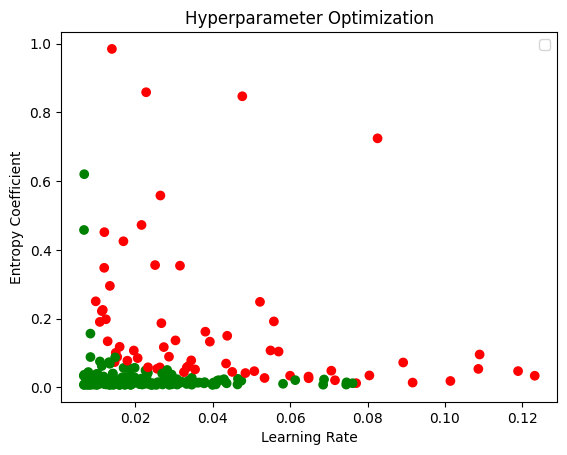

In [21]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df['learning_rate'], results_df['ent_coef'], 
                     c=results_df['status'].apply(lambda x: 'green' if x == 'ok' else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# y lim to 0.2
# plt.ylim(0, 0.2)
# x lim to 0.05
# plt.xlim(0, 0.05)
plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
plt.show()


c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


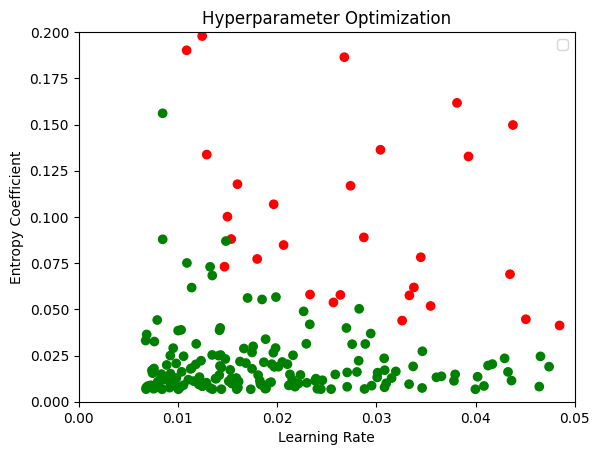

In [22]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df['learning_rate'], results_df['ent_coef'], 
                     c=results_df['status'].apply(lambda x: 'green' if x == 'ok' else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# y lim to 0.2
plt.ylim(0, 0.2)
# x lim to 0.05
plt.xlim(0, 0.05)
plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
plt.show()


In [23]:
# this showed that window sizes above 10 failed

# # what is the count of the different window sizes grouped by status
# results_df.groupby(['window_size', 'status']).size()
# # Define a dictionary that maps window sizes to marker shapes
# marker_dict = {10: '^', 20: 'o', 50: 's'}

# # Create a new column in the DataFrame that maps window sizes to marker shapes
# results_df['marker'] = results_df['window_size'].map(marker_dict)

# fig, ax = plt.subplots()

# # Loop over each group of points with the same marker shape
# for marker in results_df['marker'].unique():
#     subset = results_df[results_df['marker'] == marker]
#     scatter = ax.scatter(subset['learning_rate'], subset['ent_coef'], 
#                          c=subset['status'].apply(lambda x: 'green' if x == 'ok' else 'red'), 
#                          marker=marker)

# ax.set_xlabel('Learning Rate')
# ax.set_ylabel('Entropy Coefficient')
# ax.set_title('Hyperparameter Optimization')
# # y lim to 0.2
# plt.ylim(0, 0.2)
# # x lim to 0.05
# plt.xlim(0, 0.05)
# # increase the figure size
# fig.set_size_inches(20, 20)
# # plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
# plt.show()

In [29]:
# only successes 
results_df_success = results_df[results_df['status'] == 'ok']
results_df_success_negative = results_df_success[results_df_success['loss'] < 0]

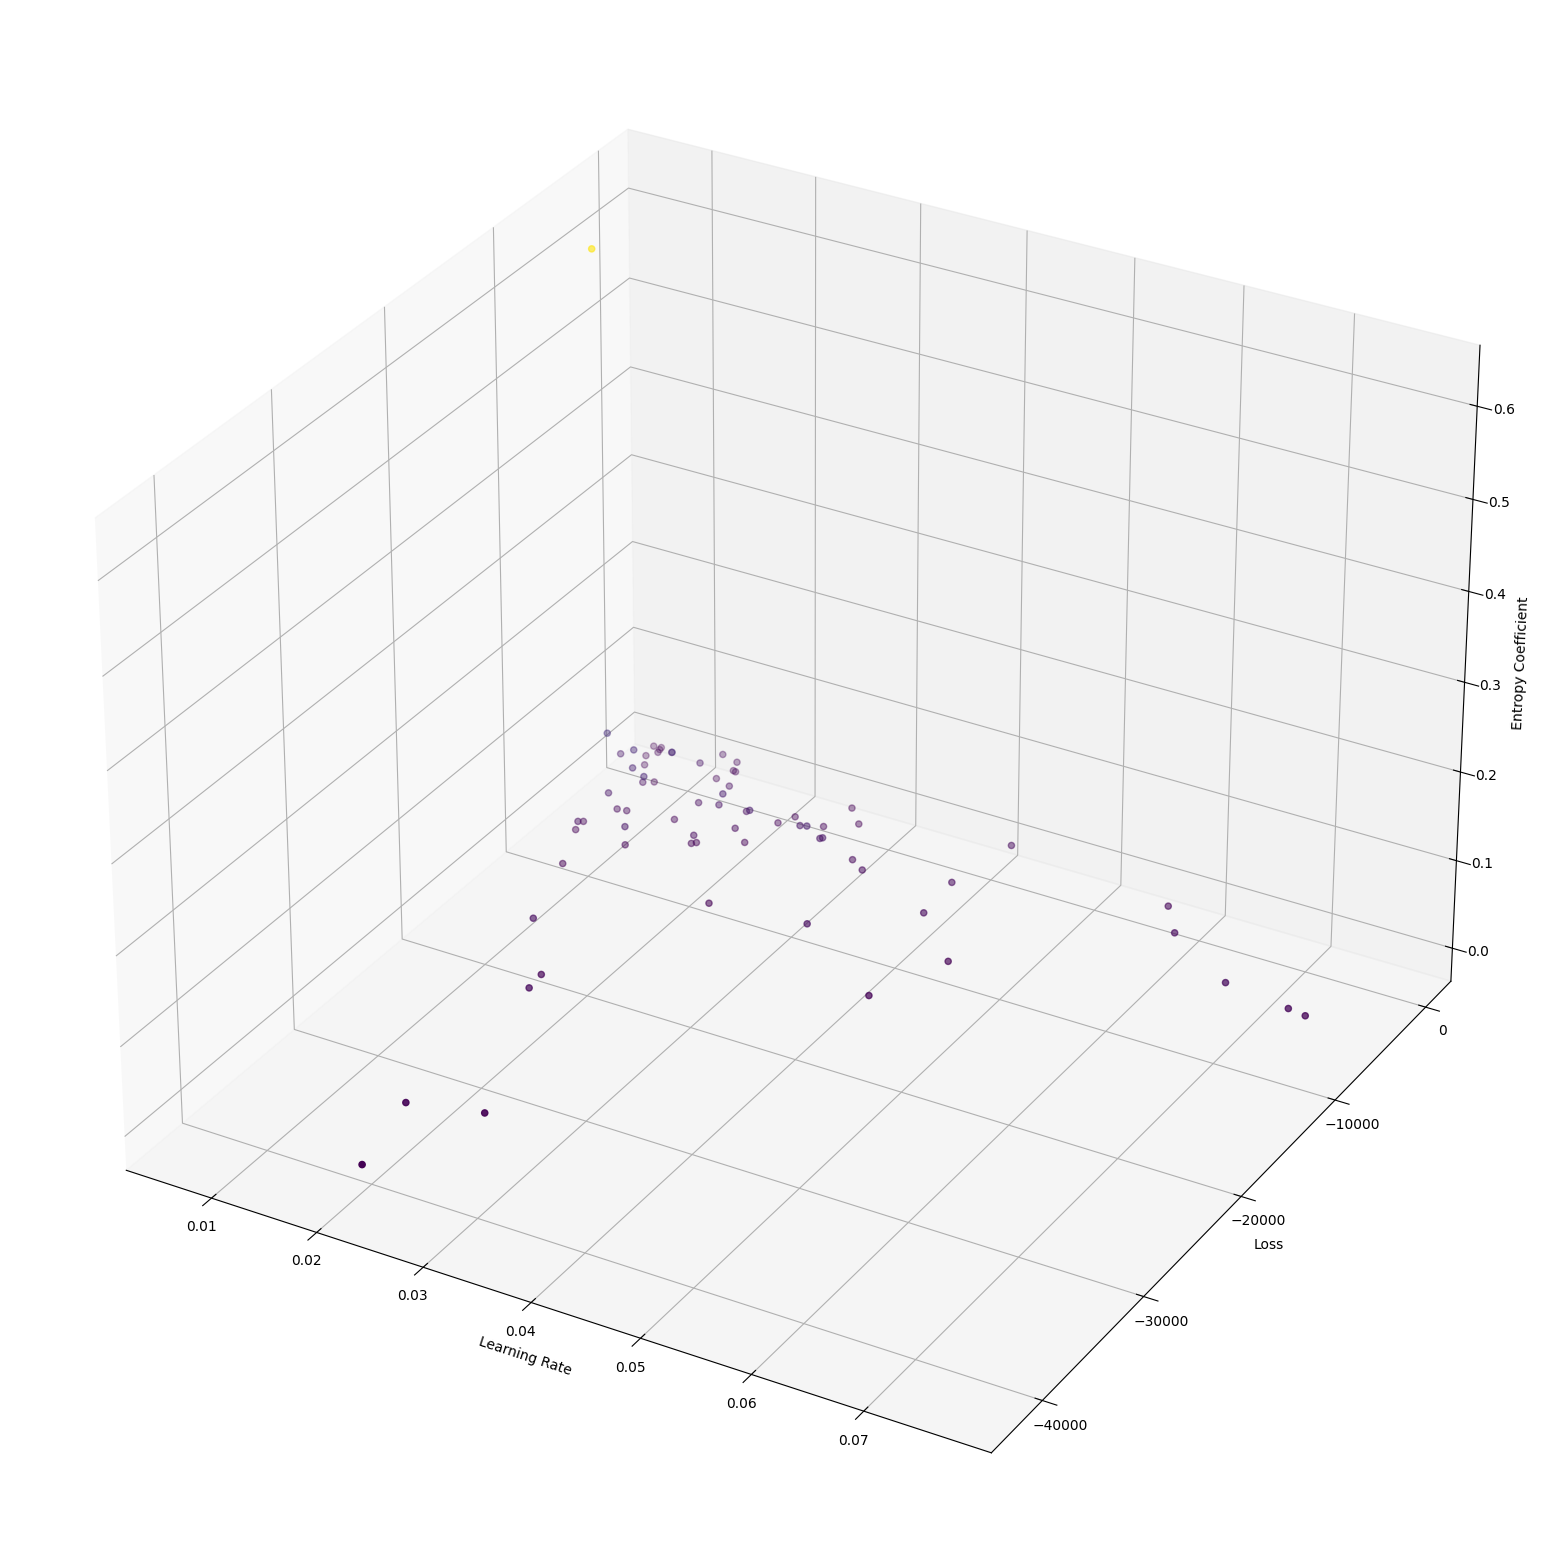

In [30]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = results_df_success_negative['learning_rate']
y = results_df_success_negative['loss']
z = results_df_success_negative['ent_coef']

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')

# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


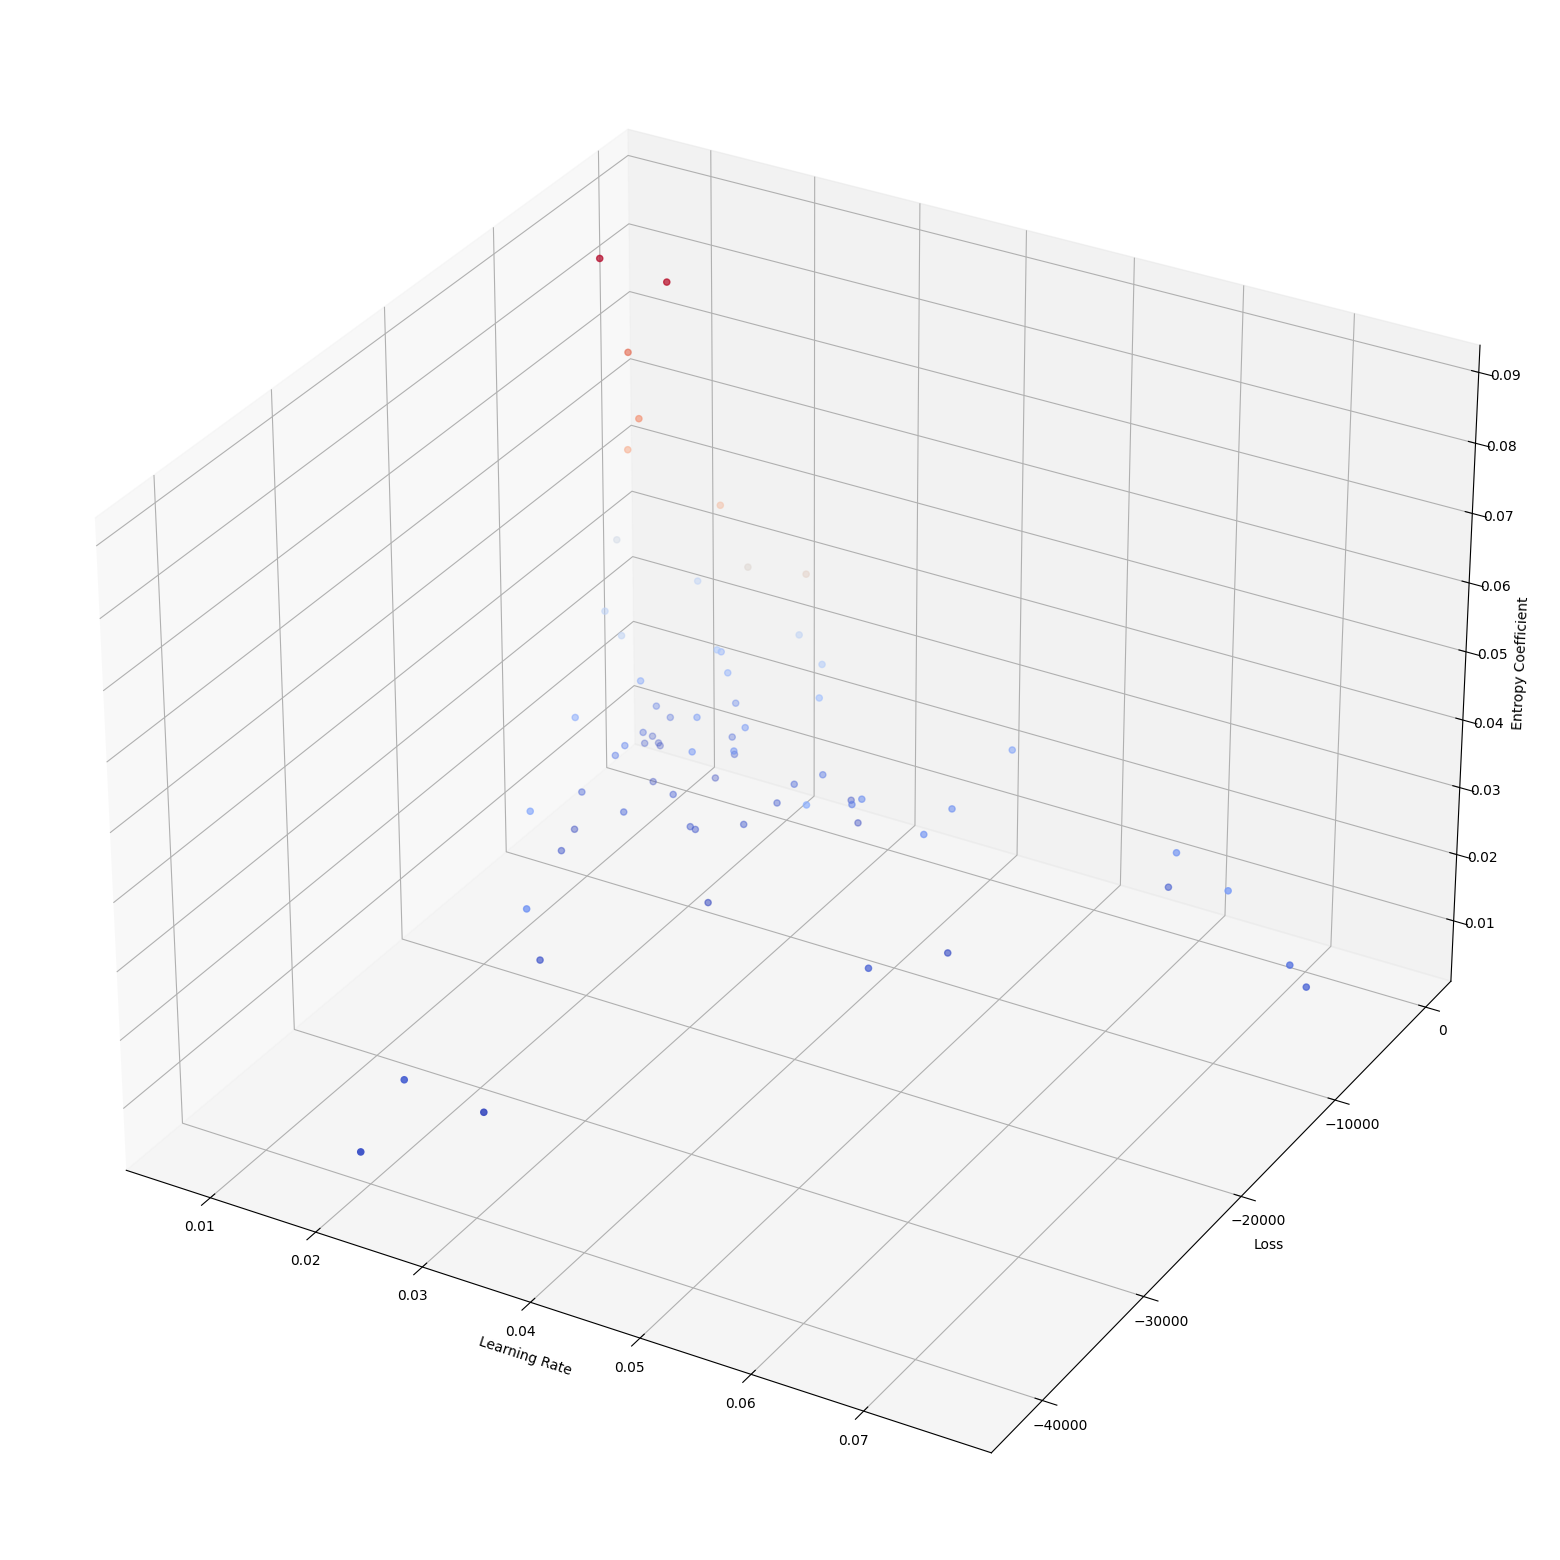

In [37]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

results_df_success_negative_low_entropy = results_df_success_negative[results_df_success_negative['ent_coef'] <= 0.2]

x = results_df_success_negative_low_entropy['learning_rate']
y = results_df_success_negative_low_entropy['loss']
z = results_df_success_negative_low_entropy['ent_coef']

ax.scatter(x, y, z, c=z, cmap=cm.coolwarm)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')



# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


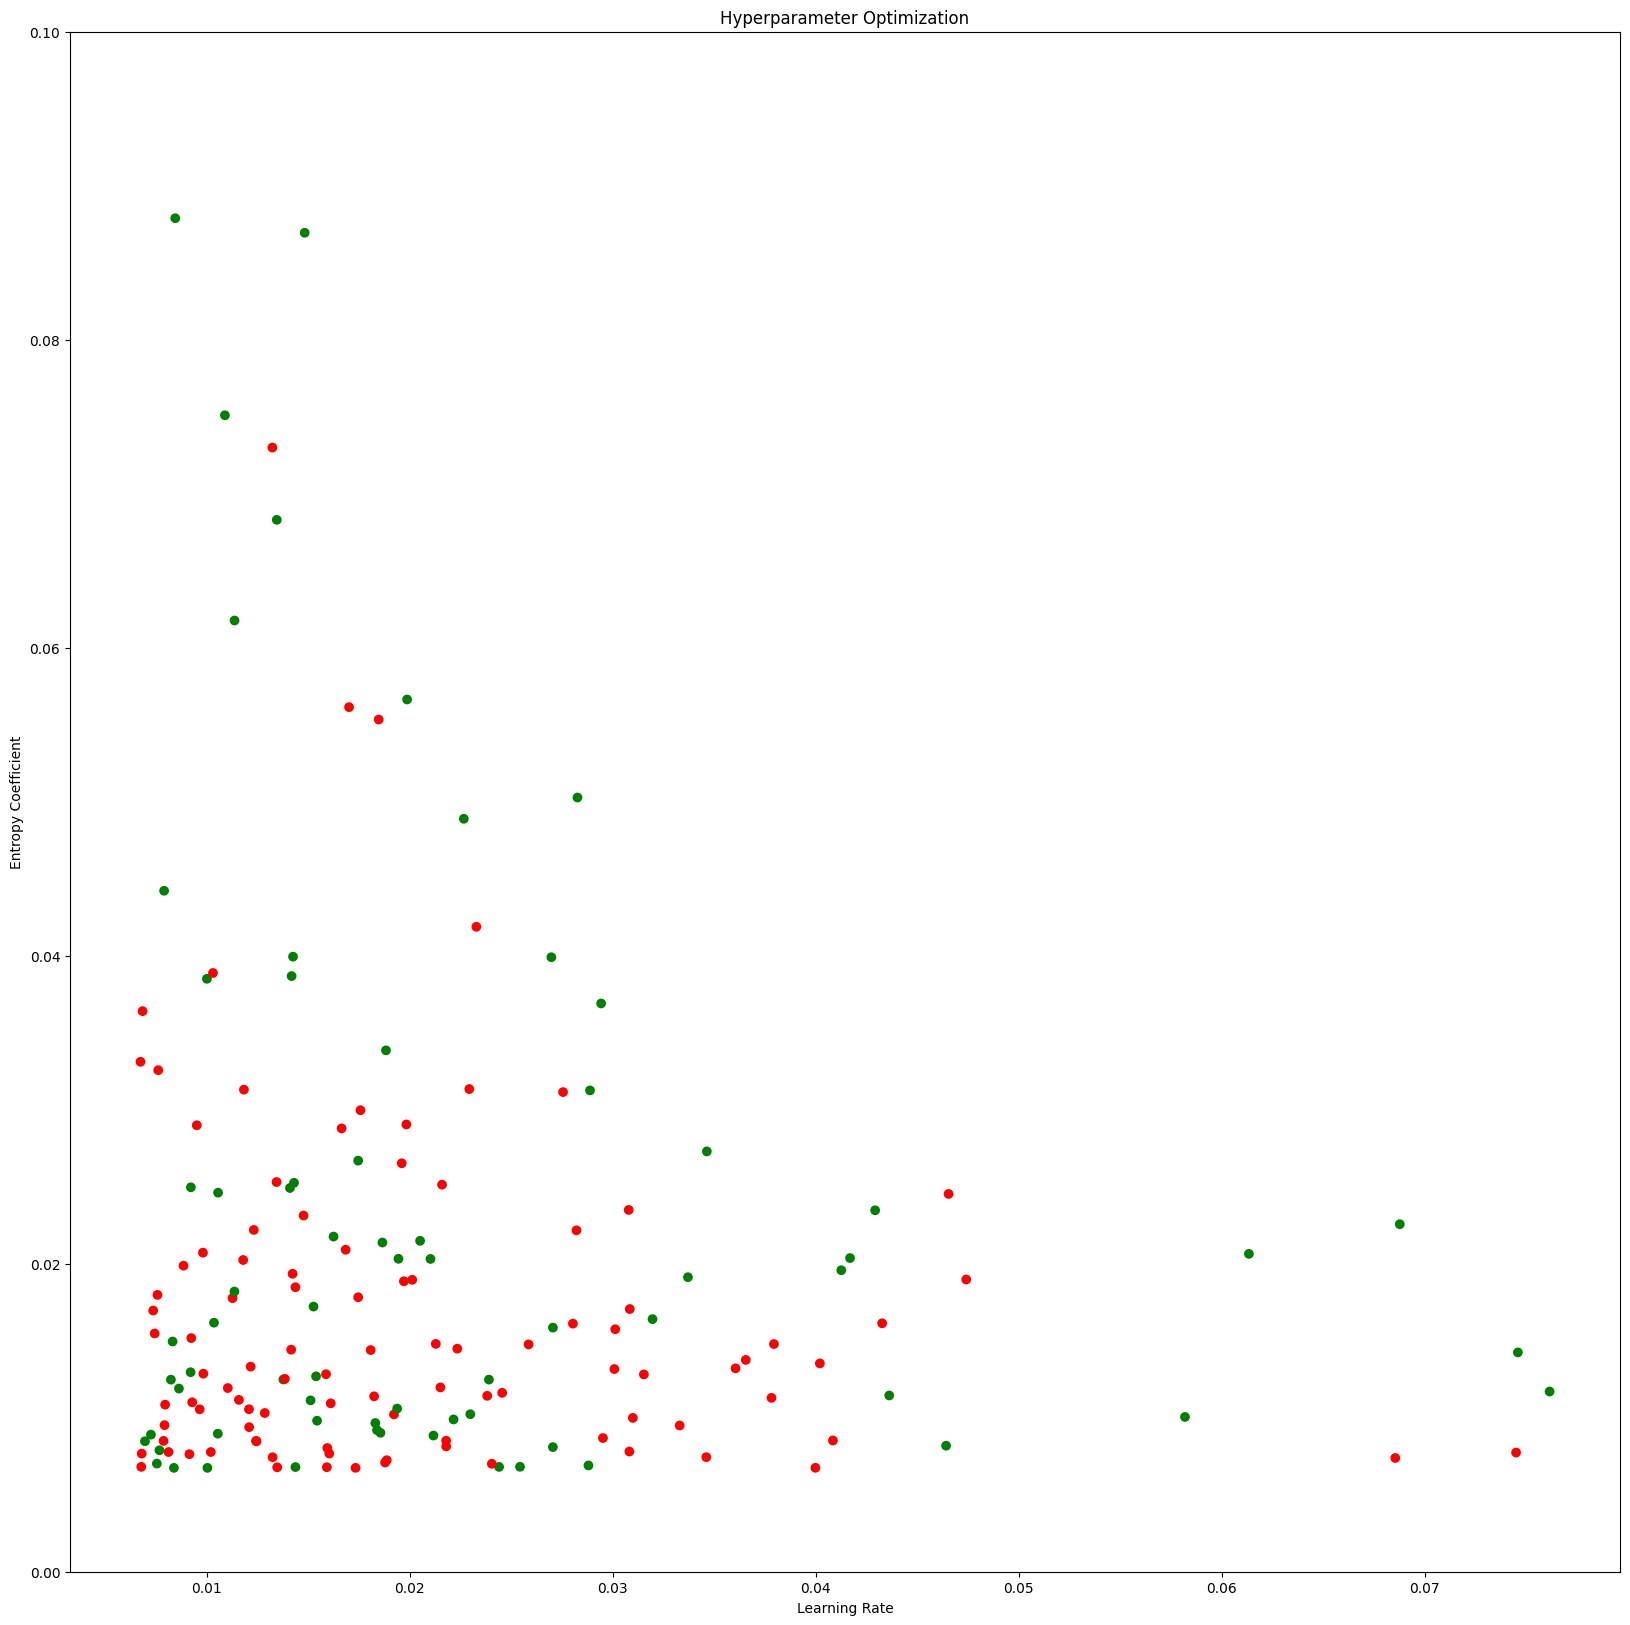

In [41]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'].apply(lambda x: 'green' if x < 0 else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(20, 20)
plt.show()


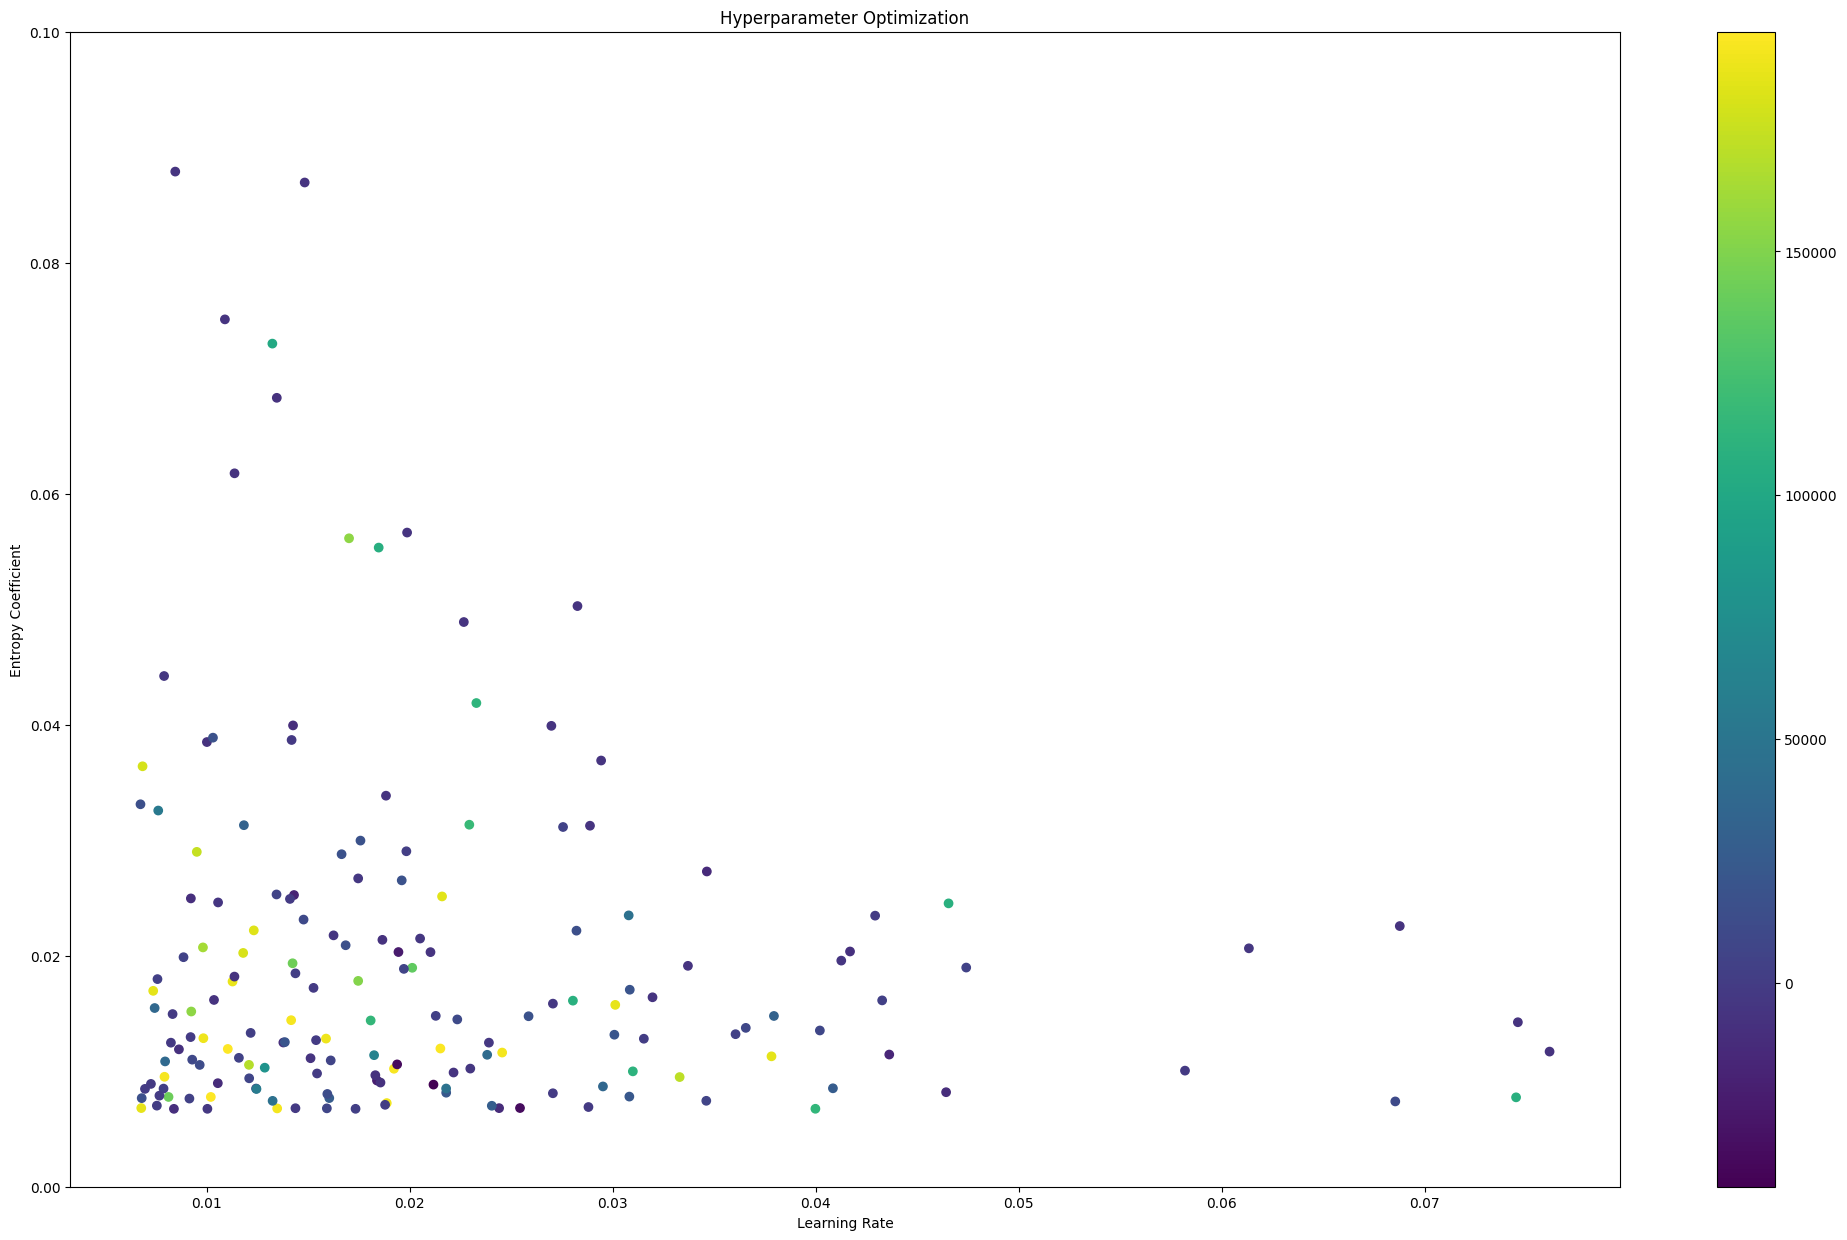

In [55]:

# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'], cmap='viridis')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


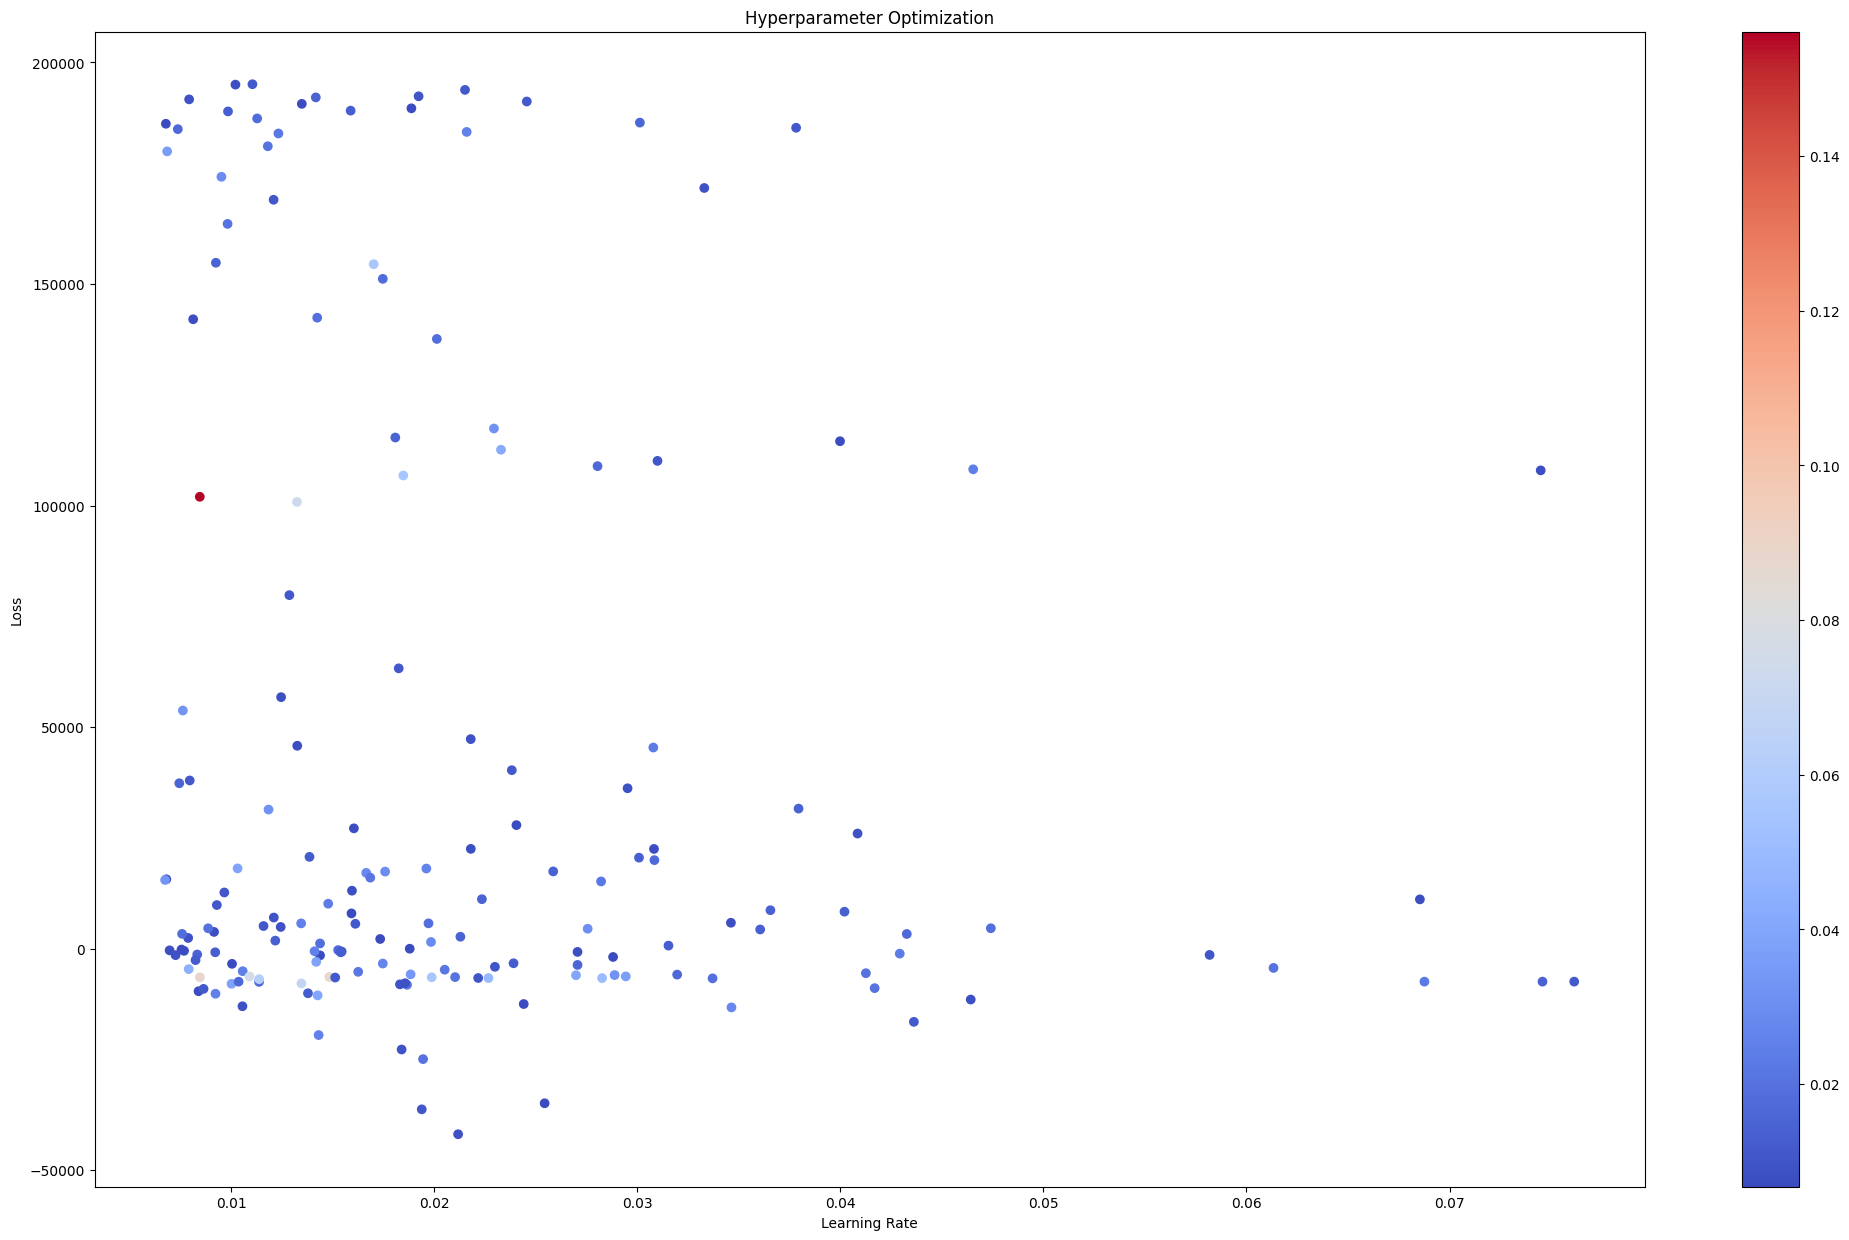

In [65]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['learning_rate'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['ent_coef'], cmap=cm.coolwarm)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


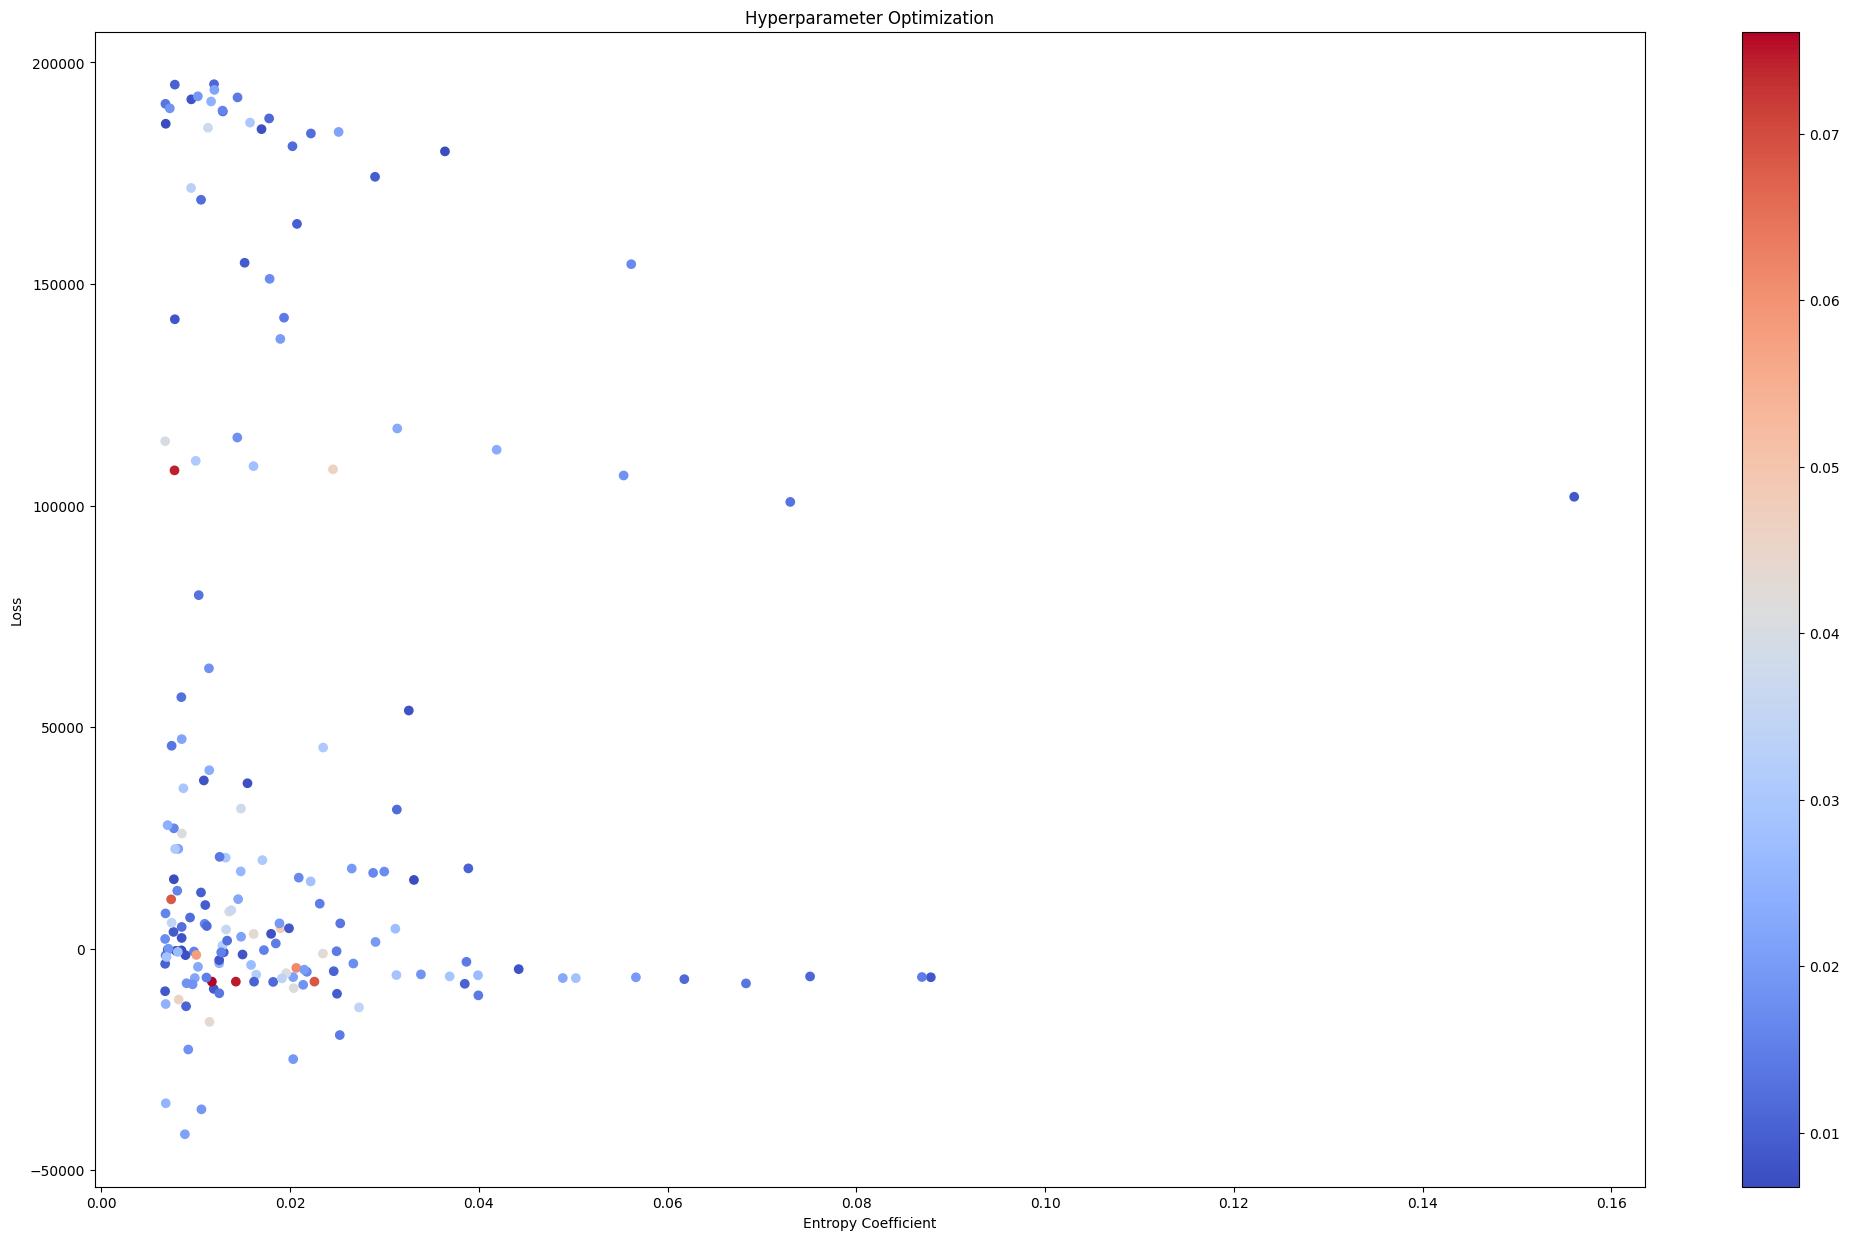

In [64]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['ent_coef'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['learning_rate'], cmap=cm.coolwarm)
ax.set_xlabel('Entropy Coefficient')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


### Plot Results

In [35]:
# # create a dataframe of the rewards
# rewards_df = pd.DataFrame({'rewards': rewards})
# # plot the rewards
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=rewards_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()


In [36]:
# # import the models from /models folder
# import os
# import glob
# # get the list of models
# model_list = glob.glob('models_4_17_24/*.pkl')
# # separate the strings of each model name on _ and get the last element of the string if the string of the model doesn't include 'initial' or 'updated'
# model_list_episode_nbr = [model.split('_')[-1] for model in model_list if 'initial' not in model and 'updated' not in model]
# model_list_episode_nbr = [int(model_name.split('.')[0]) for model_name in model_list_episode_nbr]
# max_episode = max(model_list_episode_nbr)
# # test the last set of 10 episodes
# init_episode = ((int(max_episode)/10) - 10)*10
# # print(max_episode, init_episode)
# models = []
# # test the last set of 10 episodes from init_episode to max_episode
# for nbr in range(int(init_episode), int(max_episode)+10, 10):
#     # set up the appropriate time_points for each of the models in the list
#     env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index)# make this -nbr not +nbr next time
#     obs_train, info_train = env_train.reset(seed=2024)
#     # find the model name that contains the nbr
#     model_name = [model for model in model_list if str(nbr) in model][0]
#     print(model_name)
#     # load the models into a list
#     models.append(PPO.load(model_name, env=env_train))

In [37]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = window_size_param,
#     time_points=list(testing_index_slice),
#     hold_threshold=0.1,
#     close_threshold=0.1,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [38]:
# model_ppo = PPO.load(f'models_4_17_24\model_25K_5.pkl', env=env_train)

# obs_test, info_test = env_testing.reset(seed=2024)
# done_test = False
# while not done_test:
#     action, _states = model_ppo.predict(obs_test)
#     obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#     done_test = terminated_test or truncated_test
#     # total_reward += reward_test
#     if done_test:
#         break
# try:
#     order_len = len(env_testing.render()['orders'])
# except:
#     order_len = 0
# # print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")


In [39]:
# # if model_dict is still a thing
# for timestep in timesteps_models_dict.keys():
#     models_dict = timesteps_models_dict[timestep]

#     for nbr in range(0, 10):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in range(0, 10):   
#             total_reward = 0
#             done_test = False
#             model_ppo = models_dict[f'model_{nbr}']

#             obs_test, info_test = env_train.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_train.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_train.render()['orders'])
#             except:
#                 order_len = 0
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes)
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [40]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [41]:
# # if model_dict is still a thing
# for timestep in ['25K']:
#     for nbr in tqdm(range(1, 10)):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         number_of_orders_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in tqdm(range(0, 10)):   
#             total_reward = 0
#             done_test = False
#             model_ppo = PPO.load(f'models_4_17_24\model_{timestep}_{nbr}.pkl', env=env_train)

#             obs_test, info_test = env_testing.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_testing.render()['orders'])
#             except:
#                 order_len = 0
#             number_of_orders_across_episodes.append(order_len)
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes, 'Reward')
#         print_stats(number_of_orders_across_episodes, 'Orders')
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [42]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [43]:
# # if the cluster has been restarted
# for nbr, time_points_idx in zip(range(0, 10), range(0, 500, 50)):
#     # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))
#     env_train = MtEnv(
#         original_simulator=sim_train,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         time_points=list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(time_points_idx)), :].index),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     # obs_train, info_train = env_train.reset(seed=2024)
#     total_reward = 0
#     done_test = False
#     model_ppo = PPO.load(f'models\model_{nbr}.pkl', env=env_train)

#     env_testing = MtEnv(
#         original_simulator=sim_testing,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         # time_points=list(testing_index_slice),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     obs_test, info_test = env_testing.reset(seed=2024)
#     while not done_test:
#         action, _states = model_ppo.predict(obs_test)
#         obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#         done_test = terminated_test or truncated_test
#         total_reward += reward_test
#         if done_test:
#             break
#     state = env_testing.render()

#     print(
#         f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
#         f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"

#     )
#     # print(state['orders'].Profit.sum())
#     if len(state['orders']) > 0:
#         print(state['orders'].Profit.sum())

In [44]:
# max_episode = 120
# for model_nbr in range(0, int(max_episode)+10, 10):
#     print(f'Model: {model_nbr}')
#     over_episodes_rewards = []
#     over_episodes_balance = []
#     obs_training, info_training = env_train.reset(seed=2024)
#     for episode in range(0, 10):
#         obs_test, info_test = env_testing.reset(seed=2024)
        
#         # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))

#         total_reward = 0
#         done_test = False
#         env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(model_nbr)), :].index)
#         obs_training, info_training = env_train.reset(seed=2024)
#         model_ppo = PPO.load(f'models\model_{model_nbr}.pkl', env=env_train)

#         while not done_test:
#             action, _states = model_ppo.predict(obs_test)
#             obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#             done_test = terminated_test or truncated_test

#             total_reward += reward_test
#             if done_test:
#                 break
#         over_episodes_balance.append(info_test['balance'])
#         over_episodes_rewards.append(total_reward)
#         print(f'Episode: {episode}, Reward: {total_reward:.3f}, Balance: {info_test["balance"]:.3f}')
#     print_stats(over_episodes_rewards)
#     print_stats(over_episodes_balance)

In [45]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()